In [23]:
from time import time
import networkx as nx
import pickle
import time
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import os
import torch
from collections import defaultdict
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm
from torch.utils.data import DataLoader
import torch.utils.data as Data
import numpy as np
import math
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn.parameter import Parameter
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class args(object):
    
    #### DATA  ####
    node_size = 4 # equals to the number of nodes + 1 (zero_padding)
    seq_len = 10
    
    #### Training ####
    batch_size = 32
    lr = 0.0002
    beta1 = 0.9
    beta2 = 0.999
    LSTM_maxnorm = 0.25
    acc_threshold = 0.5
    try_valid = 20
    running_loss = False
    n_epoch = 50
    weight_reg = 0
    
    
    #### Model ####
    RNN_model = 'lstm' # The hidden_size has to be a list if using nalu
    hidden_size = [50]
    num_layers = 5
    embedding_dim = 50
    embedding_maxnorm = None
    bidirectional = True
    model_name = 'SiameseColour' 
    model_path ='./'+ model_name +'/Model/'
    
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

'''
TODO:

'''   

with open("PlanarColour10thData.txt", "rb") as fp:   # Unpickling
    df = pickle.load(fp)
X = df[['left','right']]     
Y = df['target']    
del df

#Seperate to training, validation, and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 64)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size= 0.05,random_state= 64)
Y_test = Y_test.values
Y_train = Y_train.values
Y_validation = Y_validation.values

#Check shape
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

def padding(data):
    left = [] 
    for i in range(data.shape[0]):
        left.append((data.iloc[i]['left']))
    right = [] 
    for i in range(data.shape[0]):
        right.append((data.iloc[i]['right']))
    return torch.tensor(np.array([right,left])).transpose(1,0)

def plot_train_hist(train_hist, step = None, ):
    fig = plt.figure(figsize=(20, 10))
    for name in train_hist.keys():
        if 'Loss' in name:
            plt.subplot(211)
            plt.plot(train_hist[name],marker='o',label= name)
            plt.ylabel('Loss',fontsize=15)
            plt.xlabel('Number of epochs',fontsize=15)
            plt.title('Loss',fontsize=20,fontweight ="bold")
            plt.legend(loc='upper left')
        else:
            plt.subplot(212)
            plt.plot(train_hist[name],marker='o',label= name)
            plt.ylabel('Accuracy',fontsize=15)
            plt.xlabel('Number of epochs',fontsize=15)
            plt.title('Accuracy',fontsize=20,fontweight ="bold")
            plt.legend(loc='upper left')
        
    plt.tight_layout()
    plt.show()
    if step is not None:
        fig.savefig("Train_Hist"+str(step)+".png") 


#Padding and creat the loaders
X_train = padding(X_train)
Y_train = torch.FloatTensor(np.array(Y_train))
train_dataset  = Data.TensorDataset(X_train,Y_train)

X_validation = padding(X_validation)
Y_validation = torch.FloatTensor(np.array(Y_validation))
val_dataset  = Data.TensorDataset(X_validation,Y_validation)

X_test = padding(X_test)
Y_test = torch.FloatTensor(np.array(Y_test))
test_dataset  = Data.TensorDataset(X_test,Y_test)


In [24]:
class NeuralAccumulatorCell(nn.Module):
    
    # Feed forward but Weight decomposition
    
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim

        self.W_hat = Parameter(torch.Tensor(out_dim, in_dim))
        self.M_hat = Parameter(torch.Tensor(out_dim, in_dim))
        self.W = Parameter(torch.tanh(self.W_hat) * torch.sigmoid(self.M_hat))
        self.register_parameter('bias', None)

        init.kaiming_uniform_(self.W_hat, a=math.sqrt(5))
        init.kaiming_uniform_(self.M_hat, a=math.sqrt(5))
        
        #init.normal_(self.W_hat)
        #init.normal_(self.M_hat)
        
    def forward(self, input):
        return F.linear(input, self.W, self.bias)


class NAC(nn.Module):
    
    def __init__(self, dims):
        '''
        dims = [input_dim + hidden_dims + output_dims]
        '''
        super().__init__()
        self.num_layers = len(dims) - 1
        
        layers = nn.ModuleList()
        layers.extend([NeuralAccumulatorCell(dims[i],dims[i+1]) for i in range(self.num_layers)])
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        out = self.model(x)
        return out

class NeuralArithmeticLogicUnitCell(nn.Module):

    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.eps = 1e-10

        self.G = Parameter(torch.Tensor(out_dim, in_dim))
        self.W = Parameter(torch.Tensor(out_dim, in_dim))
        self.register_parameter('bias', None)
        self.nac = NeuralAccumulatorCell(in_dim, out_dim)

        init.kaiming_uniform_(self.G, a = math.sqrt(5))
        init.kaiming_uniform_(self.W, a = math.sqrt(5))

    def forward(self, input):
        
        a = self.nac(input)
        g = torch.sigmoid(F.linear(input, self.G, self.bias))
        add_sub = g * a
        log_input = torch.log(torch.abs(input) + self.eps)
        m = torch.exp(self.nac(log_input))
        # m = torch.exp(F.linear(log_input, self.W, self.bias))
        mul_div = (1 - g) * m
        y = add_sub + mul_div
        return y


class NALU(nn.Module):
    
    def __init__(self, dims):
        super().__init__()
        self.num_layers = len(dims) - 1
        layers = nn.ModuleList()
        layers.extend([NeuralArithmeticLogicUnitCell(dims[i],dims[i+1]) for i in range(self.num_layers)])
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        out = self.model(x)
        return out

class NALU_LSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size, bias=True):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.i2h = nn.Sequential(
            nn.Linear(input_size, 4 * hidden_size, bias=bias),
            nn.BatchNorm1d(4 * hidden_size),
#             nn.LeakyReLU(0.2,inplace=True),
#             nn.Linear(4 *input_size, 4 * hidden_size, bias=bias),
        )
        self.h2h = nn.Sequential(
            nn.Linear(hidden_size, 4 * hidden_size, bias=bias),
           nn.BatchNorm1d(4 * hidden_size),
#             nn.LeakyReLU(0.2,inplace=True),
#             nn.Linear(4 * hidden_size, 4 * hidden_size, bias=bias)
        )
        self.nalu_h = NALU([hidden_size, hidden_size])
        self.nalu_c = NALU([hidden_size, hidden_size])
        self.out = nn.Linear(hidden_size, input_size, bias=bias)
        self.apply(self.weight_init)

    def weight_init(self,m):

        std = 1.0 / math.sqrt(self.hidden_size)
        for name, w in m.named_parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, hidden = None):
        
        if hidden is None:
            hidden = x.new_zeros(x.size(0), self.hidden_size, requires_grad=False)
            hidden = (hidden, hidden)
            
        h, c = hidden
        
        preact = self.i2h(x) + self.h2h(h)
        
        # First: apply nalu to replace activation func
        
        # self.nalu(preact)
        
        gates = preact[:, :3 * self.hidden_size].sigmoid()
        g_t = preact[:, 3 * self.hidden_size:].tanh()
        i_t = gates[:, :self.hidden_size] 
        f_t = gates[:, self.hidden_size:2 * self.hidden_size]
        o_t = gates[:, -self.hidden_size:]
        
        # Second: Apply it in the output and hidden layer

        c_t = (c*f_t) + (i_t*g_t)

        h_t = o_t * c_t.tanh()
        
        # return x, (h_t, c_t) # LSTM
        
        # return x + self.out(h_t), (h_t + h, c_t + c) # Residule LSTM

        return  x + self.out(h_t) , (self.nalu_h(h_t + h), self.nalu_c(c_t + c)) # Residule NALU

class NALU_LSTM(nn.Module):
    
    def __init__(self,input_size, hidden_sizes, bidirectional = False):
        
        super().__init__()
        self.bidirectional = bidirectional
        
        if self.bidirectional:
            self.num_dir = 2
        else:
            self.num_dir = 1
            
        self.input_size = input_size
        self.L = len(hidden_sizes)
        self.layers = nn.ModuleList()
        self.layers.extend([NALU_LSTMCell(input_size,i) for i in hidden_sizes])
        self.c0 = nn.ParameterList([nn.Parameter(torch.randn(self.num_dir, 1,i)) for i in hidden_sizes])
        self.h0 = nn.ParameterList([nn.Parameter(torch.randn(self.num_dir, 1,i)) for i in hidden_sizes])
        
        
    def forward(self, input):
        
        '''
        input_shape = B, S, input_size
        output_shape = B, num_dir, L, S, input_size
        hidden, cells = S * (B, hidden_dim)
        '''
        
        B,S = input.shape[:-1]
        
        outputs = torch.zeros(B, self.num_dir, self.L+1, S, self.input_size)
        outputs[:,:,0,:,:] = input.unsqueeze(1).expand_as(outputs[:,:,0,:,:])
        hiddens = []
        cells = []
    
        for i, layer in enumerate(self.layers):
            f_h, f_c = self.h0[i][0].repeat(B,1), self.c0[i][0].repeat(B,1)
            if self.bidirectional:
                i_h, i_c = self.h0[i][1].repeat(B,1), self.c0[i][1].repeat(B,1)
            for j in range(S):
                f_out, (f_h,f_c) = layer(outputs[:,0,i,j,:].clone(), (f_h,f_c))
                outputs[:,0,i+1,j,:] = f_out

            if self.bidirectional:
                for j in reversed(range(S)):
                    i_out, (i_h,i_c) = layer(outputs[:,1,i,j,:].clone(), (i_h,i_c))
                    outputs[:,1,i+1,j,:] = i_out
                hiddens.append((torch.stack([f_h,i_h])))
                cells.append(torch.stack([f_c,i_c]))
            else:
                hiddens.append(f_h)
                cells.append(f_c)
                
        #outputs = outputs[:,:,-1:,:,:]
        return outputs[:,:,1:,:,:].contiguous(), (hiddens, cells)

In [25]:
class RNN_Encoder(nn.Module):
    def __init__(self, model = 'lstm'):
        super(RNN_Encoder, self).__init__()
        
        # No need for padding, but if we need the padding, we have to set the idx as 0
        # So that's why we need to make the graph start from 0
        self.model = model
        self.embedding = nn.Embedding(args.node_size, embedding_dim = args.embedding_dim, padding_idx=0,
                                      max_norm = args.embedding_maxnorm)
        

        if args.bidirectional:
            num_dir = 2
            fc_size1= args.hidden_size[-1]*args.seq_len*2
            fc_size2= 128
        else:
            num_dir = 1
            fc_size1= args.hidden_size[-1]
            fc_size2= 16
            
        self.fc= nn.Sequential(
            nn.Linear(fc_size1,fc_size2),
            nn.BatchNorm1d(fc_size2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(fc_size2,2),
        )
        
        
        
        if self.model == 'lstm':
            self.rnn = nn.LSTM(input_size = args.embedding_dim, hidden_size = args.hidden_size[-1],
                           num_layers = args.num_layers, bidirectional = args.bidirectional, batch_first = True)
            self.h0 = nn.Parameter(torch.randn(args.num_layers*num_dir, 1, args.hidden_size[-1]))
            self.c0 = nn.Parameter(torch.ones(args.num_layers*num_dir, 1, args.hidden_size[-1]))
            print('Using LSTM')
        elif self.model == 'gru':
            self.h0 = nn.Parameter(torch.randn(args.num_layers*num_dir, 1, args.hidden_size[-1]))
            self.rnn = nn.GRU(input_size= args.embedding_dim, hidden_size= args.hidden_size[-1],
                              num_layers = args.num_layers, bidirectional = args.bidirectional, batch_first = True)
            print('Using GRU')
            
        elif self.model == 'nalu':
            self.rnn = NALU_LSTM(args.embedding_dim, args.hidden_size, bidirectional= args.bidirectional)
            print('Using NALU')
        else:
            raise NotImplementedError

        
    def forward(self, x):
        
        B = x.size(0)
        
        out = self.embedding(x)
        
        if self.model == 'lstm':
            h_ = (self.h0.repeat(1,B,1), self.c0.repeat(1,B,1))
        elif self.model == 'gru':
            h_ = self.h0.repeat(1,B,1)
        
        if self.model =='nalu':
            out, hidden = self.rnn(out)
            out = out[:,:,-1,:,:].squeeze() 
        else:
            out, hidden = self.rnn(out, h_)
        
        if args.bidirectional:
            out = self.fc(out.contiguous().view(B,-1))
        else:
            out = self.fc(out[:,-1,:])
        return out
    
    

class SiameseNet(nn.Module):
    def __init__(self,):
        super(SiameseNet, self).__init__()
        
        self.encoder = RNN_Encoder(args.RNN_model)
        self.mse = nn.MSELoss()
        self.train_hist = defaultdict(list)
        self.acc_hist = []
        self.apply(self.weight_init)
        
        self.optim = optim.Adam(self.encoder.parameters(), lr = args.lr, betas= (args.beta1, args.beta2),
                                weight_decay = args.weight_reg)
        
    def forward(self, x, y):
        
        self.optim.zero_grad()
        left = x[:,0,:]
        right = x[:,1,:]
        
        left_out = self.encoder(left)
        right_out = self.encoder(right)
        self.prediction = torch.exp(-torch.norm((left_out - right_out),1,-1))
        self.loss = self.mse(self.prediction, y)
        self.take = left_out - right_out
        
        if args.LSTM_maxnorm is not None:
            nn.utils.clip_grad_norm_(self.encoder.rnn.parameters(), args.LSTM_maxnorm)
        self.acc = torch.mean(((self.prediction>args.acc_threshold) == (y.byte())).float())
        self.train_hist['Loss'].append(self.loss.item())
        self.train_hist['Accuracy'].append(self.acc.item())
        self.loss.backward()
        self.optim.step()
        
    def weight_init(self,m):
        if type(m) in [nn.Conv2d, nn.ConvTranspose2d, nn.Linear]:
            nn.init.kaiming_normal_(m.weight,0.2,nonlinearity='leaky_relu')
        elif type(m) in [nn.LSTM]:
            for name, value in m.named_parameters():
                if 'weight' in name :
                    nn.init.xavier_normal_(value.data)
                if 'bias'in name:
                    value.data.normal_()
                    
    def model_save(self,step):
        
        path = args.model_path + args.model_name+'_Step_' + str(step) + '.pth'
        torch.save({args.model_name:self.state_dict()}, path)
        print('Model Saved')
        
    def load_step_dict(self, step):
        
        path = args.model_path + args.model_name +'_Step_' + str(step) + '.pth'
        self.load_state_dict(torch.load(path, map_location = lambda storage, loc: storage)[args.model_name])
        print('Model Loaded')
        
           
    def plot_all_loss(self, step):
        fig = plt.figure(figsize=(20, 10))
        num_loss = 2
        i = 0
        for name in self.train_hist.keys():
            if 'V' not in name:
                i+= 1
                fig.add_subplot(num_loss,1,i)
                plt.plot(self.train_hist[name], label = name)
                plt.xlabel('Number of Steps',fontsize=15)
                plt.ylabel( name, fontsize=15)
                plt.title(name, fontsize=30, fontweight ="bold")
                plt.legend(loc = 'upper left')
        plt.tight_layout()
        plt.show()
        fig.savefig("Train_Hist"+str(step)+".png") 
        
    def test_step(self, x, y):
        
        left = x[:,0,:]
        right = x[:,0,:]
        
        left_out = self.encoder(left)
        right_out = self.encoder(right)
        
        self.v_prediction = torch.exp(-torch.norm((left_out - right_out),1,-1)).detach()
        self.v_loss = self.mse(self.v_prediction, y)
        self.v_acc = torch.mean(((self.v_prediction>args.acc_threshold) == (y.byte())).float())
        self.train_hist['V_Loss'].append(self.v_loss.item())
        self.train_hist['V_Accuracy'].append(self.v_acc.item())    

In [26]:
train_loader = DataLoader(train_dataset, batch_size = args.batch_size, shuffle=True, drop_last = True)
valid_loader = DataLoader(val_dataset, batch_size = args.batch_size, shuffle=True, drop_last= True)

In [27]:
args.weight_reg = 0
args.RNN_model = 'nalu'
siamese = SiameseNet().to(device)
siamese.train()
scheduler = optim.lr_scheduler.StepLR(siamese.optim, 5000, gamma=0.5)
siamese.optim.param_groups[0]['lr']= 0.0002

Using NALU


In [28]:
train_hist = defaultdict(list)
args.running_loss = True
args.n_epoch = 50
all_step = 0
epoch = 0

| Epoch [0] | Step [1] | lr [0.000200] | Loss: [0.2626] | Acc: [0.6562] | Time: 0.1s
| Epoch [0] | Step [2] | lr [0.000200] | Loss: [0.3065] | Acc: [0.5312] | Time: 0.1s
| Epoch [0] | Step [3] | lr [0.000200] | Loss: [0.3184] | Acc: [0.3438] | Time: 0.1s
| Epoch [0] | Step [4] | lr [0.000200] | Loss: [0.3418] | Acc: [0.3438] | Time: 0.1s
| Epoch [0] | Step [5] | lr [0.000200] | Loss: [0.2900] | Acc: [0.5000] | Time: 0.1s
| Epoch [0] | Step [6] | lr [0.000200] | Loss: [0.1921] | Acc: [0.7500] | Time: 0.1s
| Epoch [0] | Step [7] | lr [0.000200] | Loss: [0.2532] | Acc: [0.6562] | Time: 0.1s
| Epoch [0] | Step [8] | lr [0.000200] | Loss: [0.2697] | Acc: [0.5625] | Time: 0.1s
| Epoch [0] | Step [9] | lr [0.000200] | Loss: [0.2684] | Acc: [0.5938] | Time: 0.1s
| Epoch [0] | Step [10] | lr [0.000200] | Loss: [0.2563] | Acc: [0.6875] | Time: 0.1s
| Epoch [0] | Step [11] | lr [0.000200] | Loss: [0.2768] | Acc: [0.4688] | Time: 0.2s
| Epoch [0] | Step [12] | lr [0.000200] | Loss: [0.2228] | Acc:

| Epoch [0] | Step [97] | lr [0.000200] | Loss: [0.1510] | Acc: [0.7500] | Time: 0.1s
| Epoch [0] | Step [98] | lr [0.000200] | Loss: [0.1637] | Acc: [0.7500] | Time: 0.1s
| Epoch [0] | Step [99] | lr [0.000200] | Loss: [0.1161] | Acc: [0.8750] | Time: 0.1s
| Epoch [0] | Step [100] | lr [0.000200] | Loss: [0.1161] | Acc: [0.8125] | Time: 0.1s
| Epoch [0] | Step [101] | lr [0.000200] | Loss: [0.1739] | Acc: [0.6875] | Time: 0.1s
| Epoch [0] | Step [102] | lr [0.000200] | Loss: [0.1275] | Acc: [0.8750] | Time: 0.1s
| Epoch [0] | Step [103] | lr [0.000200] | Loss: [0.1636] | Acc: [0.7500] | Time: 0.2s
| Epoch [0] | Step [104] | lr [0.000200] | Loss: [0.1412] | Acc: [0.8125] | Time: 0.1s
| Epoch [0] | Step [105] | lr [0.000200] | Loss: [0.1270] | Acc: [0.7812] | Time: 0.2s
| Epoch [0] | Step [106] | lr [0.000200] | Loss: [0.1356] | Acc: [0.7812] | Time: 0.1s
| Epoch [0] | Step [107] | lr [0.000200] | Loss: [0.1007] | Acc: [0.8438] | Time: 0.1s
| Epoch [0] | Step [108] | lr [0.000200] | Los

| Epoch [0] | Step [193] | lr [0.000200] | Loss: [0.1280] | Acc: [0.8125] | Time: 0.1s
| Epoch [0] | Step [194] | lr [0.000200] | Loss: [0.1642] | Acc: [0.7812] | Time: 0.1s
| Epoch [0] | Step [195] | lr [0.000200] | Loss: [0.1657] | Acc: [0.7500] | Time: 0.1s
| Epoch [0] | Step [196] | lr [0.000200] | Loss: [0.0928] | Acc: [0.8750] | Time: 0.1s
| Epoch [0] | Step [197] | lr [0.000200] | Loss: [0.1909] | Acc: [0.5625] | Time: 0.1s
| Epoch [0] | Step [198] | lr [0.000200] | Loss: [0.1228] | Acc: [0.7500] | Time: 0.1s
| Epoch [0] | Step [199] | lr [0.000200] | Loss: [0.1810] | Acc: [0.7188] | Time: 0.1s
| Epoch [0] | Step [200] | lr [0.000200] | Loss: [0.1505] | Acc: [0.7500] | Time: 0.1s
| Epoch [0] | Step [201] | lr [0.000200] | Loss: [0.1577] | Acc: [0.7188] | Time: 0.1s
| Epoch [0] | Step [202] | lr [0.000200] | Loss: [0.1355] | Acc: [0.8438] | Time: 0.1s
| Epoch [0] | Step [203] | lr [0.000200] | Loss: [0.1593] | Acc: [0.7500] | Time: 0.1s
| Epoch [0] | Step [204] | lr [0.000200] | 

| Epoch [0] | Step [289] | lr [0.000200] | Loss: [0.0957] | Acc: [0.8750] | Time: 0.1s
| Epoch [0] | Step [290] | lr [0.000200] | Loss: [0.2032] | Acc: [0.7500] | Time: 0.1s
| Epoch [0] | Step [291] | lr [0.000200] | Loss: [0.1649] | Acc: [0.7812] | Time: 0.1s
| Epoch [0] | Step [292] | lr [0.000200] | Loss: [0.1538] | Acc: [0.7188] | Time: 0.1s
| Epoch [0] | Step [293] | lr [0.000200] | Loss: [0.1170] | Acc: [0.8750] | Time: 0.1s
| Epoch [0] | Step [294] | lr [0.000200] | Loss: [0.1217] | Acc: [0.9062] | Time: 0.1s
| Epoch [0] | Step [295] | lr [0.000200] | Loss: [0.1497] | Acc: [0.7188] | Time: 0.1s
| Epoch [0] | Step [296] | lr [0.000200] | Loss: [0.1596] | Acc: [0.7188] | Time: 0.1s
| Epoch [0] | Step [297] | lr [0.000200] | Loss: [0.1110] | Acc: [0.8125] | Time: 0.1s
| Epoch [0] | Step [298] | lr [0.000200] | Loss: [0.1562] | Acc: [0.7500] | Time: 0.1s
| Epoch [0] | Step [299] | lr [0.000200] | Loss: [0.1510] | Acc: [0.7500] | Time: 0.1s
| Epoch [0] | Step [300] | lr [0.000200] | 

| Epoch [0] | Step [385] | lr [0.000200] | Loss: [0.1465] | Acc: [0.7812] | Time: 0.1s
| Epoch [0] | Step [386] | lr [0.000200] | Loss: [0.1162] | Acc: [0.8125] | Time: 0.1s
| Epoch [0] | Step [387] | lr [0.000200] | Loss: [0.1682] | Acc: [0.6875] | Time: 0.1s
| Epoch [0] | Step [388] | lr [0.000200] | Loss: [0.1336] | Acc: [0.8125] | Time: 0.1s
| Epoch [0] | Step [389] | lr [0.000200] | Loss: [0.1282] | Acc: [0.8750] | Time: 0.1s
| Epoch [0] | Step [390] | lr [0.000200] | Loss: [0.2186] | Acc: [0.6250] | Time: 0.1s
| Epoch [0] | Step [391] | lr [0.000200] | Loss: [0.1308] | Acc: [0.8125] | Time: 0.1s
| Epoch [0] | Step [392] | lr [0.000200] | Loss: [0.1013] | Acc: [0.8750] | Time: 0.1s
| Epoch [0] | Step [393] | lr [0.000200] | Loss: [0.0978] | Acc: [0.9062] | Time: 0.1s
| Epoch [0] | Step [394] | lr [0.000200] | Loss: [0.1128] | Acc: [0.8438] | Time: 0.1s
| Epoch [0] | Step [395] | lr [0.000200] | Loss: [0.1188] | Acc: [0.8438] | Time: 0.1s
| Epoch [0] | Step [396] | lr [0.000200] | 

| Epoch [0] | Validation | Step [4] |  Loss: [0.6562] | Acc: [0.3438] | Time: 0.0s
| Epoch [0] | Validation | Step [5] |  Loss: [0.5625] | Acc: [0.4375] | Time: 0.0s
| Epoch [0] | Validation | Step [6] |  Loss: [0.5938] | Acc: [0.4062] | Time: 0.0s
| Epoch [0] | Validation | Step [7] |  Loss: [0.5000] | Acc: [0.5000] | Time: 0.0s
| Epoch [0] | Validation | Step [8] |  Loss: [0.5000] | Acc: [0.5000] | Time: 0.0s
| Epoch [0] | Validation | Step [9] |  Loss: [0.3438] | Acc: [0.6562] | Time: 0.0s
| Epoch [0] | Validation | Step [10] |  Loss: [0.4375] | Acc: [0.5625] | Time: 0.0s
| Epoch [0] | Validation | Step [11] |  Loss: [0.6250] | Acc: [0.3750] | Time: 0.0s
| Epoch [0] | Validation | Step [12] |  Loss: [0.5312] | Acc: [0.4688] | Time: 0.0s
| Epoch [0] | Validation | Step [13] |  Loss: [0.5625] | Acc: [0.4375] | Time: 0.0s
| Epoch [0] | Validation | Step [14] |  Loss: [0.5938] | Acc: [0.4062] | Time: 0.0s
| Epoch [0] | Validation | Step [15] |  Loss: [0.5625] | Acc: [0.4375] | Time: 0.0

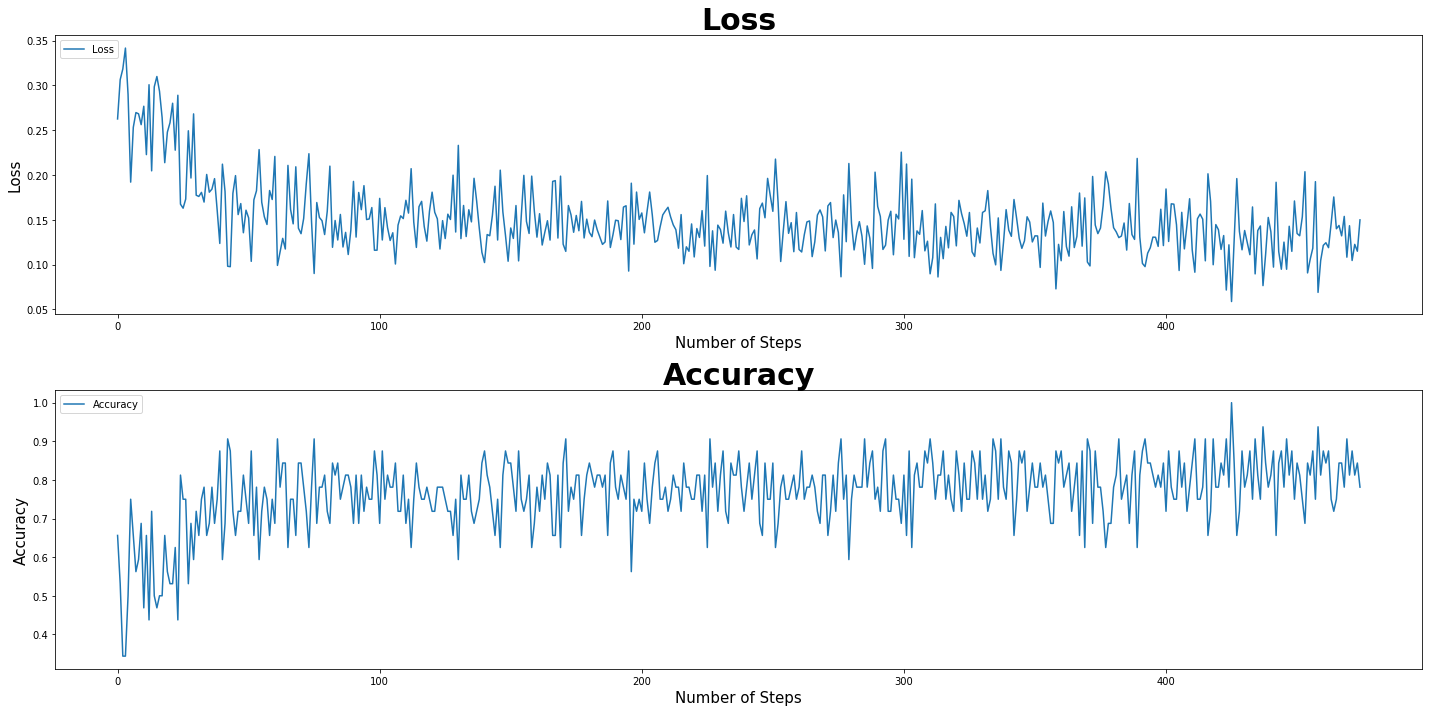

Model Saved
| Epoch [1] | Step [476] | lr [0.000200] | Loss: [0.1684] | Acc: [0.7188] | Time: 0.1s
| Epoch [1] | Step [477] | lr [0.000200] | Loss: [0.1701] | Acc: [0.7188] | Time: 0.1s
| Epoch [1] | Step [478] | lr [0.000200] | Loss: [0.1537] | Acc: [0.7500] | Time: 0.1s
| Epoch [1] | Step [479] | lr [0.000200] | Loss: [0.1763] | Acc: [0.7812] | Time: 0.1s
| Epoch [1] | Step [480] | lr [0.000200] | Loss: [0.1584] | Acc: [0.7812] | Time: 0.1s
| Epoch [1] | Step [481] | lr [0.000200] | Loss: [0.0818] | Acc: [0.9062] | Time: 0.1s
| Epoch [1] | Step [482] | lr [0.000200] | Loss: [0.1232] | Acc: [0.8438] | Time: 0.1s
| Epoch [1] | Step [483] | lr [0.000200] | Loss: [0.1245] | Acc: [0.8125] | Time: 0.1s
| Epoch [1] | Step [484] | lr [0.000200] | Loss: [0.1947] | Acc: [0.5938] | Time: 0.1s
| Epoch [1] | Step [485] | lr [0.000200] | Loss: [0.1624] | Acc: [0.7812] | Time: 0.1s
| Epoch [1] | Step [486] | lr [0.000200] | Loss: [0.1342] | Acc: [0.8750] | Time: 0.1s
| Epoch [1] | Step [487] | lr [

| Epoch [1] | Step [571] | lr [0.000200] | Loss: [0.1219] | Acc: [0.8125] | Time: 0.1s
| Epoch [1] | Step [572] | lr [0.000200] | Loss: [0.0616] | Acc: [0.9688] | Time: 0.1s
| Epoch [1] | Step [573] | lr [0.000200] | Loss: [0.1589] | Acc: [0.7188] | Time: 0.1s
| Epoch [1] | Step [574] | lr [0.000200] | Loss: [0.1679] | Acc: [0.7500] | Time: 0.1s
| Epoch [1] | Step [575] | lr [0.000200] | Loss: [0.1123] | Acc: [0.8438] | Time: 0.1s
| Epoch [1] | Step [576] | lr [0.000200] | Loss: [0.1490] | Acc: [0.8125] | Time: 0.1s
| Epoch [1] | Step [577] | lr [0.000200] | Loss: [0.1605] | Acc: [0.7812] | Time: 0.1s
| Epoch [1] | Step [578] | lr [0.000200] | Loss: [0.1147] | Acc: [0.8125] | Time: 0.1s
| Epoch [1] | Step [579] | lr [0.000200] | Loss: [0.1364] | Acc: [0.8750] | Time: 0.1s
| Epoch [1] | Step [580] | lr [0.000200] | Loss: [0.0975] | Acc: [0.9062] | Time: 0.1s
| Epoch [1] | Step [581] | lr [0.000200] | Loss: [0.1223] | Acc: [0.8438] | Time: 0.1s
| Epoch [1] | Step [582] | lr [0.000200] | 

| Epoch [1] | Step [667] | lr [0.000200] | Loss: [0.1147] | Acc: [0.8438] | Time: 0.1s
| Epoch [1] | Step [668] | lr [0.000200] | Loss: [0.1737] | Acc: [0.7188] | Time: 0.1s
| Epoch [1] | Step [669] | lr [0.000200] | Loss: [0.1641] | Acc: [0.7500] | Time: 0.1s
| Epoch [1] | Step [670] | lr [0.000200] | Loss: [0.1739] | Acc: [0.7188] | Time: 0.1s
| Epoch [1] | Step [671] | lr [0.000200] | Loss: [0.1379] | Acc: [0.8125] | Time: 0.1s
| Epoch [1] | Step [672] | lr [0.000200] | Loss: [0.1122] | Acc: [0.8125] | Time: 0.1s
| Epoch [1] | Step [673] | lr [0.000200] | Loss: [0.0983] | Acc: [0.9062] | Time: 0.1s
| Epoch [1] | Step [674] | lr [0.000200] | Loss: [0.1198] | Acc: [0.8125] | Time: 0.1s
| Epoch [1] | Step [675] | lr [0.000200] | Loss: [0.0732] | Acc: [0.9375] | Time: 0.1s
| Epoch [1] | Step [676] | lr [0.000200] | Loss: [0.1701] | Acc: [0.7500] | Time: 0.1s
| Epoch [1] | Step [677] | lr [0.000200] | Loss: [0.1474] | Acc: [0.7812] | Time: 0.1s
| Epoch [1] | Step [678] | lr [0.000200] | 

| Epoch [1] | Step [763] | lr [0.000200] | Loss: [0.1722] | Acc: [0.7812] | Time: 0.1s
| Epoch [1] | Step [764] | lr [0.000200] | Loss: [0.1022] | Acc: [0.8750] | Time: 0.1s
| Epoch [1] | Step [765] | lr [0.000200] | Loss: [0.1739] | Acc: [0.7188] | Time: 0.1s
| Epoch [1] | Step [766] | lr [0.000200] | Loss: [0.1179] | Acc: [0.8438] | Time: 0.1s
| Epoch [1] | Step [767] | lr [0.000200] | Loss: [0.0900] | Acc: [0.9375] | Time: 0.1s
| Epoch [1] | Step [768] | lr [0.000200] | Loss: [0.1439] | Acc: [0.8125] | Time: 0.1s
| Epoch [1] | Step [769] | lr [0.000200] | Loss: [0.1363] | Acc: [0.7812] | Time: 0.1s
| Epoch [1] | Step [770] | lr [0.000200] | Loss: [0.1068] | Acc: [0.9375] | Time: 0.1s
| Epoch [1] | Step [771] | lr [0.000200] | Loss: [0.1113] | Acc: [0.8438] | Time: 0.1s
| Epoch [1] | Step [772] | lr [0.000200] | Loss: [0.1082] | Acc: [0.8125] | Time: 0.1s
| Epoch [1] | Step [773] | lr [0.000200] | Loss: [0.1320] | Acc: [0.7500] | Time: 0.1s
| Epoch [1] | Step [774] | lr [0.000200] | 

| Epoch [1] | Step [859] | lr [0.000200] | Loss: [0.1352] | Acc: [0.8438] | Time: 0.1s
| Epoch [1] | Step [860] | lr [0.000200] | Loss: [0.1366] | Acc: [0.8125] | Time: 0.1s
| Epoch [1] | Step [861] | lr [0.000200] | Loss: [0.1166] | Acc: [0.8750] | Time: 0.1s
| Epoch [1] | Step [862] | lr [0.000200] | Loss: [0.1885] | Acc: [0.6562] | Time: 0.1s
| Epoch [1] | Step [863] | lr [0.000200] | Loss: [0.1281] | Acc: [0.8125] | Time: 0.1s
| Epoch [1] | Step [864] | lr [0.000200] | Loss: [0.0938] | Acc: [0.9062] | Time: 0.1s
| Epoch [1] | Step [865] | lr [0.000200] | Loss: [0.1926] | Acc: [0.7500] | Time: 0.1s
| Epoch [1] | Step [866] | lr [0.000200] | Loss: [0.1325] | Acc: [0.8125] | Time: 0.1s
| Epoch [1] | Step [867] | lr [0.000200] | Loss: [0.1586] | Acc: [0.7188] | Time: 0.1s
| Epoch [1] | Step [868] | lr [0.000200] | Loss: [0.1410] | Acc: [0.7812] | Time: 0.1s
| Epoch [1] | Step [869] | lr [0.000200] | Loss: [0.1812] | Acc: [0.7500] | Time: 0.1s
| Epoch [1] | Step [870] | lr [0.000200] | 

| Epoch [1] | Validation | Step [7] |  Loss: [0.4688] | Acc: [0.5312] | Time: 0.0s
| Epoch [1] | Validation | Step [8] |  Loss: [0.6875] | Acc: [0.3125] | Time: 0.0s
| Epoch [1] | Validation | Step [9] |  Loss: [0.5625] | Acc: [0.4375] | Time: 0.0s
| Epoch [1] | Validation | Step [10] |  Loss: [0.5938] | Acc: [0.4062] | Time: 0.0s
| Epoch [1] | Validation | Step [11] |  Loss: [0.5312] | Acc: [0.4688] | Time: 0.0s
| Epoch [1] | Validation | Step [12] |  Loss: [0.5000] | Acc: [0.5000] | Time: 0.0s
| Epoch [1] | Validation | Step [13] |  Loss: [0.4062] | Acc: [0.5938] | Time: 0.0s
| Epoch [1] | Validation | Step [14] |  Loss: [0.4375] | Acc: [0.5625] | Time: 0.0s
| Epoch [1] | Validation | Step [15] |  Loss: [0.5625] | Acc: [0.4375] | Time: 0.0s
| Epoch [1] | Validation | Step [16] |  Loss: [0.4375] | Acc: [0.5625] | Time: 0.0s
| Epoch [1] | Validation | Step [17] |  Loss: [0.5625] | Acc: [0.4375] | Time: 0.0s
| Epoch [1] | Validation | Step [18] |  Loss: [0.4375] | Acc: [0.5625] | Time: 

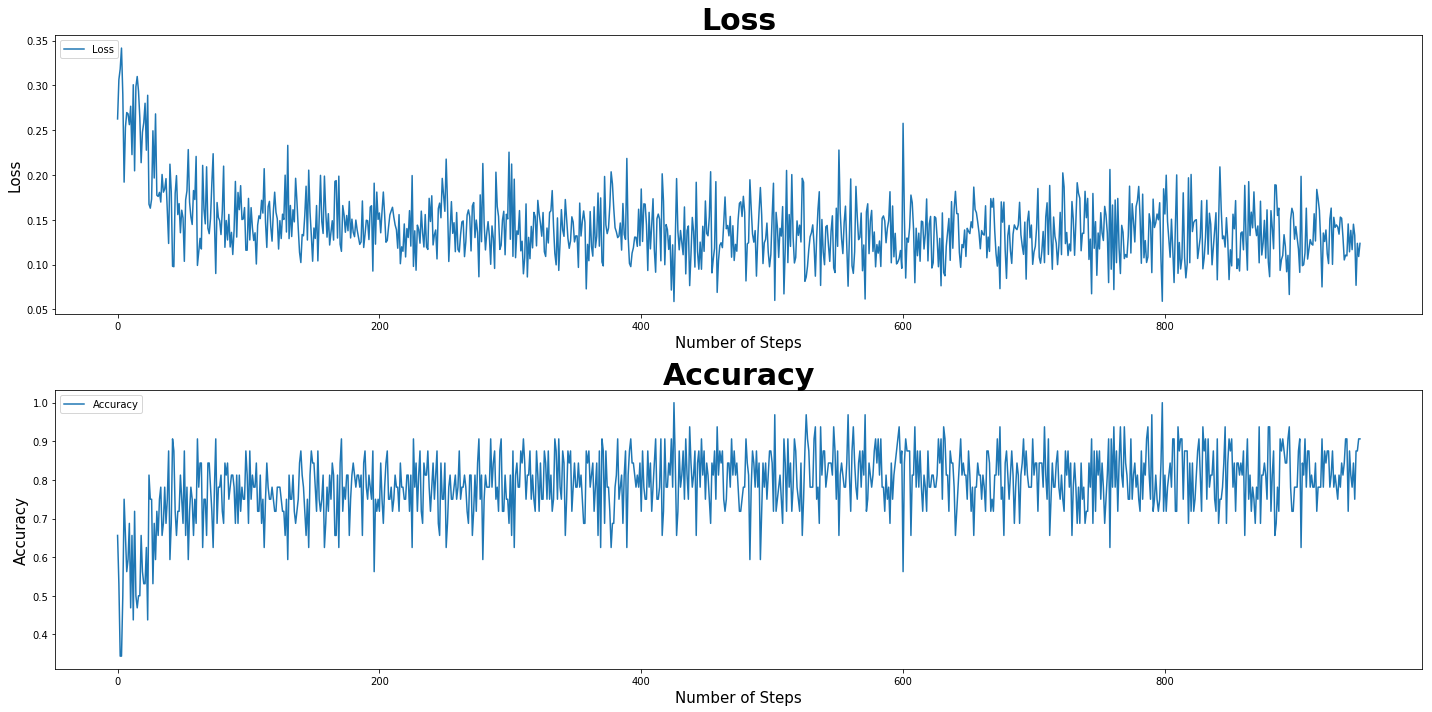

/Users/richard/.virtualenvs/Richard/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


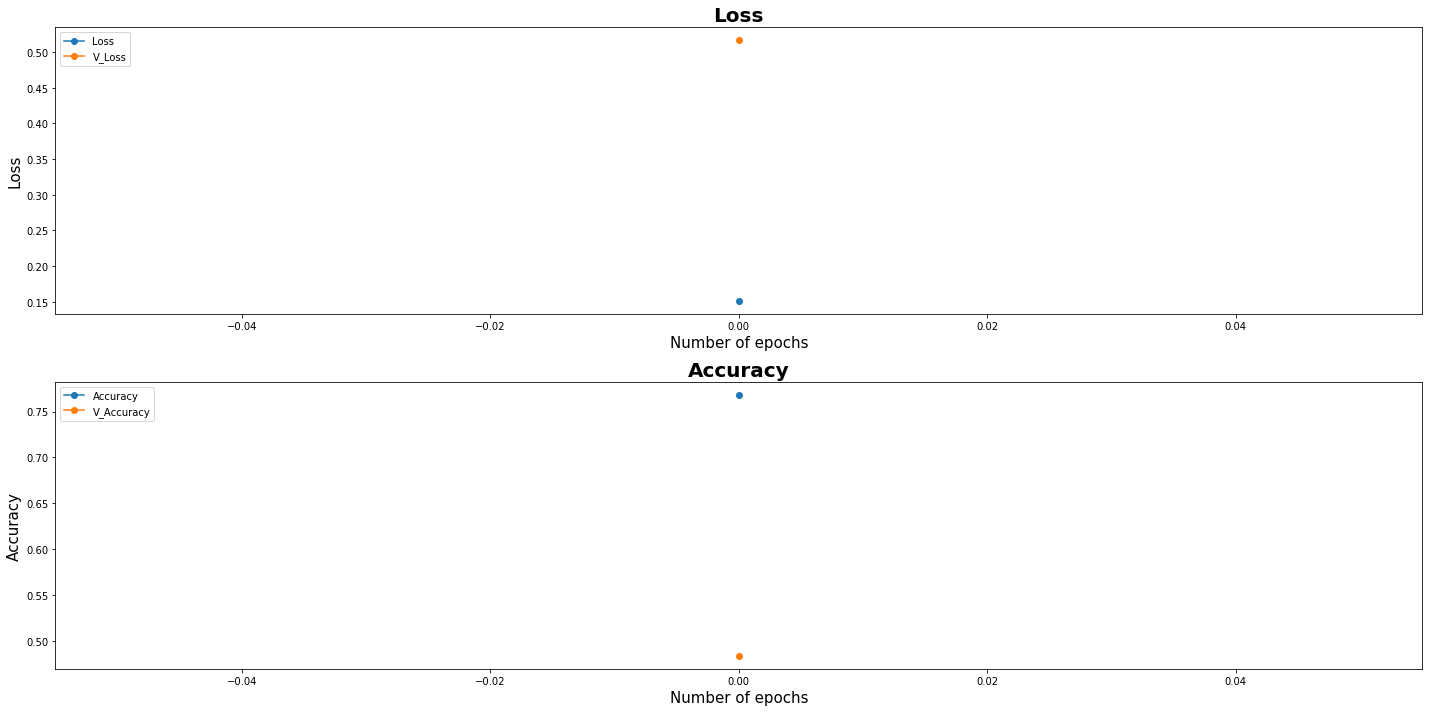

Model Saved
| Epoch [2] | Step [951] | lr [0.000200] | Loss: [0.0965] | Acc: [0.9062] | Time: 0.1s
| Epoch [2] | Step [952] | lr [0.000200] | Loss: [0.1167] | Acc: [0.8750] | Time: 0.1s
| Epoch [2] | Step [953] | lr [0.000200] | Loss: [0.1662] | Acc: [0.7812] | Time: 0.1s
| Epoch [2] | Step [954] | lr [0.000200] | Loss: [0.1140] | Acc: [0.8750] | Time: 0.1s
| Epoch [2] | Step [955] | lr [0.000200] | Loss: [0.1333] | Acc: [0.8125] | Time: 0.1s
| Epoch [2] | Step [956] | lr [0.000200] | Loss: [0.1394] | Acc: [0.7812] | Time: 0.1s
| Epoch [2] | Step [957] | lr [0.000200] | Loss: [0.1213] | Acc: [0.8750] | Time: 0.1s
| Epoch [2] | Step [958] | lr [0.000200] | Loss: [0.1107] | Acc: [0.8750] | Time: 0.1s
| Epoch [2] | Step [959] | lr [0.000200] | Loss: [0.1120] | Acc: [0.8750] | Time: 0.1s
| Epoch [2] | Step [960] | lr [0.000200] | Loss: [0.0836] | Acc: [0.9062] | Time: 0.1s
| Epoch [2] | Step [961] | lr [0.000200] | Loss: [0.1118] | Acc: [0.8750] | Time: 0.1s
| Epoch [2] | Step [962] | lr [

| Epoch [2] | Step [1046] | lr [0.000200] | Loss: [0.1087] | Acc: [0.8438] | Time: 0.1s
| Epoch [2] | Step [1047] | lr [0.000200] | Loss: [0.0837] | Acc: [0.8750] | Time: 0.1s
| Epoch [2] | Step [1048] | lr [0.000200] | Loss: [0.1551] | Acc: [0.7812] | Time: 0.1s
| Epoch [2] | Step [1049] | lr [0.000200] | Loss: [0.1332] | Acc: [0.7812] | Time: 0.1s
| Epoch [2] | Step [1050] | lr [0.000200] | Loss: [0.1371] | Acc: [0.7500] | Time: 0.1s
| Epoch [2] | Step [1051] | lr [0.000200] | Loss: [0.1449] | Acc: [0.8125] | Time: 0.1s
| Epoch [2] | Step [1052] | lr [0.000200] | Loss: [0.1068] | Acc: [0.8750] | Time: 0.1s
| Epoch [2] | Step [1053] | lr [0.000200] | Loss: [0.1508] | Acc: [0.7812] | Time: 0.1s
| Epoch [2] | Step [1054] | lr [0.000200] | Loss: [0.1882] | Acc: [0.6875] | Time: 0.1s
| Epoch [2] | Step [1055] | lr [0.000200] | Loss: [0.1227] | Acc: [0.7812] | Time: 0.1s
| Epoch [2] | Step [1056] | lr [0.000200] | Loss: [0.1441] | Acc: [0.7500] | Time: 0.1s
| Epoch [2] | Step [1057] | lr [

| Epoch [2] | Step [1140] | lr [0.000200] | Loss: [0.1065] | Acc: [0.8438] | Time: 0.1s
| Epoch [2] | Step [1141] | lr [0.000200] | Loss: [0.1515] | Acc: [0.7812] | Time: 0.1s
| Epoch [2] | Step [1142] | lr [0.000200] | Loss: [0.1037] | Acc: [0.9062] | Time: 0.1s
| Epoch [2] | Step [1143] | lr [0.000200] | Loss: [0.1320] | Acc: [0.7812] | Time: 0.1s
| Epoch [2] | Step [1144] | lr [0.000200] | Loss: [0.0814] | Acc: [0.9062] | Time: 0.1s
| Epoch [2] | Step [1145] | lr [0.000200] | Loss: [0.1438] | Acc: [0.8438] | Time: 0.1s
| Epoch [2] | Step [1146] | lr [0.000200] | Loss: [0.2031] | Acc: [0.6875] | Time: 0.1s
| Epoch [2] | Step [1147] | lr [0.000200] | Loss: [0.1456] | Acc: [0.7812] | Time: 0.1s
| Epoch [2] | Step [1148] | lr [0.000200] | Loss: [0.1139] | Acc: [0.8750] | Time: 0.1s
| Epoch [2] | Step [1149] | lr [0.000200] | Loss: [0.1522] | Acc: [0.8438] | Time: 0.1s
| Epoch [2] | Step [1150] | lr [0.000200] | Loss: [0.1247] | Acc: [0.8438] | Time: 0.1s
| Epoch [2] | Step [1151] | lr [

| Epoch [2] | Step [1234] | lr [0.000200] | Loss: [0.1044] | Acc: [0.8438] | Time: 0.1s
| Epoch [2] | Step [1235] | lr [0.000200] | Loss: [0.1540] | Acc: [0.7812] | Time: 0.1s
| Epoch [2] | Step [1236] | lr [0.000200] | Loss: [0.0710] | Acc: [0.9375] | Time: 0.1s
| Epoch [2] | Step [1237] | lr [0.000200] | Loss: [0.1487] | Acc: [0.8438] | Time: 0.1s
| Epoch [2] | Step [1238] | lr [0.000200] | Loss: [0.1468] | Acc: [0.7812] | Time: 0.1s
| Epoch [2] | Step [1239] | lr [0.000200] | Loss: [0.1046] | Acc: [0.8438] | Time: 0.1s
| Epoch [2] | Step [1240] | lr [0.000200] | Loss: [0.1264] | Acc: [0.8750] | Time: 0.1s
| Epoch [2] | Step [1241] | lr [0.000200] | Loss: [0.0898] | Acc: [0.9062] | Time: 0.1s
| Epoch [2] | Step [1242] | lr [0.000200] | Loss: [0.1100] | Acc: [0.8438] | Time: 0.1s
| Epoch [2] | Step [1243] | lr [0.000200] | Loss: [0.1078] | Acc: [0.8125] | Time: 0.1s
| Epoch [2] | Step [1244] | lr [0.000200] | Loss: [0.1565] | Acc: [0.8125] | Time: 0.1s
| Epoch [2] | Step [1245] | lr [

| Epoch [2] | Step [1328] | lr [0.000200] | Loss: [0.0908] | Acc: [0.8438] | Time: 0.1s
| Epoch [2] | Step [1329] | lr [0.000200] | Loss: [0.1586] | Acc: [0.8125] | Time: 0.1s
| Epoch [2] | Step [1330] | lr [0.000200] | Loss: [0.1427] | Acc: [0.7812] | Time: 0.1s
| Epoch [2] | Step [1331] | lr [0.000200] | Loss: [0.1338] | Acc: [0.7188] | Time: 0.1s
| Epoch [2] | Step [1332] | lr [0.000200] | Loss: [0.1317] | Acc: [0.7812] | Time: 0.1s
| Epoch [2] | Step [1333] | lr [0.000200] | Loss: [0.0653] | Acc: [0.9688] | Time: 0.1s
| Epoch [2] | Step [1334] | lr [0.000200] | Loss: [0.1210] | Acc: [0.7500] | Time: 0.1s
| Epoch [2] | Step [1335] | lr [0.000200] | Loss: [0.1207] | Acc: [0.7812] | Time: 0.1s
| Epoch [2] | Step [1336] | lr [0.000200] | Loss: [0.1496] | Acc: [0.8125] | Time: 0.1s
| Epoch [2] | Step [1337] | lr [0.000200] | Loss: [0.1172] | Acc: [0.8438] | Time: 0.1s
| Epoch [2] | Step [1338] | lr [0.000200] | Loss: [0.1020] | Acc: [0.9062] | Time: 0.1s
| Epoch [2] | Step [1339] | lr [

| Epoch [2] | Step [1422] | lr [0.000200] | Loss: [0.1228] | Acc: [0.8438] | Time: 0.1s
| Epoch [2] | Step [1423] | lr [0.000200] | Loss: [0.1273] | Acc: [0.7812] | Time: 0.1s
| Epoch [2] | Step [1424] | lr [0.000200] | Loss: [0.0907] | Acc: [0.9062] | Time: 0.1s
| Epoch [2] | Step [1425] | lr [0.000200] | Loss: [0.1686] | Acc: [0.7500] | Time: 0.1s
| Epoch [2] | Validation | Step [0] |  Loss: [0.4688] | Acc: [0.5312] | Time: 0.0s
| Epoch [2] | Validation | Step [1] |  Loss: [0.5938] | Acc: [0.4062] | Time: 0.0s
| Epoch [2] | Validation | Step [2] |  Loss: [0.4062] | Acc: [0.5938] | Time: 0.0s
| Epoch [2] | Validation | Step [3] |  Loss: [0.4375] | Acc: [0.5625] | Time: 0.0s
| Epoch [2] | Validation | Step [4] |  Loss: [0.4375] | Acc: [0.5625] | Time: 0.0s
| Epoch [2] | Validation | Step [5] |  Loss: [0.4062] | Acc: [0.5938] | Time: 0.0s
| Epoch [2] | Validation | Step [6] |  Loss: [0.4688] | Acc: [0.5312] | Time: 0.0s
| Epoch [2] | Validation | Step [7] |  Loss: [0.6250] | Acc: [0.375

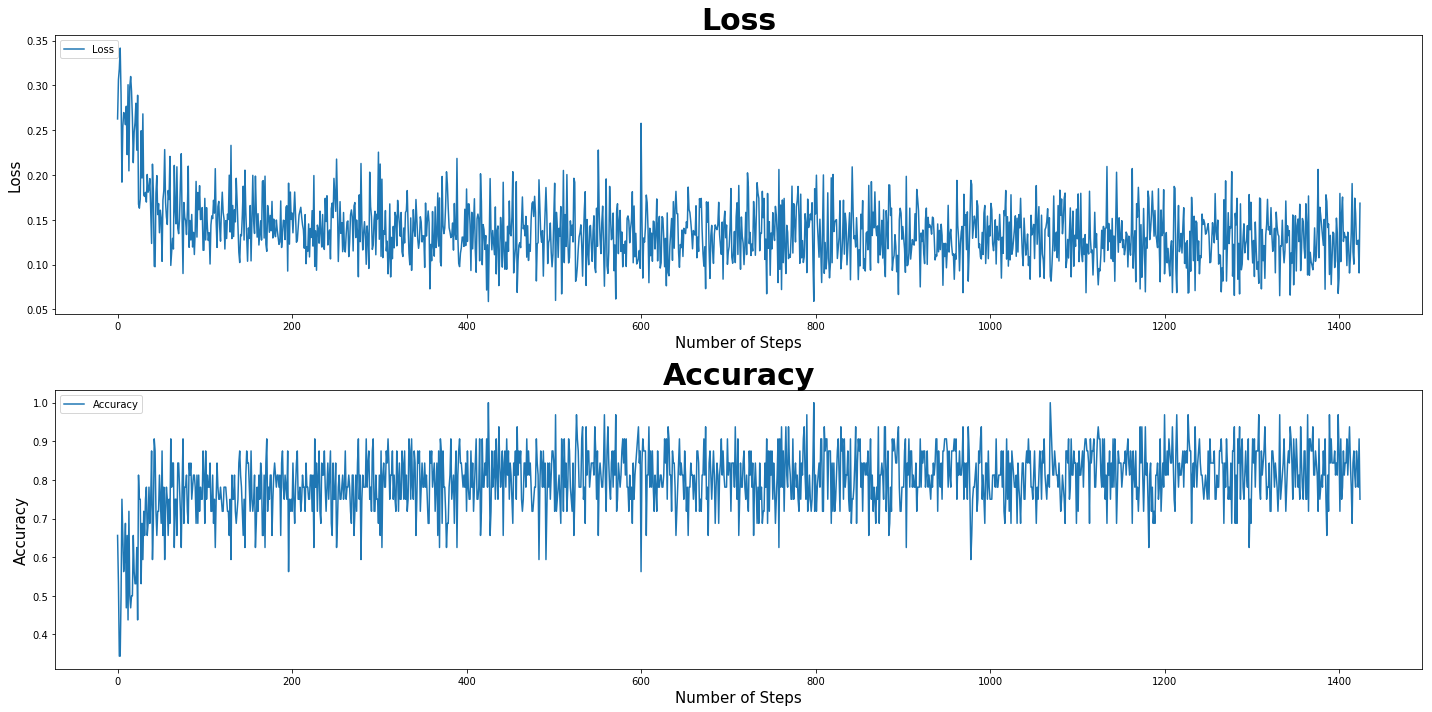

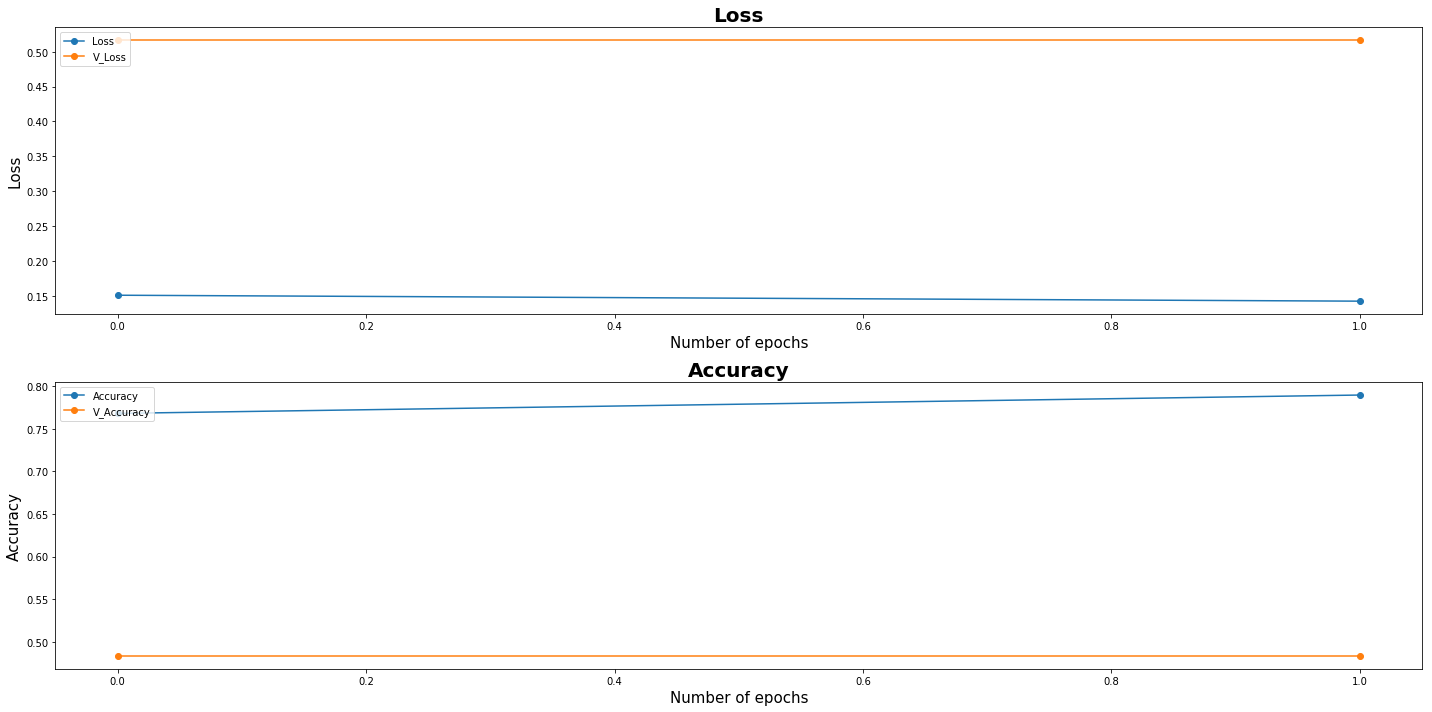

Model Saved
| Epoch [3] | Step [1426] | lr [0.000200] | Loss: [0.1092] | Acc: [0.8125] | Time: 0.1s
| Epoch [3] | Step [1427] | lr [0.000200] | Loss: [0.1352] | Acc: [0.7812] | Time: 0.1s
| Epoch [3] | Step [1428] | lr [0.000200] | Loss: [0.1487] | Acc: [0.8125] | Time: 0.1s
| Epoch [3] | Step [1429] | lr [0.000200] | Loss: [0.1471] | Acc: [0.8438] | Time: 0.1s
| Epoch [3] | Step [1430] | lr [0.000200] | Loss: [0.1507] | Acc: [0.7812] | Time: 0.1s
| Epoch [3] | Step [1431] | lr [0.000200] | Loss: [0.1092] | Acc: [0.8750] | Time: 0.1s
| Epoch [3] | Step [1432] | lr [0.000200] | Loss: [0.1029] | Acc: [0.8750] | Time: 0.1s
| Epoch [3] | Step [1433] | lr [0.000200] | Loss: [0.1367] | Acc: [0.7500] | Time: 0.1s
| Epoch [3] | Step [1434] | lr [0.000200] | Loss: [0.0994] | Acc: [0.8750] | Time: 0.1s
| Epoch [3] | Step [1435] | lr [0.000200] | Loss: [0.1363] | Acc: [0.7812] | Time: 0.1s
| Epoch [3] | Step [1436] | lr [0.000200] | Loss: [0.1276] | Acc: [0.8125] | Time: 0.1s
| Epoch [3] | Step [

| Epoch [3] | Step [1519] | lr [0.000200] | Loss: [0.0854] | Acc: [0.9375] | Time: 0.1s
| Epoch [3] | Step [1520] | lr [0.000200] | Loss: [0.1294] | Acc: [0.7812] | Time: 0.1s
| Epoch [3] | Step [1521] | lr [0.000200] | Loss: [0.1356] | Acc: [0.8125] | Time: 0.1s
| Epoch [3] | Step [1522] | lr [0.000200] | Loss: [0.1371] | Acc: [0.8125] | Time: 0.1s
| Epoch [3] | Step [1523] | lr [0.000200] | Loss: [0.1205] | Acc: [0.8125] | Time: 0.1s
| Epoch [3] | Step [1524] | lr [0.000200] | Loss: [0.1518] | Acc: [0.7812] | Time: 0.1s
| Epoch [3] | Step [1525] | lr [0.000200] | Loss: [0.0954] | Acc: [0.9062] | Time: 0.1s
| Epoch [3] | Step [1526] | lr [0.000200] | Loss: [0.1161] | Acc: [0.8750] | Time: 0.1s
| Epoch [3] | Step [1527] | lr [0.000200] | Loss: [0.1361] | Acc: [0.8438] | Time: 0.1s
| Epoch [3] | Step [1528] | lr [0.000200] | Loss: [0.1483] | Acc: [0.8125] | Time: 0.1s
| Epoch [3] | Step [1529] | lr [0.000200] | Loss: [0.1334] | Acc: [0.8438] | Time: 0.1s
| Epoch [3] | Step [1530] | lr [

| Epoch [3] | Step [1613] | lr [0.000200] | Loss: [0.1383] | Acc: [0.8438] | Time: 0.1s
| Epoch [3] | Step [1614] | lr [0.000200] | Loss: [0.1201] | Acc: [0.8750] | Time: 0.1s
| Epoch [3] | Step [1615] | lr [0.000200] | Loss: [0.0779] | Acc: [0.9062] | Time: 0.1s
| Epoch [3] | Step [1616] | lr [0.000200] | Loss: [0.1695] | Acc: [0.6875] | Time: 0.1s
| Epoch [3] | Step [1617] | lr [0.000200] | Loss: [0.0634] | Acc: [0.9688] | Time: 0.1s
| Epoch [3] | Step [1618] | lr [0.000200] | Loss: [0.1105] | Acc: [0.8750] | Time: 0.1s
| Epoch [3] | Step [1619] | lr [0.000200] | Loss: [0.0726] | Acc: [0.9062] | Time: 0.1s
| Epoch [3] | Step [1620] | lr [0.000200] | Loss: [0.0998] | Acc: [0.9062] | Time: 0.1s
| Epoch [3] | Step [1621] | lr [0.000200] | Loss: [0.1115] | Acc: [0.8750] | Time: 0.1s
| Epoch [3] | Step [1622] | lr [0.000200] | Loss: [0.1544] | Acc: [0.7812] | Time: 0.1s
| Epoch [3] | Step [1623] | lr [0.000200] | Loss: [0.1098] | Acc: [0.8438] | Time: 0.1s
| Epoch [3] | Step [1624] | lr [

| Epoch [3] | Step [1707] | lr [0.000200] | Loss: [0.1537] | Acc: [0.7812] | Time: 0.1s
| Epoch [3] | Step [1708] | lr [0.000200] | Loss: [0.0797] | Acc: [0.9062] | Time: 0.1s
| Epoch [3] | Step [1709] | lr [0.000200] | Loss: [0.1191] | Acc: [0.8750] | Time: 0.1s
| Epoch [3] | Step [1710] | lr [0.000200] | Loss: [0.1174] | Acc: [0.7812] | Time: 0.1s
| Epoch [3] | Step [1711] | lr [0.000200] | Loss: [0.1435] | Acc: [0.7500] | Time: 0.1s
| Epoch [3] | Step [1712] | lr [0.000200] | Loss: [0.1699] | Acc: [0.7500] | Time: 0.1s
| Epoch [3] | Step [1713] | lr [0.000200] | Loss: [0.1445] | Acc: [0.8125] | Time: 0.1s
| Epoch [3] | Step [1714] | lr [0.000200] | Loss: [0.1052] | Acc: [0.8750] | Time: 0.1s
| Epoch [3] | Step [1715] | lr [0.000200] | Loss: [0.1306] | Acc: [0.8125] | Time: 0.1s
| Epoch [3] | Step [1716] | lr [0.000200] | Loss: [0.1043] | Acc: [0.8125] | Time: 0.1s
| Epoch [3] | Step [1717] | lr [0.000200] | Loss: [0.1725] | Acc: [0.7188] | Time: 0.1s
| Epoch [3] | Step [1718] | lr [

| Epoch [3] | Step [1801] | lr [0.000200] | Loss: [0.1374] | Acc: [0.8438] | Time: 0.1s
| Epoch [3] | Step [1802] | lr [0.000200] | Loss: [0.1428] | Acc: [0.6875] | Time: 0.1s
| Epoch [3] | Step [1803] | lr [0.000200] | Loss: [0.1484] | Acc: [0.8125] | Time: 0.1s
| Epoch [3] | Step [1804] | lr [0.000200] | Loss: [0.0960] | Acc: [0.9062] | Time: 0.1s
| Epoch [3] | Step [1805] | lr [0.000200] | Loss: [0.1860] | Acc: [0.7188] | Time: 0.1s
| Epoch [3] | Step [1806] | lr [0.000200] | Loss: [0.1331] | Acc: [0.8438] | Time: 0.1s
| Epoch [3] | Step [1807] | lr [0.000200] | Loss: [0.1306] | Acc: [0.7812] | Time: 0.1s
| Epoch [3] | Step [1808] | lr [0.000200] | Loss: [0.1149] | Acc: [0.8125] | Time: 0.1s
| Epoch [3] | Step [1809] | lr [0.000200] | Loss: [0.1408] | Acc: [0.7812] | Time: 0.1s
| Epoch [3] | Step [1810] | lr [0.000200] | Loss: [0.1747] | Acc: [0.7500] | Time: 0.1s
| Epoch [3] | Step [1811] | lr [0.000200] | Loss: [0.0687] | Acc: [0.9375] | Time: 0.1s
| Epoch [3] | Step [1812] | lr [

| Epoch [3] | Step [1895] | lr [0.000200] | Loss: [0.0946] | Acc: [0.8750] | Time: 0.1s
| Epoch [3] | Step [1896] | lr [0.000200] | Loss: [0.1514] | Acc: [0.7812] | Time: 0.1s
| Epoch [3] | Step [1897] | lr [0.000200] | Loss: [0.1045] | Acc: [0.9062] | Time: 0.1s
| Epoch [3] | Step [1898] | lr [0.000200] | Loss: [0.1521] | Acc: [0.8125] | Time: 0.1s
| Epoch [3] | Step [1899] | lr [0.000200] | Loss: [0.1133] | Acc: [0.9062] | Time: 0.1s
| Epoch [3] | Step [1900] | lr [0.000200] | Loss: [0.1396] | Acc: [0.7500] | Time: 0.1s
| Epoch [3] | Validation | Step [0] |  Loss: [0.5312] | Acc: [0.4688] | Time: 0.0s
| Epoch [3] | Validation | Step [1] |  Loss: [0.3750] | Acc: [0.6250] | Time: 0.0s
| Epoch [3] | Validation | Step [2] |  Loss: [0.4375] | Acc: [0.5625] | Time: 0.0s
| Epoch [3] | Validation | Step [3] |  Loss: [0.5312] | Acc: [0.4688] | Time: 0.0s
| Epoch [3] | Validation | Step [4] |  Loss: [0.6250] | Acc: [0.3750] | Time: 0.0s
| Epoch [3] | Validation | Step [5] |  Loss: [0.4375] | A

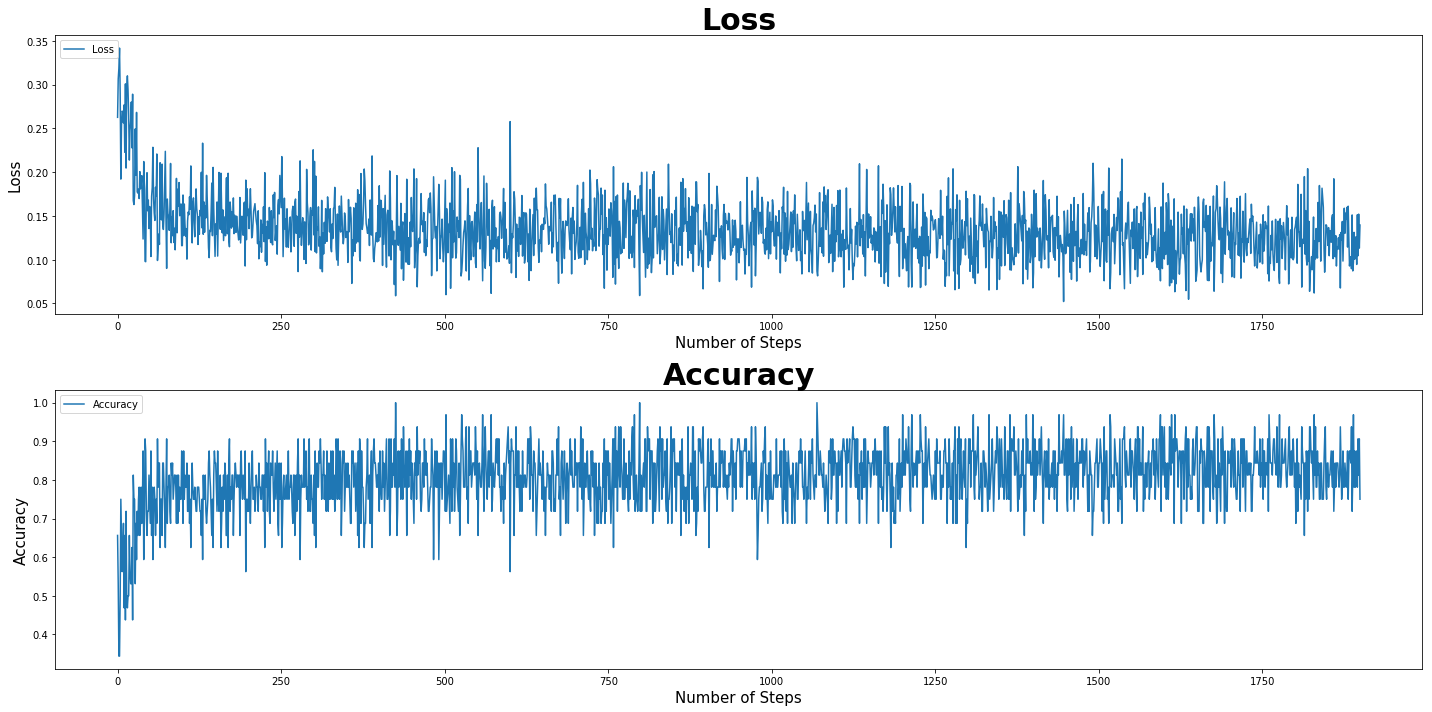

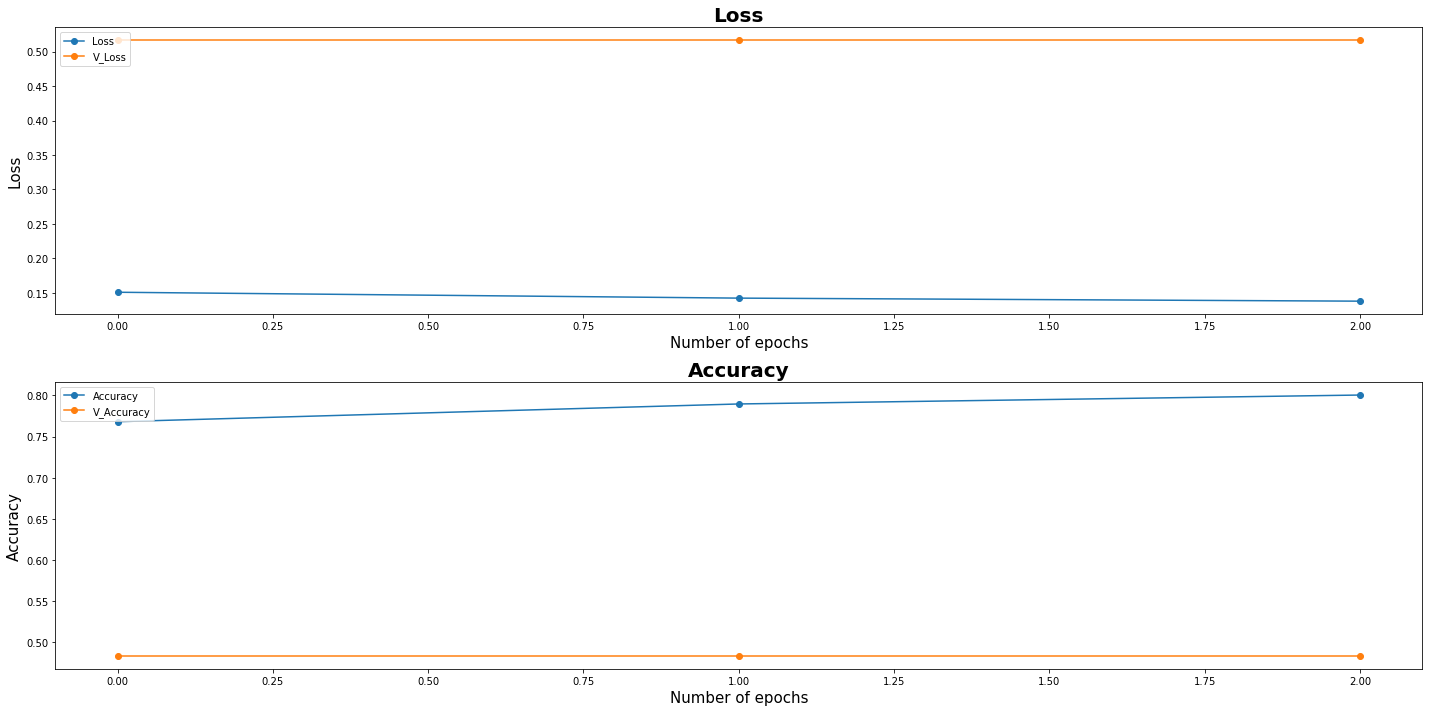

Model Saved
| Epoch [4] | Step [1901] | lr [0.000200] | Loss: [0.1482] | Acc: [0.6875] | Time: 0.1s
| Epoch [4] | Step [1902] | lr [0.000200] | Loss: [0.1277] | Acc: [0.8125] | Time: 0.1s
| Epoch [4] | Step [1903] | lr [0.000200] | Loss: [0.1630] | Acc: [0.7812] | Time: 0.1s
| Epoch [4] | Step [1904] | lr [0.000200] | Loss: [0.0933] | Acc: [0.8750] | Time: 0.1s
| Epoch [4] | Step [1905] | lr [0.000200] | Loss: [0.1297] | Acc: [0.7812] | Time: 0.1s
| Epoch [4] | Step [1906] | lr [0.000200] | Loss: [0.1377] | Acc: [0.8125] | Time: 0.1s
| Epoch [4] | Step [1907] | lr [0.000200] | Loss: [0.1517] | Acc: [0.7188] | Time: 0.1s
| Epoch [4] | Step [1908] | lr [0.000200] | Loss: [0.1060] | Acc: [0.8750] | Time: 0.1s
| Epoch [4] | Step [1909] | lr [0.000200] | Loss: [0.1290] | Acc: [0.7812] | Time: 0.1s
| Epoch [4] | Step [1910] | lr [0.000200] | Loss: [0.1419] | Acc: [0.8438] | Time: 0.1s
| Epoch [4] | Step [1911] | lr [0.000200] | Loss: [0.0904] | Acc: [0.9062] | Time: 0.1s
| Epoch [4] | Step [

| Epoch [4] | Step [1994] | lr [0.000200] | Loss: [0.0757] | Acc: [0.9375] | Time: 0.1s
| Epoch [4] | Step [1995] | lr [0.000200] | Loss: [0.1158] | Acc: [0.8438] | Time: 0.1s
| Epoch [4] | Step [1996] | lr [0.000200] | Loss: [0.1296] | Acc: [0.8125] | Time: 0.1s
| Epoch [4] | Step [1997] | lr [0.000200] | Loss: [0.0826] | Acc: [0.9062] | Time: 0.1s
| Epoch [4] | Step [1998] | lr [0.000200] | Loss: [0.1064] | Acc: [0.8438] | Time: 0.1s
| Epoch [4] | Step [1999] | lr [0.000200] | Loss: [0.1495] | Acc: [0.7188] | Time: 0.1s
| Epoch [4] | Step [2000] | lr [0.000200] | Loss: [0.0863] | Acc: [0.8750] | Time: 0.1s
| Epoch [4] | Step [2001] | lr [0.000200] | Loss: [0.1475] | Acc: [0.8438] | Time: 0.1s
| Epoch [4] | Step [2002] | lr [0.000200] | Loss: [0.1248] | Acc: [0.8125] | Time: 0.1s
| Epoch [4] | Step [2003] | lr [0.000200] | Loss: [0.1285] | Acc: [0.8750] | Time: 0.1s
| Epoch [4] | Step [2004] | lr [0.000200] | Loss: [0.1074] | Acc: [0.8438] | Time: 0.1s
| Epoch [4] | Step [2005] | lr [

| Epoch [4] | Step [2088] | lr [0.000200] | Loss: [0.1192] | Acc: [0.8750] | Time: 0.1s
| Epoch [4] | Step [2089] | lr [0.000200] | Loss: [0.1182] | Acc: [0.8125] | Time: 0.1s
| Epoch [4] | Step [2090] | lr [0.000200] | Loss: [0.1609] | Acc: [0.7812] | Time: 0.1s
| Epoch [4] | Step [2091] | lr [0.000200] | Loss: [0.1379] | Acc: [0.7812] | Time: 0.1s
| Epoch [4] | Step [2092] | lr [0.000200] | Loss: [0.1077] | Acc: [0.8438] | Time: 0.1s
| Epoch [4] | Step [2093] | lr [0.000200] | Loss: [0.1009] | Acc: [0.9062] | Time: 0.1s
| Epoch [4] | Step [2094] | lr [0.000200] | Loss: [0.1372] | Acc: [0.8125] | Time: 0.1s
| Epoch [4] | Step [2095] | lr [0.000200] | Loss: [0.1134] | Acc: [0.8438] | Time: 0.1s
| Epoch [4] | Step [2096] | lr [0.000200] | Loss: [0.1304] | Acc: [0.8125] | Time: 0.1s
| Epoch [4] | Step [2097] | lr [0.000200] | Loss: [0.0985] | Acc: [0.8438] | Time: 0.1s
| Epoch [4] | Step [2098] | lr [0.000200] | Loss: [0.1349] | Acc: [0.8125] | Time: 0.1s
| Epoch [4] | Step [2099] | lr [

| Epoch [4] | Step [2182] | lr [0.000200] | Loss: [0.1375] | Acc: [0.8438] | Time: 0.1s
| Epoch [4] | Step [2183] | lr [0.000200] | Loss: [0.1674] | Acc: [0.7812] | Time: 0.1s
| Epoch [4] | Step [2184] | lr [0.000200] | Loss: [0.1307] | Acc: [0.8438] | Time: 0.1s
| Epoch [4] | Step [2185] | lr [0.000200] | Loss: [0.1411] | Acc: [0.8438] | Time: 0.1s
| Epoch [4] | Step [2186] | lr [0.000200] | Loss: [0.0856] | Acc: [0.9062] | Time: 0.1s
| Epoch [4] | Step [2187] | lr [0.000200] | Loss: [0.1425] | Acc: [0.8750] | Time: 0.1s
| Epoch [4] | Step [2188] | lr [0.000200] | Loss: [0.1549] | Acc: [0.7188] | Time: 0.1s
| Epoch [4] | Step [2189] | lr [0.000200] | Loss: [0.0781] | Acc: [0.9375] | Time: 0.1s
| Epoch [4] | Step [2190] | lr [0.000200] | Loss: [0.1566] | Acc: [0.7500] | Time: 0.1s
| Epoch [4] | Step [2191] | lr [0.000200] | Loss: [0.1615] | Acc: [0.8125] | Time: 0.1s
| Epoch [4] | Step [2192] | lr [0.000200] | Loss: [0.1102] | Acc: [0.9062] | Time: 0.1s
| Epoch [4] | Step [2193] | lr [

| Epoch [4] | Step [2276] | lr [0.000200] | Loss: [0.1127] | Acc: [0.8438] | Time: 0.1s
| Epoch [4] | Step [2277] | lr [0.000200] | Loss: [0.1673] | Acc: [0.8125] | Time: 0.1s
| Epoch [4] | Step [2278] | lr [0.000200] | Loss: [0.1049] | Acc: [0.8438] | Time: 0.1s
| Epoch [4] | Step [2279] | lr [0.000200] | Loss: [0.1034] | Acc: [0.8438] | Time: 0.1s
| Epoch [4] | Step [2280] | lr [0.000200] | Loss: [0.1190] | Acc: [0.7812] | Time: 0.1s
| Epoch [4] | Step [2281] | lr [0.000200] | Loss: [0.1028] | Acc: [0.9062] | Time: 0.1s
| Epoch [4] | Step [2282] | lr [0.000200] | Loss: [0.1318] | Acc: [0.8750] | Time: 0.1s
| Epoch [4] | Step [2283] | lr [0.000200] | Loss: [0.1328] | Acc: [0.9062] | Time: 0.1s
| Epoch [4] | Step [2284] | lr [0.000200] | Loss: [0.0781] | Acc: [0.9375] | Time: 0.1s
| Epoch [4] | Step [2285] | lr [0.000200] | Loss: [0.0972] | Acc: [0.8750] | Time: 0.1s
| Epoch [4] | Step [2286] | lr [0.000200] | Loss: [0.1036] | Acc: [0.8438] | Time: 0.1s
| Epoch [4] | Step [2287] | lr [

| Epoch [4] | Step [2370] | lr [0.000200] | Loss: [0.1098] | Acc: [0.9375] | Time: 0.1s
| Epoch [4] | Step [2371] | lr [0.000200] | Loss: [0.1617] | Acc: [0.6562] | Time: 0.1s
| Epoch [4] | Step [2372] | lr [0.000200] | Loss: [0.1091] | Acc: [0.8438] | Time: 0.1s
| Epoch [4] | Step [2373] | lr [0.000200] | Loss: [0.0966] | Acc: [0.9062] | Time: 0.1s
| Epoch [4] | Step [2374] | lr [0.000200] | Loss: [0.1253] | Acc: [0.8125] | Time: 0.1s
| Epoch [4] | Step [2375] | lr [0.000200] | Loss: [0.1063] | Acc: [0.8750] | Time: 0.1s
| Epoch [4] | Validation | Step [0] |  Loss: [0.5000] | Acc: [0.5000] | Time: 0.0s
| Epoch [4] | Validation | Step [1] |  Loss: [0.5312] | Acc: [0.4688] | Time: 0.0s
| Epoch [4] | Validation | Step [2] |  Loss: [0.5312] | Acc: [0.4688] | Time: 0.0s
| Epoch [4] | Validation | Step [3] |  Loss: [0.3750] | Acc: [0.6250] | Time: 0.0s
| Epoch [4] | Validation | Step [4] |  Loss: [0.4062] | Acc: [0.5938] | Time: 0.0s
| Epoch [4] | Validation | Step [5] |  Loss: [0.5000] | A

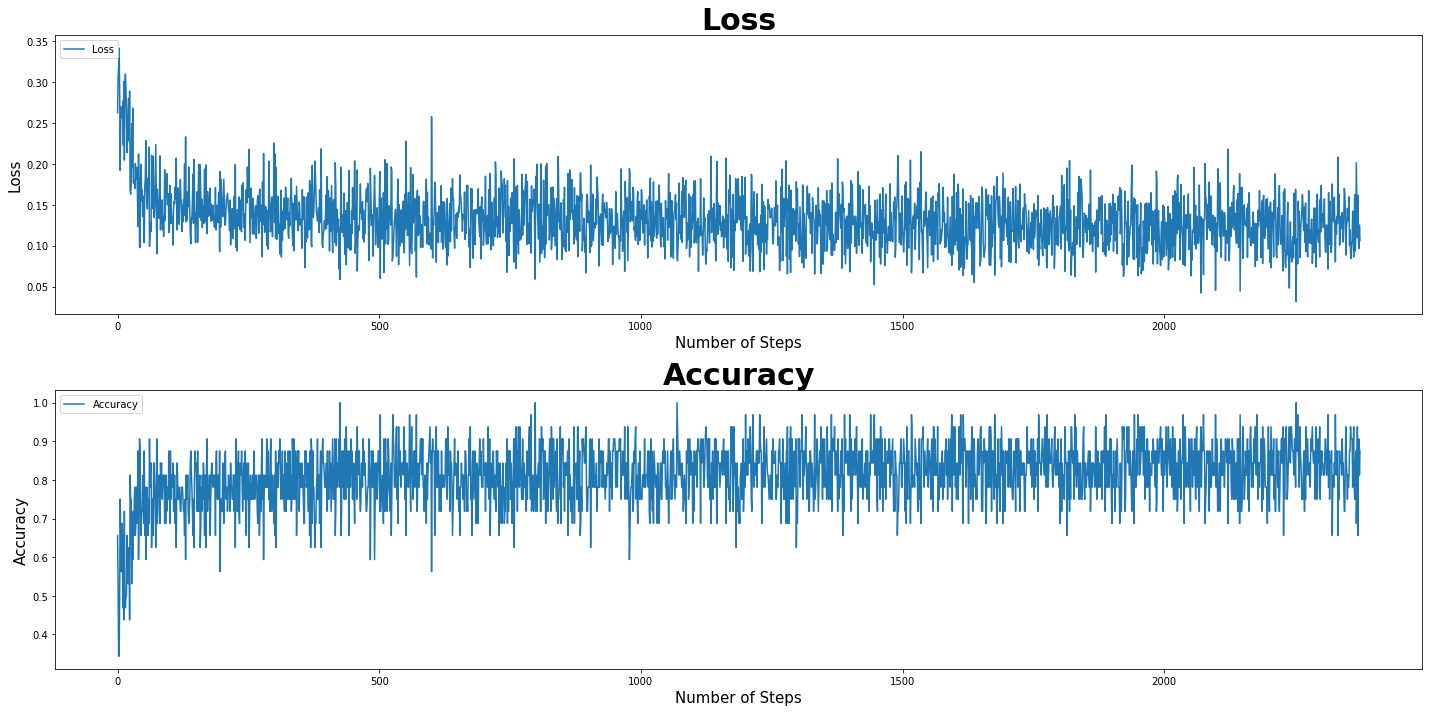

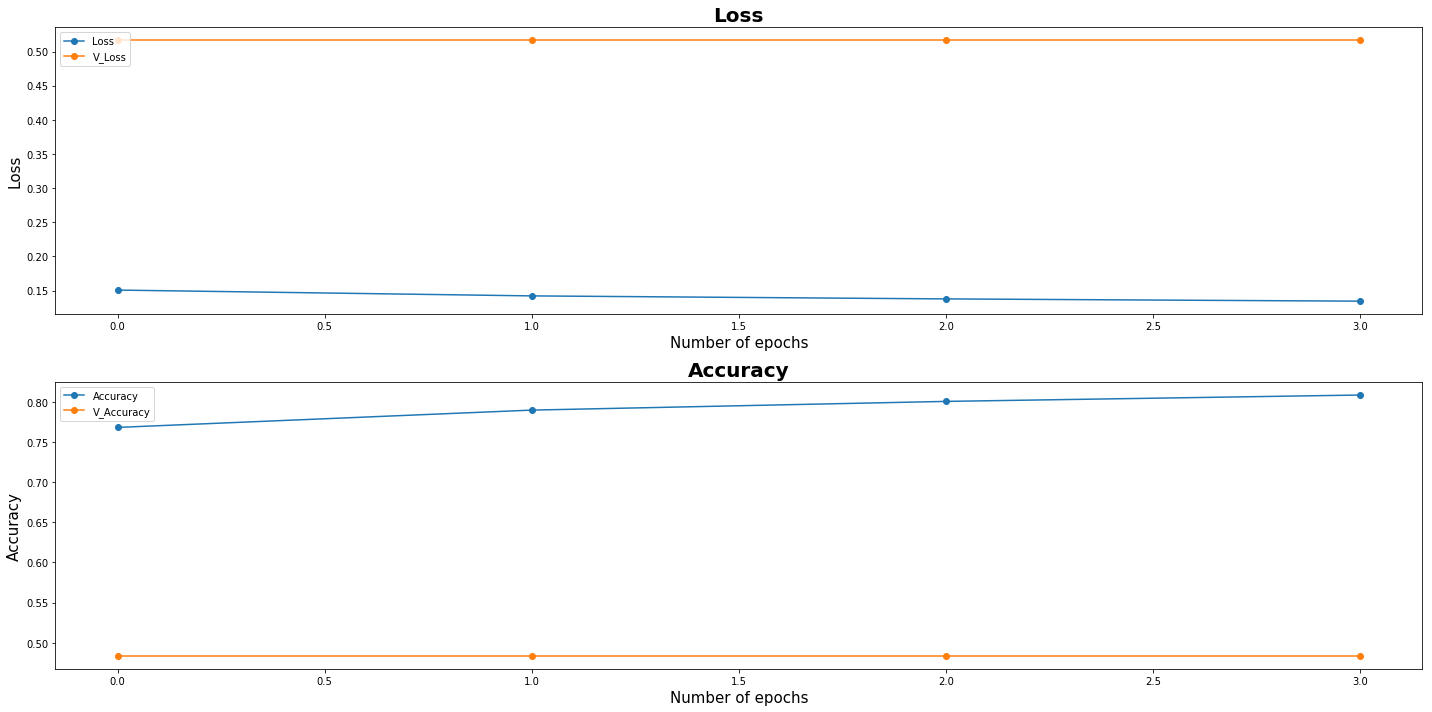

Model Saved
| Epoch [5] | Step [2376] | lr [0.000200] | Loss: [0.1071] | Acc: [0.8750] | Time: 0.1s
| Epoch [5] | Step [2377] | lr [0.000200] | Loss: [0.0757] | Acc: [0.9375] | Time: 0.1s
| Epoch [5] | Step [2378] | lr [0.000200] | Loss: [0.1211] | Acc: [0.8750] | Time: 0.1s
| Epoch [5] | Step [2379] | lr [0.000200] | Loss: [0.1050] | Acc: [0.9062] | Time: 0.1s
| Epoch [5] | Step [2380] | lr [0.000200] | Loss: [0.0723] | Acc: [0.9375] | Time: 0.1s
| Epoch [5] | Step [2381] | lr [0.000200] | Loss: [0.1145] | Acc: [0.8750] | Time: 0.1s
| Epoch [5] | Step [2382] | lr [0.000200] | Loss: [0.1623] | Acc: [0.7812] | Time: 0.1s
| Epoch [5] | Step [2383] | lr [0.000200] | Loss: [0.1177] | Acc: [0.9062] | Time: 0.1s
| Epoch [5] | Step [2384] | lr [0.000200] | Loss: [0.1482] | Acc: [0.7812] | Time: 0.1s
| Epoch [5] | Step [2385] | lr [0.000200] | Loss: [0.1540] | Acc: [0.7812] | Time: 0.1s
| Epoch [5] | Step [2386] | lr [0.000200] | Loss: [0.1270] | Acc: [0.8125] | Time: 0.1s
| Epoch [5] | Step [

| Epoch [5] | Step [2469] | lr [0.000200] | Loss: [0.1271] | Acc: [0.8438] | Time: 0.1s
| Epoch [5] | Step [2470] | lr [0.000200] | Loss: [0.0573] | Acc: [0.9688] | Time: 0.1s
| Epoch [5] | Step [2471] | lr [0.000200] | Loss: [0.0961] | Acc: [0.9062] | Time: 0.1s
| Epoch [5] | Step [2472] | lr [0.000200] | Loss: [0.1097] | Acc: [0.8438] | Time: 0.1s
| Epoch [5] | Step [2473] | lr [0.000200] | Loss: [0.1886] | Acc: [0.6562] | Time: 0.1s
| Epoch [5] | Step [2474] | lr [0.000200] | Loss: [0.1049] | Acc: [0.9062] | Time: 0.1s
| Epoch [5] | Step [2475] | lr [0.000200] | Loss: [0.0852] | Acc: [0.9375] | Time: 0.1s
| Epoch [5] | Step [2476] | lr [0.000200] | Loss: [0.1599] | Acc: [0.8125] | Time: 0.1s
| Epoch [5] | Step [2477] | lr [0.000200] | Loss: [0.1267] | Acc: [0.8125] | Time: 0.1s
| Epoch [5] | Step [2478] | lr [0.000200] | Loss: [0.1151] | Acc: [0.8750] | Time: 0.1s
| Epoch [5] | Step [2479] | lr [0.000200] | Loss: [0.0664] | Acc: [0.9375] | Time: 0.1s
| Epoch [5] | Step [2480] | lr [

| Epoch [5] | Step [2563] | lr [0.000200] | Loss: [0.1440] | Acc: [0.8125] | Time: 0.1s
| Epoch [5] | Step [2564] | lr [0.000200] | Loss: [0.1818] | Acc: [0.6562] | Time: 0.1s
| Epoch [5] | Step [2565] | lr [0.000200] | Loss: [0.1481] | Acc: [0.8438] | Time: 0.1s
| Epoch [5] | Step [2566] | lr [0.000200] | Loss: [0.1849] | Acc: [0.7812] | Time: 0.1s
| Epoch [5] | Step [2567] | lr [0.000200] | Loss: [0.1576] | Acc: [0.8125] | Time: 0.1s
| Epoch [5] | Step [2568] | lr [0.000200] | Loss: [0.1446] | Acc: [0.7812] | Time: 0.1s
| Epoch [5] | Step [2569] | lr [0.000200] | Loss: [0.1235] | Acc: [0.7812] | Time: 0.1s
| Epoch [5] | Step [2570] | lr [0.000200] | Loss: [0.1353] | Acc: [0.8438] | Time: 0.1s
| Epoch [5] | Step [2571] | lr [0.000200] | Loss: [0.1139] | Acc: [0.9062] | Time: 0.1s
| Epoch [5] | Step [2572] | lr [0.000200] | Loss: [0.1466] | Acc: [0.8125] | Time: 0.1s
| Epoch [5] | Step [2573] | lr [0.000200] | Loss: [0.1259] | Acc: [0.8125] | Time: 0.1s
| Epoch [5] | Step [2574] | lr [

| Epoch [5] | Step [2657] | lr [0.000200] | Loss: [0.1145] | Acc: [0.8438] | Time: 0.1s
| Epoch [5] | Step [2658] | lr [0.000200] | Loss: [0.1653] | Acc: [0.7500] | Time: 0.1s
| Epoch [5] | Step [2659] | lr [0.000200] | Loss: [0.1272] | Acc: [0.8438] | Time: 0.1s
| Epoch [5] | Step [2660] | lr [0.000200] | Loss: [0.0634] | Acc: [0.9375] | Time: 0.1s
| Epoch [5] | Step [2661] | lr [0.000200] | Loss: [0.1010] | Acc: [0.8750] | Time: 0.1s
| Epoch [5] | Step [2662] | lr [0.000200] | Loss: [0.1414] | Acc: [0.8125] | Time: 0.1s
| Epoch [5] | Step [2663] | lr [0.000200] | Loss: [0.1737] | Acc: [0.7500] | Time: 0.1s
| Epoch [5] | Step [2664] | lr [0.000200] | Loss: [0.1032] | Acc: [0.9375] | Time: 0.1s
| Epoch [5] | Step [2665] | lr [0.000200] | Loss: [0.1529] | Acc: [0.7500] | Time: 0.1s
| Epoch [5] | Step [2666] | lr [0.000200] | Loss: [0.1540] | Acc: [0.7500] | Time: 0.1s
| Epoch [5] | Step [2667] | lr [0.000200] | Loss: [0.1565] | Acc: [0.7812] | Time: 0.1s
| Epoch [5] | Step [2668] | lr [

| Epoch [5] | Step [2751] | lr [0.000200] | Loss: [0.1346] | Acc: [0.8438] | Time: 0.1s
| Epoch [5] | Step [2752] | lr [0.000200] | Loss: [0.0823] | Acc: [0.9375] | Time: 0.1s
| Epoch [5] | Step [2753] | lr [0.000200] | Loss: [0.1159] | Acc: [0.8750] | Time: 0.1s
| Epoch [5] | Step [2754] | lr [0.000200] | Loss: [0.0867] | Acc: [0.9062] | Time: 0.1s
| Epoch [5] | Step [2755] | lr [0.000200] | Loss: [0.1497] | Acc: [0.7812] | Time: 0.1s
| Epoch [5] | Step [2756] | lr [0.000200] | Loss: [0.1106] | Acc: [0.8438] | Time: 0.1s
| Epoch [5] | Step [2757] | lr [0.000200] | Loss: [0.1349] | Acc: [0.8125] | Time: 0.1s
| Epoch [5] | Step [2758] | lr [0.000200] | Loss: [0.1186] | Acc: [0.8125] | Time: 0.1s
| Epoch [5] | Step [2759] | lr [0.000200] | Loss: [0.1428] | Acc: [0.7812] | Time: 0.1s
| Epoch [5] | Step [2760] | lr [0.000200] | Loss: [0.1060] | Acc: [0.9062] | Time: 0.1s
| Epoch [5] | Step [2761] | lr [0.000200] | Loss: [0.1903] | Acc: [0.7188] | Time: 0.1s
| Epoch [5] | Step [2762] | lr [

| Epoch [5] | Step [2845] | lr [0.000200] | Loss: [0.1353] | Acc: [0.7812] | Time: 0.1s
| Epoch [5] | Step [2846] | lr [0.000200] | Loss: [0.1154] | Acc: [0.8750] | Time: 0.1s
| Epoch [5] | Step [2847] | lr [0.000200] | Loss: [0.1586] | Acc: [0.7812] | Time: 0.1s
| Epoch [5] | Step [2848] | lr [0.000200] | Loss: [0.1723] | Acc: [0.7500] | Time: 0.1s
| Epoch [5] | Step [2849] | lr [0.000200] | Loss: [0.1049] | Acc: [0.8750] | Time: 0.1s
| Epoch [5] | Step [2850] | lr [0.000200] | Loss: [0.1384] | Acc: [0.8125] | Time: 0.1s
| Epoch [5] | Validation | Step [0] |  Loss: [0.5625] | Acc: [0.4375] | Time: 0.0s
| Epoch [5] | Validation | Step [1] |  Loss: [0.5938] | Acc: [0.4062] | Time: 0.0s
| Epoch [5] | Validation | Step [2] |  Loss: [0.5938] | Acc: [0.4062] | Time: 0.0s
| Epoch [5] | Validation | Step [3] |  Loss: [0.5938] | Acc: [0.4062] | Time: 0.0s
| Epoch [5] | Validation | Step [4] |  Loss: [0.4688] | Acc: [0.5312] | Time: 0.0s
| Epoch [5] | Validation | Step [5] |  Loss: [0.6250] | A

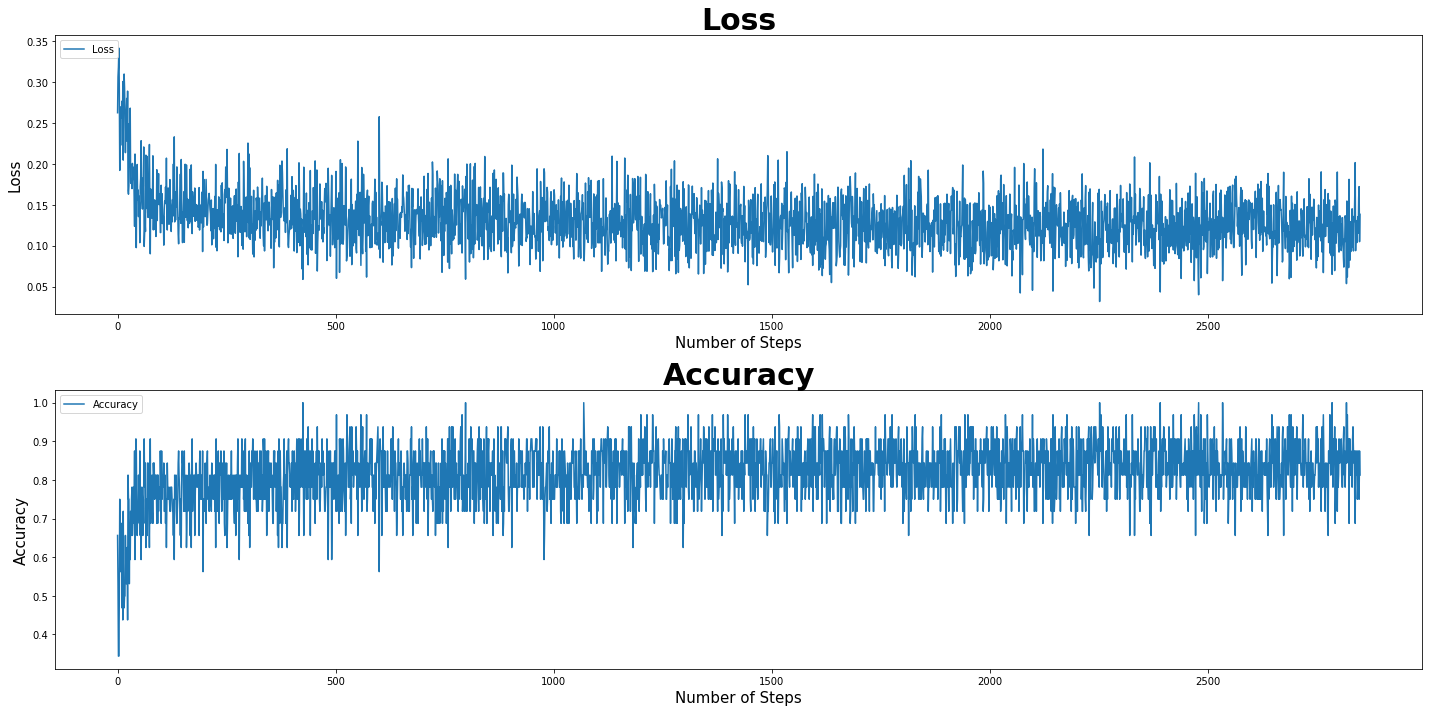

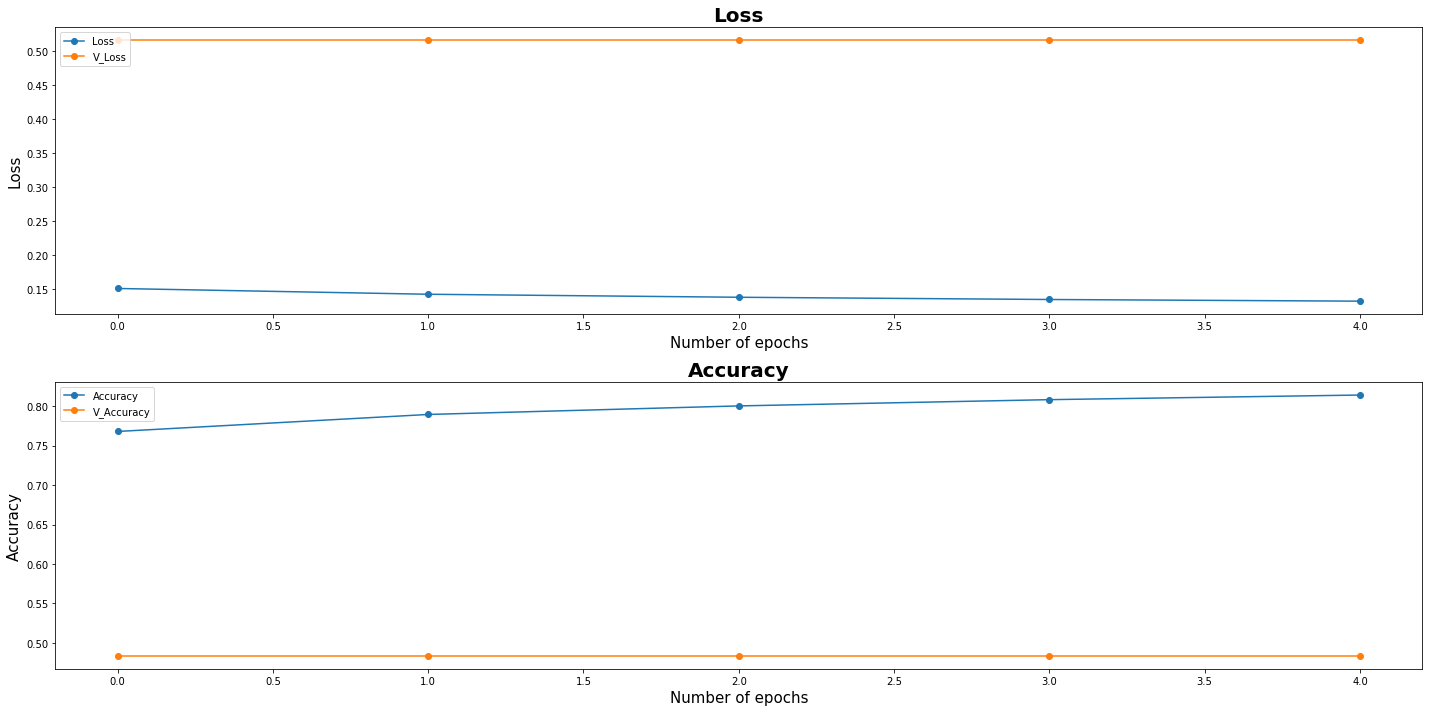

Model Saved
| Epoch [6] | Step [2851] | lr [0.000200] | Loss: [0.0823] | Acc: [0.9062] | Time: 0.1s
| Epoch [6] | Step [2852] | lr [0.000200] | Loss: [0.1930] | Acc: [0.7812] | Time: 0.1s
| Epoch [6] | Step [2853] | lr [0.000200] | Loss: [0.1033] | Acc: [0.8438] | Time: 0.1s
| Epoch [6] | Step [2854] | lr [0.000200] | Loss: [0.1731] | Acc: [0.7500] | Time: 0.1s
| Epoch [6] | Step [2855] | lr [0.000200] | Loss: [0.1466] | Acc: [0.7812] | Time: 0.1s
| Epoch [6] | Step [2856] | lr [0.000200] | Loss: [0.0930] | Acc: [0.8750] | Time: 0.1s
| Epoch [6] | Step [2857] | lr [0.000200] | Loss: [0.1569] | Acc: [0.8125] | Time: 0.1s
| Epoch [6] | Step [2858] | lr [0.000200] | Loss: [0.1049] | Acc: [0.8750] | Time: 0.1s
| Epoch [6] | Step [2859] | lr [0.000200] | Loss: [0.1055] | Acc: [0.9062] | Time: 0.1s
| Epoch [6] | Step [2860] | lr [0.000200] | Loss: [0.1759] | Acc: [0.7188] | Time: 0.1s
| Epoch [6] | Step [2861] | lr [0.000200] | Loss: [0.1383] | Acc: [0.7812] | Time: 0.1s
| Epoch [6] | Step [

| Epoch [6] | Step [2944] | lr [0.000200] | Loss: [0.1287] | Acc: [0.8125] | Time: 0.1s
| Epoch [6] | Step [2945] | lr [0.000200] | Loss: [0.0983] | Acc: [0.9062] | Time: 0.1s
| Epoch [6] | Step [2946] | lr [0.000200] | Loss: [0.1103] | Acc: [0.8438] | Time: 0.1s
| Epoch [6] | Step [2947] | lr [0.000200] | Loss: [0.0863] | Acc: [0.9062] | Time: 0.1s
| Epoch [6] | Step [2948] | lr [0.000200] | Loss: [0.0731] | Acc: [0.9688] | Time: 0.1s
| Epoch [6] | Step [2949] | lr [0.000200] | Loss: [0.1458] | Acc: [0.8125] | Time: 0.1s
| Epoch [6] | Step [2950] | lr [0.000200] | Loss: [0.1562] | Acc: [0.8438] | Time: 0.1s
| Epoch [6] | Step [2951] | lr [0.000200] | Loss: [0.0846] | Acc: [0.9375] | Time: 0.1s
| Epoch [6] | Step [2952] | lr [0.000200] | Loss: [0.0668] | Acc: [0.9688] | Time: 0.1s
| Epoch [6] | Step [2953] | lr [0.000200] | Loss: [0.1547] | Acc: [0.7812] | Time: 0.1s
| Epoch [6] | Step [2954] | lr [0.000200] | Loss: [0.1019] | Acc: [0.9062] | Time: 0.1s
| Epoch [6] | Step [2955] | lr [

| Epoch [6] | Step [3038] | lr [0.000200] | Loss: [0.1267] | Acc: [0.8125] | Time: 0.1s
| Epoch [6] | Step [3039] | lr [0.000200] | Loss: [0.1118] | Acc: [0.8750] | Time: 0.1s
| Epoch [6] | Step [3040] | lr [0.000200] | Loss: [0.1368] | Acc: [0.9062] | Time: 0.1s
| Epoch [6] | Step [3041] | lr [0.000200] | Loss: [0.1566] | Acc: [0.7500] | Time: 0.1s
| Epoch [6] | Step [3042] | lr [0.000200] | Loss: [0.1420] | Acc: [0.8438] | Time: 0.1s
| Epoch [6] | Step [3043] | lr [0.000200] | Loss: [0.1314] | Acc: [0.7812] | Time: 0.1s
| Epoch [6] | Step [3044] | lr [0.000200] | Loss: [0.1906] | Acc: [0.7500] | Time: 0.1s
| Epoch [6] | Step [3045] | lr [0.000200] | Loss: [0.1633] | Acc: [0.7812] | Time: 0.1s
| Epoch [6] | Step [3046] | lr [0.000200] | Loss: [0.1513] | Acc: [0.7500] | Time: 0.1s
| Epoch [6] | Step [3047] | lr [0.000200] | Loss: [0.0831] | Acc: [0.9062] | Time: 0.1s
| Epoch [6] | Step [3048] | lr [0.000200] | Loss: [0.1496] | Acc: [0.8125] | Time: 0.1s
| Epoch [6] | Step [3049] | lr [

| Epoch [6] | Step [3132] | lr [0.000200] | Loss: [0.1533] | Acc: [0.7500] | Time: 0.1s
| Epoch [6] | Step [3133] | lr [0.000200] | Loss: [0.0972] | Acc: [0.8750] | Time: 0.1s
| Epoch [6] | Step [3134] | lr [0.000200] | Loss: [0.0964] | Acc: [0.8750] | Time: 0.1s
| Epoch [6] | Step [3135] | lr [0.000200] | Loss: [0.1214] | Acc: [0.8438] | Time: 0.1s
| Epoch [6] | Step [3136] | lr [0.000200] | Loss: [0.1170] | Acc: [0.8750] | Time: 0.1s
| Epoch [6] | Step [3137] | lr [0.000200] | Loss: [0.1393] | Acc: [0.8125] | Time: 0.1s
| Epoch [6] | Step [3138] | lr [0.000200] | Loss: [0.1211] | Acc: [0.7812] | Time: 0.1s
| Epoch [6] | Step [3139] | lr [0.000200] | Loss: [0.1175] | Acc: [0.8750] | Time: 0.1s
| Epoch [6] | Step [3140] | lr [0.000200] | Loss: [0.1055] | Acc: [0.8750] | Time: 0.1s
| Epoch [6] | Step [3141] | lr [0.000200] | Loss: [0.0936] | Acc: [0.8750] | Time: 0.1s
| Epoch [6] | Step [3142] | lr [0.000200] | Loss: [0.0964] | Acc: [0.9062] | Time: 0.1s
| Epoch [6] | Step [3143] | lr [

| Epoch [6] | Step [3226] | lr [0.000200] | Loss: [0.0926] | Acc: [0.8750] | Time: 0.1s
| Epoch [6] | Step [3227] | lr [0.000200] | Loss: [0.1091] | Acc: [0.9062] | Time: 0.1s
| Epoch [6] | Step [3228] | lr [0.000200] | Loss: [0.0954] | Acc: [0.8750] | Time: 0.2s
| Epoch [6] | Step [3229] | lr [0.000200] | Loss: [0.1514] | Acc: [0.7188] | Time: 0.1s
| Epoch [6] | Step [3230] | lr [0.000200] | Loss: [0.0915] | Acc: [0.8750] | Time: 0.1s
| Epoch [6] | Step [3231] | lr [0.000200] | Loss: [0.1598] | Acc: [0.7812] | Time: 0.1s
| Epoch [6] | Step [3232] | lr [0.000200] | Loss: [0.0914] | Acc: [0.8750] | Time: 0.1s
| Epoch [6] | Step [3233] | lr [0.000200] | Loss: [0.1196] | Acc: [0.9062] | Time: 0.1s
| Epoch [6] | Step [3234] | lr [0.000200] | Loss: [0.1022] | Acc: [0.8438] | Time: 0.1s
| Epoch [6] | Step [3235] | lr [0.000200] | Loss: [0.1570] | Acc: [0.8125] | Time: 0.1s
| Epoch [6] | Step [3236] | lr [0.000200] | Loss: [0.1472] | Acc: [0.7500] | Time: 0.1s
| Epoch [6] | Step [3237] | lr [

| Epoch [6] | Step [3320] | lr [0.000200] | Loss: [0.1482] | Acc: [0.7812] | Time: 0.1s
| Epoch [6] | Step [3321] | lr [0.000200] | Loss: [0.1443] | Acc: [0.8438] | Time: 0.1s
| Epoch [6] | Step [3322] | lr [0.000200] | Loss: [0.1251] | Acc: [0.8125] | Time: 0.1s
| Epoch [6] | Step [3323] | lr [0.000200] | Loss: [0.1174] | Acc: [0.8125] | Time: 0.1s
| Epoch [6] | Step [3324] | lr [0.000200] | Loss: [0.0960] | Acc: [0.9062] | Time: 0.1s
| Epoch [6] | Step [3325] | lr [0.000200] | Loss: [0.0967] | Acc: [0.8750] | Time: 0.1s
| Epoch [6] | Validation | Step [0] |  Loss: [0.5000] | Acc: [0.5000] | Time: 0.0s
| Epoch [6] | Validation | Step [1] |  Loss: [0.5312] | Acc: [0.4688] | Time: 0.0s
| Epoch [6] | Validation | Step [2] |  Loss: [0.4688] | Acc: [0.5312] | Time: 0.0s
| Epoch [6] | Validation | Step [3] |  Loss: [0.4375] | Acc: [0.5625] | Time: 0.0s
| Epoch [6] | Validation | Step [4] |  Loss: [0.5000] | Acc: [0.5000] | Time: 0.0s
| Epoch [6] | Validation | Step [5] |  Loss: [0.4062] | A

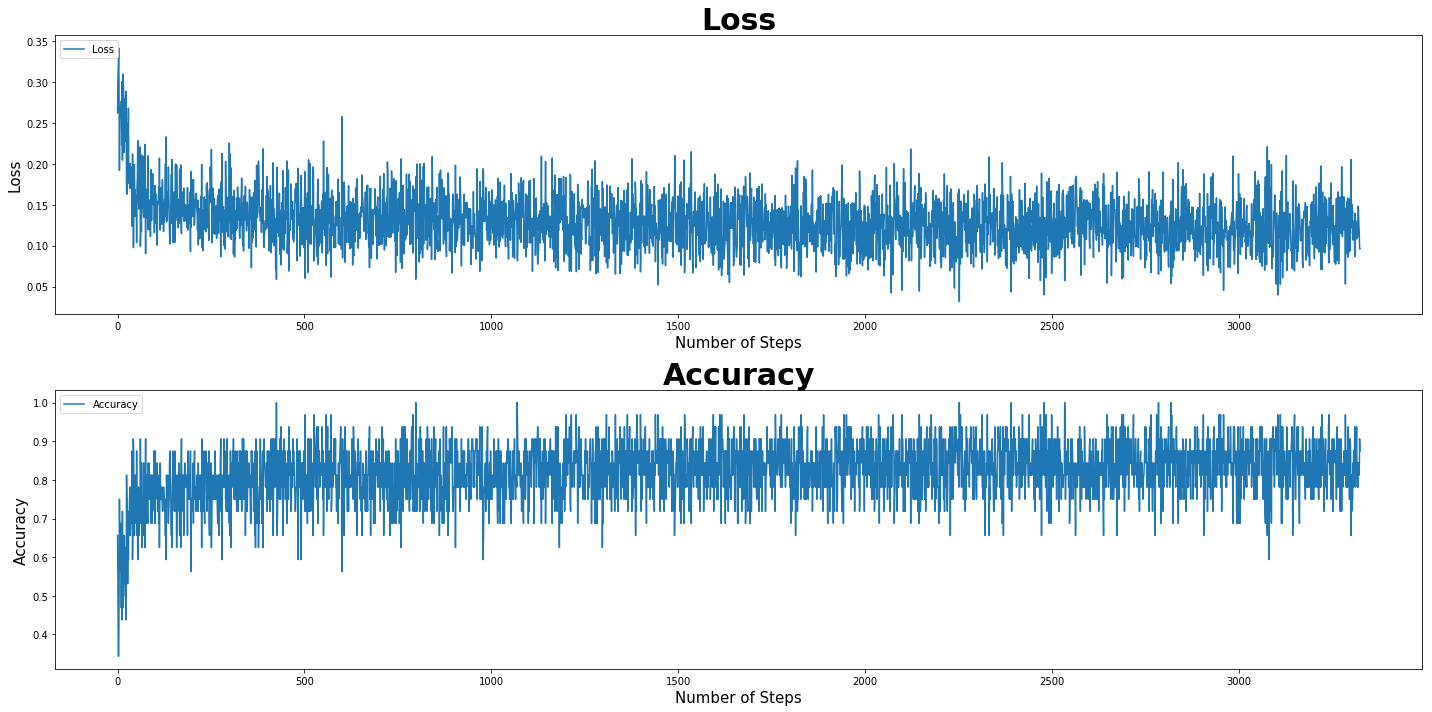

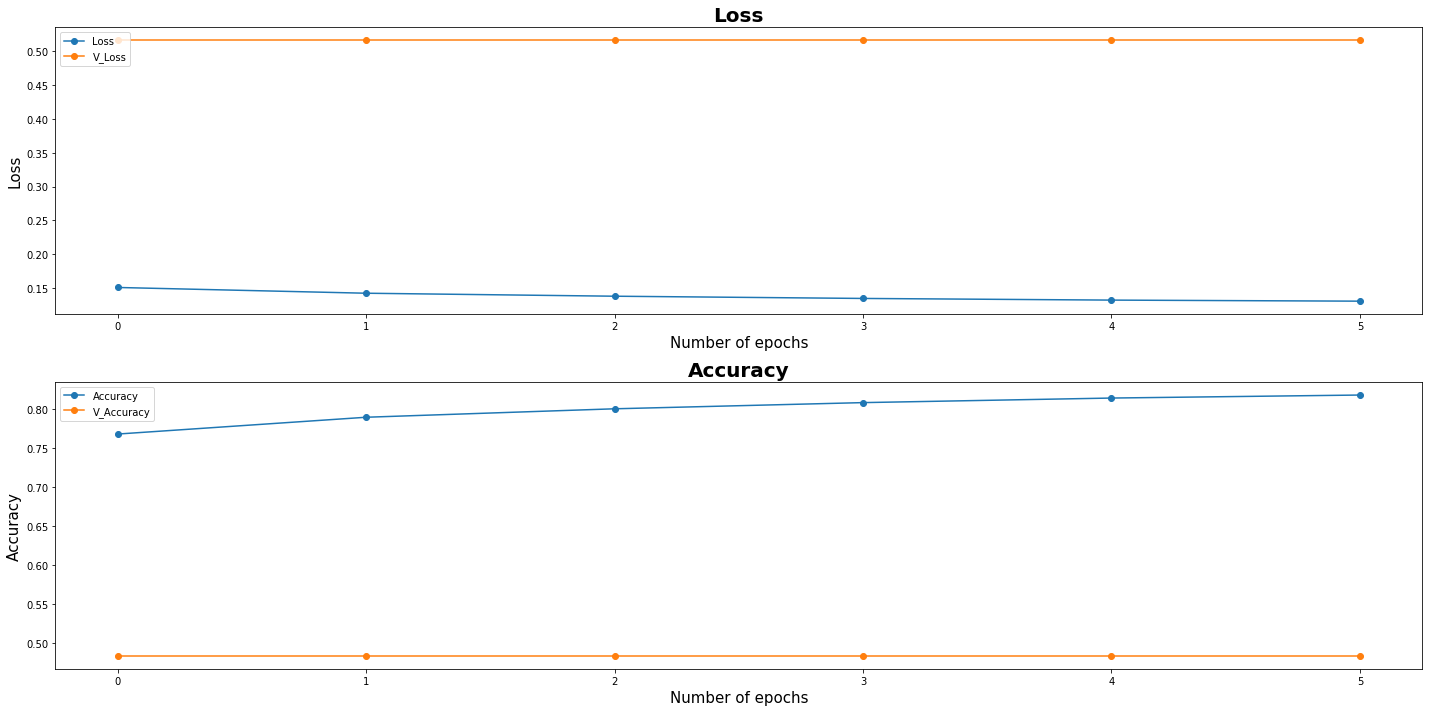

Model Saved
| Epoch [7] | Step [3326] | lr [0.000200] | Loss: [0.0881] | Acc: [0.8438] | Time: 0.1s
| Epoch [7] | Step [3327] | lr [0.000200] | Loss: [0.0950] | Acc: [0.9062] | Time: 0.1s
| Epoch [7] | Step [3328] | lr [0.000200] | Loss: [0.0789] | Acc: [0.9688] | Time: 0.1s
| Epoch [7] | Step [3329] | lr [0.000200] | Loss: [0.0760] | Acc: [0.9375] | Time: 0.1s
| Epoch [7] | Step [3330] | lr [0.000200] | Loss: [0.1044] | Acc: [0.8750] | Time: 0.1s
| Epoch [7] | Step [3331] | lr [0.000200] | Loss: [0.1695] | Acc: [0.7500] | Time: 0.1s
| Epoch [7] | Step [3332] | lr [0.000200] | Loss: [0.1049] | Acc: [0.8750] | Time: 0.1s
| Epoch [7] | Step [3333] | lr [0.000200] | Loss: [0.1560] | Acc: [0.7500] | Time: 0.1s
| Epoch [7] | Step [3334] | lr [0.000200] | Loss: [0.1331] | Acc: [0.9062] | Time: 0.1s
| Epoch [7] | Step [3335] | lr [0.000200] | Loss: [0.1283] | Acc: [0.8125] | Time: 0.1s
| Epoch [7] | Step [3336] | lr [0.000200] | Loss: [0.1341] | Acc: [0.8438] | Time: 0.1s
| Epoch [7] | Step [

| Epoch [7] | Step [3419] | lr [0.000200] | Loss: [0.0822] | Acc: [0.9688] | Time: 0.1s
| Epoch [7] | Step [3420] | lr [0.000200] | Loss: [0.0609] | Acc: [0.9375] | Time: 0.1s
| Epoch [7] | Step [3421] | lr [0.000200] | Loss: [0.1367] | Acc: [0.8125] | Time: 0.1s
| Epoch [7] | Step [3422] | lr [0.000200] | Loss: [0.1395] | Acc: [0.8125] | Time: 0.1s
| Epoch [7] | Step [3423] | lr [0.000200] | Loss: [0.1188] | Acc: [0.8438] | Time: 0.1s
| Epoch [7] | Step [3424] | lr [0.000200] | Loss: [0.1393] | Acc: [0.8125] | Time: 0.1s
| Epoch [7] | Step [3425] | lr [0.000200] | Loss: [0.1069] | Acc: [0.8125] | Time: 0.1s
| Epoch [7] | Step [3426] | lr [0.000200] | Loss: [0.0887] | Acc: [0.8750] | Time: 0.1s
| Epoch [7] | Step [3427] | lr [0.000200] | Loss: [0.0922] | Acc: [0.8750] | Time: 0.1s
| Epoch [7] | Step [3428] | lr [0.000200] | Loss: [0.0716] | Acc: [0.9375] | Time: 0.1s
| Epoch [7] | Step [3429] | lr [0.000200] | Loss: [0.1214] | Acc: [0.9062] | Time: 0.1s
| Epoch [7] | Step [3430] | lr [

| Epoch [7] | Step [3513] | lr [0.000200] | Loss: [0.1361] | Acc: [0.8438] | Time: 0.1s
| Epoch [7] | Step [3514] | lr [0.000200] | Loss: [0.1658] | Acc: [0.6875] | Time: 0.1s
| Epoch [7] | Step [3515] | lr [0.000200] | Loss: [0.1198] | Acc: [0.7812] | Time: 0.1s
| Epoch [7] | Step [3516] | lr [0.000200] | Loss: [0.1087] | Acc: [0.8750] | Time: 0.1s
| Epoch [7] | Step [3517] | lr [0.000200] | Loss: [0.1242] | Acc: [0.8750] | Time: 0.1s
| Epoch [7] | Step [3518] | lr [0.000200] | Loss: [0.0882] | Acc: [0.9062] | Time: 0.1s
| Epoch [7] | Step [3519] | lr [0.000200] | Loss: [0.1119] | Acc: [0.8438] | Time: 0.1s
| Epoch [7] | Step [3520] | lr [0.000200] | Loss: [0.1133] | Acc: [0.8750] | Time: 0.1s
| Epoch [7] | Step [3521] | lr [0.000200] | Loss: [0.0709] | Acc: [0.9375] | Time: 0.1s
| Epoch [7] | Step [3522] | lr [0.000200] | Loss: [0.0792] | Acc: [0.8750] | Time: 0.1s
| Epoch [7] | Step [3523] | lr [0.000200] | Loss: [0.2003] | Acc: [0.6562] | Time: 0.1s
| Epoch [7] | Step [3524] | lr [

| Epoch [7] | Step [3607] | lr [0.000200] | Loss: [0.1011] | Acc: [0.8750] | Time: 0.1s
| Epoch [7] | Step [3608] | lr [0.000200] | Loss: [0.1211] | Acc: [0.8125] | Time: 0.1s
| Epoch [7] | Step [3609] | lr [0.000200] | Loss: [0.1519] | Acc: [0.7500] | Time: 0.1s
| Epoch [7] | Step [3610] | lr [0.000200] | Loss: [0.1472] | Acc: [0.8125] | Time: 0.1s
| Epoch [7] | Step [3611] | lr [0.000200] | Loss: [0.1266] | Acc: [0.8438] | Time: 0.1s
| Epoch [7] | Step [3612] | lr [0.000200] | Loss: [0.1362] | Acc: [0.8750] | Time: 0.1s
| Epoch [7] | Step [3613] | lr [0.000200] | Loss: [0.1490] | Acc: [0.7812] | Time: 0.1s
| Epoch [7] | Step [3614] | lr [0.000200] | Loss: [0.0984] | Acc: [0.9375] | Time: 0.1s
| Epoch [7] | Step [3615] | lr [0.000200] | Loss: [0.0759] | Acc: [0.9375] | Time: 0.1s
| Epoch [7] | Step [3616] | lr [0.000200] | Loss: [0.1654] | Acc: [0.8125] | Time: 0.1s
| Epoch [7] | Step [3617] | lr [0.000200] | Loss: [0.1406] | Acc: [0.7812] | Time: 0.1s
| Epoch [7] | Step [3618] | lr [

| Epoch [7] | Step [3701] | lr [0.000200] | Loss: [0.1020] | Acc: [0.8750] | Time: 0.1s
| Epoch [7] | Step [3702] | lr [0.000200] | Loss: [0.1362] | Acc: [0.8750] | Time: 0.1s
| Epoch [7] | Step [3703] | lr [0.000200] | Loss: [0.1071] | Acc: [0.8750] | Time: 0.1s
| Epoch [7] | Step [3704] | lr [0.000200] | Loss: [0.1505] | Acc: [0.7500] | Time: 0.1s
| Epoch [7] | Step [3705] | lr [0.000200] | Loss: [0.1282] | Acc: [0.8438] | Time: 0.1s
| Epoch [7] | Step [3706] | lr [0.000200] | Loss: [0.1557] | Acc: [0.7500] | Time: 0.1s
| Epoch [7] | Step [3707] | lr [0.000200] | Loss: [0.1386] | Acc: [0.7500] | Time: 0.1s
| Epoch [7] | Step [3708] | lr [0.000200] | Loss: [0.0918] | Acc: [0.9062] | Time: 0.1s
| Epoch [7] | Step [3709] | lr [0.000200] | Loss: [0.1490] | Acc: [0.8125] | Time: 0.1s
| Epoch [7] | Step [3710] | lr [0.000200] | Loss: [0.0873] | Acc: [0.9375] | Time: 0.1s
| Epoch [7] | Step [3711] | lr [0.000200] | Loss: [0.0946] | Acc: [0.8438] | Time: 0.1s
| Epoch [7] | Step [3712] | lr [

| Epoch [7] | Step [3795] | lr [0.000200] | Loss: [0.1519] | Acc: [0.7812] | Time: 0.1s
| Epoch [7] | Step [3796] | lr [0.000200] | Loss: [0.1650] | Acc: [0.7812] | Time: 0.1s
| Epoch [7] | Step [3797] | lr [0.000200] | Loss: [0.1813] | Acc: [0.7500] | Time: 0.1s
| Epoch [7] | Step [3798] | lr [0.000200] | Loss: [0.1494] | Acc: [0.8125] | Time: 0.1s
| Epoch [7] | Step [3799] | lr [0.000200] | Loss: [0.1702] | Acc: [0.7500] | Time: 0.1s
| Epoch [7] | Step [3800] | lr [0.000200] | Loss: [0.1043] | Acc: [0.8750] | Time: 0.1s
| Epoch [7] | Validation | Step [0] |  Loss: [0.5312] | Acc: [0.4688] | Time: 0.0s
| Epoch [7] | Validation | Step [1] |  Loss: [0.4375] | Acc: [0.5625] | Time: 0.0s
| Epoch [7] | Validation | Step [2] |  Loss: [0.5000] | Acc: [0.5000] | Time: 0.0s
| Epoch [7] | Validation | Step [3] |  Loss: [0.4375] | Acc: [0.5625] | Time: 0.0s
| Epoch [7] | Validation | Step [4] |  Loss: [0.4688] | Acc: [0.5312] | Time: 0.0s
| Epoch [7] | Validation | Step [5] |  Loss: [0.5000] | A

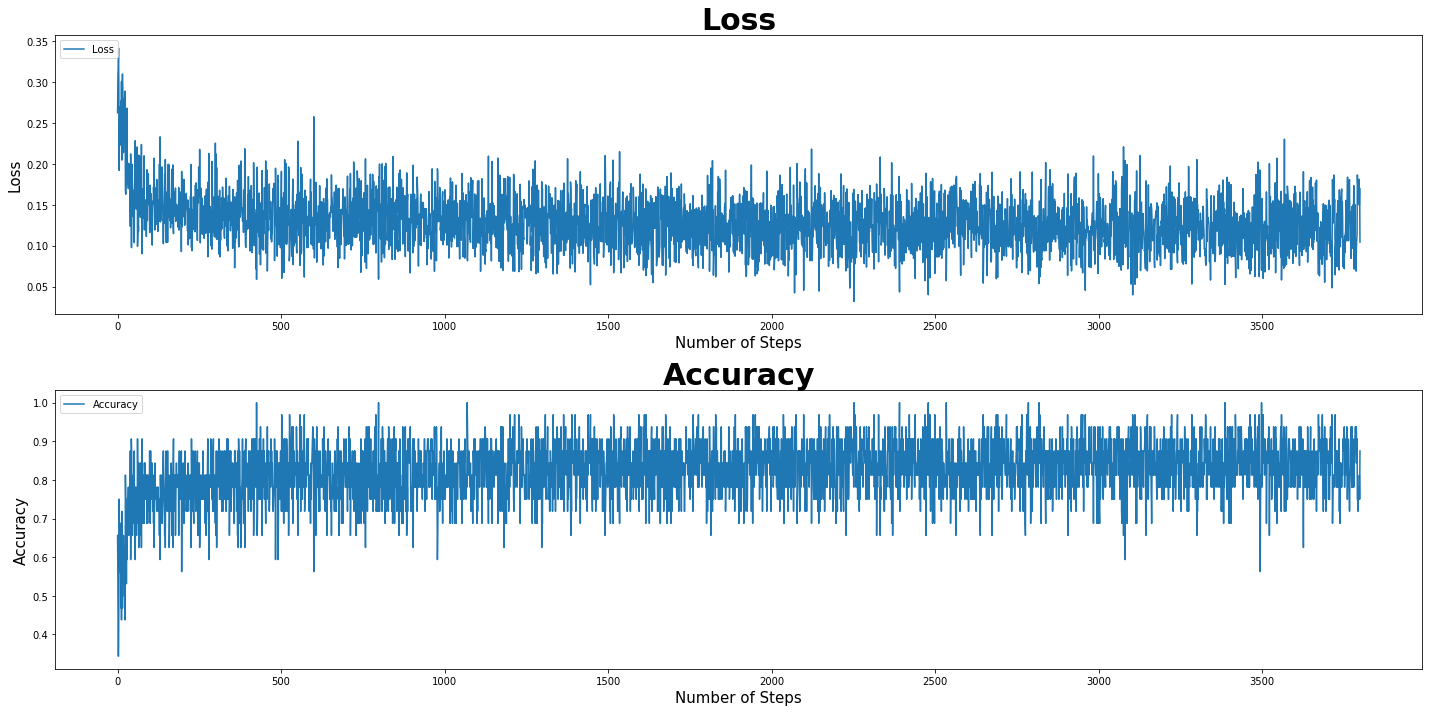

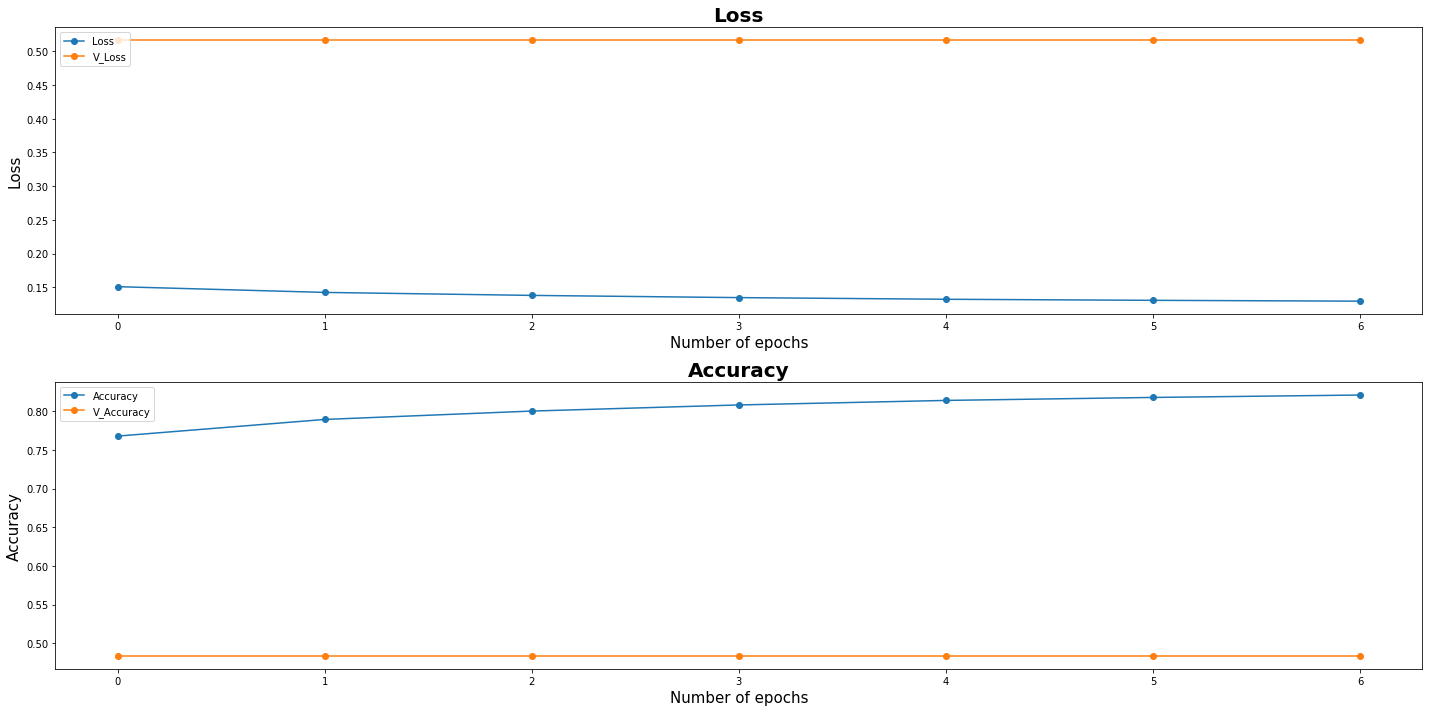

Model Saved
| Epoch [8] | Step [3801] | lr [0.000200] | Loss: [0.1092] | Acc: [0.8438] | Time: 0.1s
| Epoch [8] | Step [3802] | lr [0.000200] | Loss: [0.1758] | Acc: [0.7500] | Time: 0.1s
| Epoch [8] | Step [3803] | lr [0.000200] | Loss: [0.1217] | Acc: [0.8125] | Time: 0.1s
| Epoch [8] | Step [3804] | lr [0.000200] | Loss: [0.1176] | Acc: [0.8438] | Time: 0.1s
| Epoch [8] | Step [3805] | lr [0.000200] | Loss: [0.1174] | Acc: [0.8438] | Time: 0.1s
| Epoch [8] | Step [3806] | lr [0.000200] | Loss: [0.0633] | Acc: [0.9375] | Time: 0.1s
| Epoch [8] | Step [3807] | lr [0.000200] | Loss: [0.1471] | Acc: [0.7500] | Time: 0.1s
| Epoch [8] | Step [3808] | lr [0.000200] | Loss: [0.1019] | Acc: [0.8750] | Time: 0.1s
| Epoch [8] | Step [3809] | lr [0.000200] | Loss: [0.0663] | Acc: [0.9062] | Time: 0.1s
| Epoch [8] | Step [3810] | lr [0.000200] | Loss: [0.1380] | Acc: [0.8125] | Time: 0.1s
| Epoch [8] | Step [3811] | lr [0.000200] | Loss: [0.0901] | Acc: [0.8750] | Time: 0.1s
| Epoch [8] | Step [

| Epoch [8] | Step [3894] | lr [0.000200] | Loss: [0.1166] | Acc: [0.8438] | Time: 0.1s
| Epoch [8] | Step [3895] | lr [0.000200] | Loss: [0.1402] | Acc: [0.8438] | Time: 0.1s
| Epoch [8] | Step [3896] | lr [0.000200] | Loss: [0.1396] | Acc: [0.7812] | Time: 0.1s
| Epoch [8] | Step [3897] | lr [0.000200] | Loss: [0.0944] | Acc: [0.8438] | Time: 0.1s
| Epoch [8] | Step [3898] | lr [0.000200] | Loss: [0.1133] | Acc: [0.8438] | Time: 0.1s
| Epoch [8] | Step [3899] | lr [0.000200] | Loss: [0.0932] | Acc: [0.9062] | Time: 0.1s
| Epoch [8] | Step [3900] | lr [0.000200] | Loss: [0.1495] | Acc: [0.8438] | Time: 0.1s
| Epoch [8] | Step [3901] | lr [0.000200] | Loss: [0.1416] | Acc: [0.8750] | Time: 0.1s
| Epoch [8] | Step [3902] | lr [0.000200] | Loss: [0.1479] | Acc: [0.7812] | Time: 0.1s
| Epoch [8] | Step [3903] | lr [0.000200] | Loss: [0.1050] | Acc: [0.8438] | Time: 0.1s
| Epoch [8] | Step [3904] | lr [0.000200] | Loss: [0.0702] | Acc: [0.9375] | Time: 0.1s
| Epoch [8] | Step [3905] | lr [

| Epoch [8] | Step [3988] | lr [0.000200] | Loss: [0.0500] | Acc: [0.9688] | Time: 0.1s
| Epoch [8] | Step [3989] | lr [0.000200] | Loss: [0.1203] | Acc: [0.8438] | Time: 0.1s
| Epoch [8] | Step [3990] | lr [0.000200] | Loss: [0.1465] | Acc: [0.7500] | Time: 0.1s
| Epoch [8] | Step [3991] | lr [0.000200] | Loss: [0.1261] | Acc: [0.8125] | Time: 0.1s
| Epoch [8] | Step [3992] | lr [0.000200] | Loss: [0.1005] | Acc: [0.8438] | Time: 0.1s
| Epoch [8] | Step [3993] | lr [0.000200] | Loss: [0.1121] | Acc: [0.8438] | Time: 0.1s
| Epoch [8] | Step [3994] | lr [0.000200] | Loss: [0.0830] | Acc: [0.9062] | Time: 0.1s
| Epoch [8] | Step [3995] | lr [0.000200] | Loss: [0.1582] | Acc: [0.7500] | Time: 0.1s
| Epoch [8] | Step [3996] | lr [0.000200] | Loss: [0.1336] | Acc: [0.8125] | Time: 0.1s
| Epoch [8] | Step [3997] | lr [0.000200] | Loss: [0.1469] | Acc: [0.8438] | Time: 0.1s
| Epoch [8] | Step [3998] | lr [0.000200] | Loss: [0.1443] | Acc: [0.8125] | Time: 0.1s
| Epoch [8] | Step [3999] | lr [

| Epoch [8] | Step [4082] | lr [0.000200] | Loss: [0.1019] | Acc: [0.8750] | Time: 0.1s
| Epoch [8] | Step [4083] | lr [0.000200] | Loss: [0.1333] | Acc: [0.8438] | Time: 0.1s
| Epoch [8] | Step [4084] | lr [0.000200] | Loss: [0.1071] | Acc: [0.9062] | Time: 0.1s
| Epoch [8] | Step [4085] | lr [0.000200] | Loss: [0.1565] | Acc: [0.8125] | Time: 0.1s
| Epoch [8] | Step [4086] | lr [0.000200] | Loss: [0.1368] | Acc: [0.8125] | Time: 0.1s
| Epoch [8] | Step [4087] | lr [0.000200] | Loss: [0.1613] | Acc: [0.7500] | Time: 0.1s
| Epoch [8] | Step [4088] | lr [0.000200] | Loss: [0.0784] | Acc: [0.9062] | Time: 0.1s
| Epoch [8] | Step [4089] | lr [0.000200] | Loss: [0.0922] | Acc: [0.8438] | Time: 0.1s
| Epoch [8] | Step [4090] | lr [0.000200] | Loss: [0.1381] | Acc: [0.7812] | Time: 0.1s
| Epoch [8] | Step [4091] | lr [0.000200] | Loss: [0.1311] | Acc: [0.7500] | Time: 0.1s
| Epoch [8] | Step [4092] | lr [0.000200] | Loss: [0.1695] | Acc: [0.7500] | Time: 0.1s
| Epoch [8] | Step [4093] | lr [

| Epoch [8] | Step [4176] | lr [0.000200] | Loss: [0.1169] | Acc: [0.9062] | Time: 0.1s
| Epoch [8] | Step [4177] | lr [0.000200] | Loss: [0.1308] | Acc: [0.8750] | Time: 0.1s
| Epoch [8] | Step [4178] | lr [0.000200] | Loss: [0.0791] | Acc: [0.8750] | Time: 0.1s
| Epoch [8] | Step [4179] | lr [0.000200] | Loss: [0.1009] | Acc: [0.8750] | Time: 0.1s
| Epoch [8] | Step [4180] | lr [0.000200] | Loss: [0.1226] | Acc: [0.8438] | Time: 0.1s
| Epoch [8] | Step [4181] | lr [0.000200] | Loss: [0.0696] | Acc: [0.9062] | Time: 0.1s
| Epoch [8] | Step [4182] | lr [0.000200] | Loss: [0.0603] | Acc: [0.9688] | Time: 0.1s
| Epoch [8] | Step [4183] | lr [0.000200] | Loss: [0.0896] | Acc: [0.9375] | Time: 0.1s
| Epoch [8] | Step [4184] | lr [0.000200] | Loss: [0.0922] | Acc: [0.8750] | Time: 0.1s
| Epoch [8] | Step [4185] | lr [0.000200] | Loss: [0.1602] | Acc: [0.7500] | Time: 0.1s
| Epoch [8] | Step [4186] | lr [0.000200] | Loss: [0.1665] | Acc: [0.7188] | Time: 0.1s
| Epoch [8] | Step [4187] | lr [

| Epoch [8] | Step [4270] | lr [0.000200] | Loss: [0.1244] | Acc: [0.8125] | Time: 0.1s
| Epoch [8] | Step [4271] | lr [0.000200] | Loss: [0.1194] | Acc: [0.8750] | Time: 0.1s
| Epoch [8] | Step [4272] | lr [0.000200] | Loss: [0.1356] | Acc: [0.8125] | Time: 0.1s
| Epoch [8] | Step [4273] | lr [0.000200] | Loss: [0.1111] | Acc: [0.8438] | Time: 0.1s
| Epoch [8] | Step [4274] | lr [0.000200] | Loss: [0.0731] | Acc: [0.8750] | Time: 0.1s
| Epoch [8] | Step [4275] | lr [0.000200] | Loss: [0.1119] | Acc: [0.9062] | Time: 0.1s
| Epoch [8] | Validation | Step [0] |  Loss: [0.6250] | Acc: [0.3750] | Time: 0.0s
| Epoch [8] | Validation | Step [1] |  Loss: [0.3438] | Acc: [0.6562] | Time: 0.0s
| Epoch [8] | Validation | Step [2] |  Loss: [0.4062] | Acc: [0.5938] | Time: 0.0s
| Epoch [8] | Validation | Step [3] |  Loss: [0.5000] | Acc: [0.5000] | Time: 0.0s
| Epoch [8] | Validation | Step [4] |  Loss: [0.5312] | Acc: [0.4688] | Time: 0.0s
| Epoch [8] | Validation | Step [5] |  Loss: [0.2812] | A

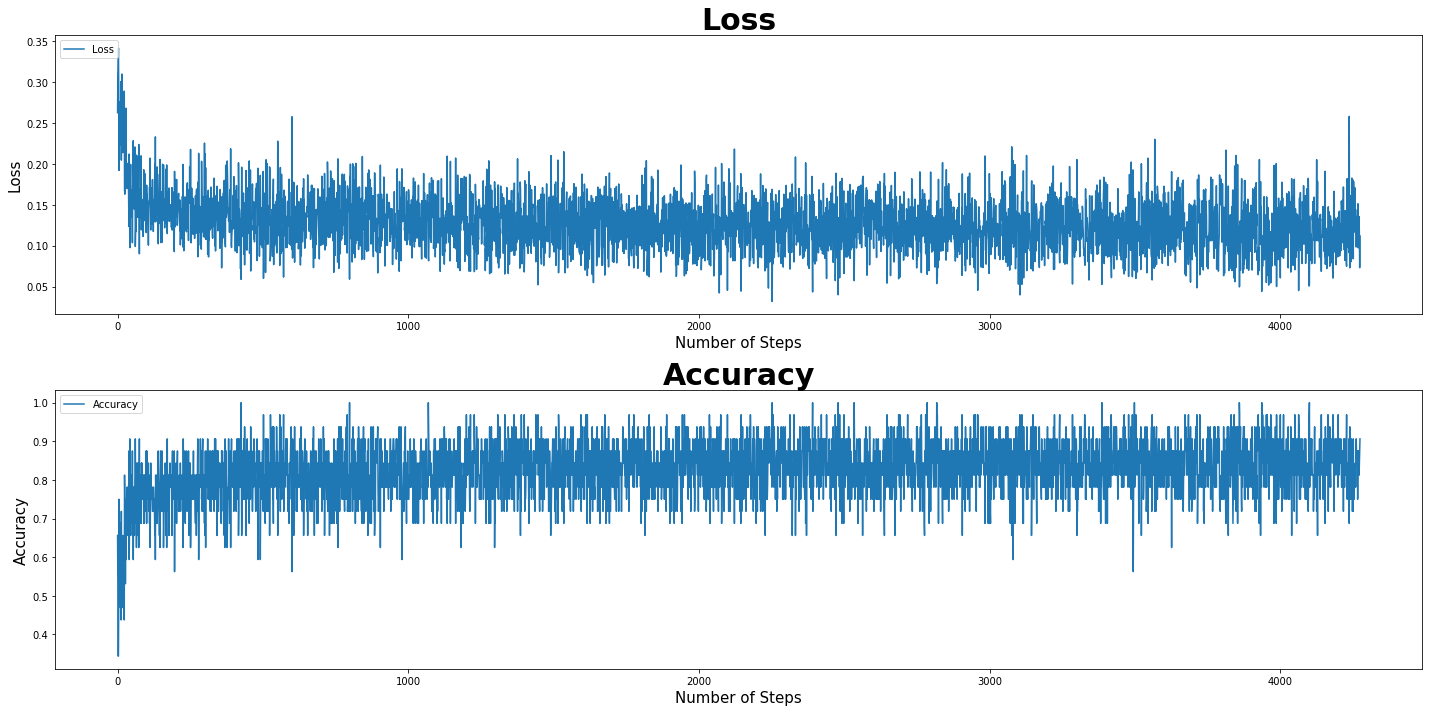

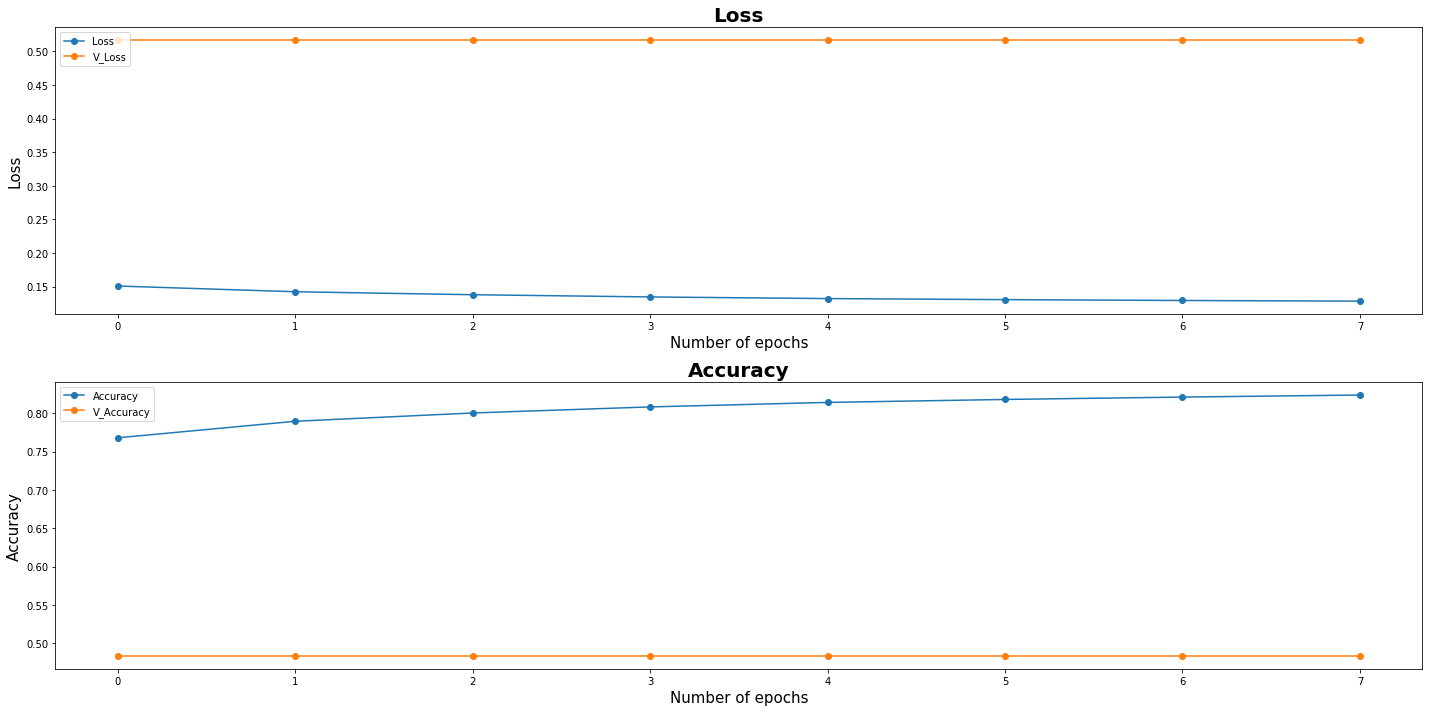

Model Saved
| Epoch [9] | Step [4276] | lr [0.000200] | Loss: [0.0980] | Acc: [0.9062] | Time: 0.1s
| Epoch [9] | Step [4277] | lr [0.000200] | Loss: [0.1100] | Acc: [0.8438] | Time: 0.1s
| Epoch [9] | Step [4278] | lr [0.000200] | Loss: [0.1254] | Acc: [0.8438] | Time: 0.1s
| Epoch [9] | Step [4279] | lr [0.000200] | Loss: [0.1586] | Acc: [0.7812] | Time: 0.1s
| Epoch [9] | Step [4280] | lr [0.000200] | Loss: [0.1370] | Acc: [0.8438] | Time: 0.1s
| Epoch [9] | Step [4281] | lr [0.000200] | Loss: [0.1393] | Acc: [0.7812] | Time: 0.1s
| Epoch [9] | Step [4282] | lr [0.000200] | Loss: [0.0890] | Acc: [0.8750] | Time: 0.1s
| Epoch [9] | Step [4283] | lr [0.000200] | Loss: [0.1193] | Acc: [0.8750] | Time: 0.1s
| Epoch [9] | Step [4284] | lr [0.000200] | Loss: [0.1162] | Acc: [0.8438] | Time: 0.1s
| Epoch [9] | Step [4285] | lr [0.000200] | Loss: [0.0608] | Acc: [0.9688] | Time: 0.1s
| Epoch [9] | Step [4286] | lr [0.000200] | Loss: [0.0810] | Acc: [0.9062] | Time: 0.1s
| Epoch [9] | Step [

| Epoch [9] | Step [4369] | lr [0.000200] | Loss: [0.0784] | Acc: [0.8750] | Time: 0.1s
| Epoch [9] | Step [4370] | lr [0.000200] | Loss: [0.1311] | Acc: [0.8438] | Time: 0.1s
| Epoch [9] | Step [4371] | lr [0.000200] | Loss: [0.0823] | Acc: [0.8750] | Time: 0.1s
| Epoch [9] | Step [4372] | lr [0.000200] | Loss: [0.1313] | Acc: [0.8438] | Time: 0.1s
| Epoch [9] | Step [4373] | lr [0.000200] | Loss: [0.0861] | Acc: [0.9062] | Time: 0.1s
| Epoch [9] | Step [4374] | lr [0.000200] | Loss: [0.1642] | Acc: [0.8125] | Time: 0.1s
| Epoch [9] | Step [4375] | lr [0.000200] | Loss: [0.1013] | Acc: [0.9375] | Time: 0.1s
| Epoch [9] | Step [4376] | lr [0.000200] | Loss: [0.1564] | Acc: [0.7812] | Time: 0.1s
| Epoch [9] | Step [4377] | lr [0.000200] | Loss: [0.1162] | Acc: [0.8125] | Time: 0.1s
| Epoch [9] | Step [4378] | lr [0.000200] | Loss: [0.0877] | Acc: [0.9375] | Time: 0.1s
| Epoch [9] | Step [4379] | lr [0.000200] | Loss: [0.1365] | Acc: [0.7188] | Time: 0.1s
| Epoch [9] | Step [4380] | lr [

| Epoch [9] | Step [4463] | lr [0.000200] | Loss: [0.1132] | Acc: [0.8750] | Time: 0.1s
| Epoch [9] | Step [4464] | lr [0.000200] | Loss: [0.1225] | Acc: [0.8125] | Time: 0.1s
| Epoch [9] | Step [4465] | lr [0.000200] | Loss: [0.1100] | Acc: [0.8750] | Time: 0.1s
| Epoch [9] | Step [4466] | lr [0.000200] | Loss: [0.1303] | Acc: [0.8750] | Time: 0.1s
| Epoch [9] | Step [4467] | lr [0.000200] | Loss: [0.1110] | Acc: [0.9062] | Time: 0.1s
| Epoch [9] | Step [4468] | lr [0.000200] | Loss: [0.0920] | Acc: [0.8750] | Time: 0.1s
| Epoch [9] | Step [4469] | lr [0.000200] | Loss: [0.1223] | Acc: [0.8750] | Time: 0.1s
| Epoch [9] | Step [4470] | lr [0.000200] | Loss: [0.1271] | Acc: [0.8125] | Time: 0.1s
| Epoch [9] | Step [4471] | lr [0.000200] | Loss: [0.1294] | Acc: [0.8750] | Time: 0.1s
| Epoch [9] | Step [4472] | lr [0.000200] | Loss: [0.0950] | Acc: [0.8750] | Time: 0.1s
| Epoch [9] | Step [4473] | lr [0.000200] | Loss: [0.1096] | Acc: [0.8438] | Time: 0.1s
| Epoch [9] | Step [4474] | lr [

| Epoch [9] | Step [4557] | lr [0.000200] | Loss: [0.1518] | Acc: [0.8438] | Time: 0.1s
| Epoch [9] | Step [4558] | lr [0.000200] | Loss: [0.1123] | Acc: [0.8750] | Time: 0.1s
| Epoch [9] | Step [4559] | lr [0.000200] | Loss: [0.1023] | Acc: [0.9062] | Time: 0.1s
| Epoch [9] | Step [4560] | lr [0.000200] | Loss: [0.1101] | Acc: [0.8438] | Time: 0.1s
| Epoch [9] | Step [4561] | lr [0.000200] | Loss: [0.0849] | Acc: [0.8750] | Time: 0.1s
| Epoch [9] | Step [4562] | lr [0.000200] | Loss: [0.1490] | Acc: [0.7500] | Time: 0.1s
| Epoch [9] | Step [4563] | lr [0.000200] | Loss: [0.0672] | Acc: [0.9375] | Time: 0.1s
| Epoch [9] | Step [4564] | lr [0.000200] | Loss: [0.1481] | Acc: [0.8438] | Time: 0.1s
| Epoch [9] | Step [4565] | lr [0.000200] | Loss: [0.1498] | Acc: [0.7500] | Time: 0.1s
| Epoch [9] | Step [4566] | lr [0.000200] | Loss: [0.0983] | Acc: [0.8750] | Time: 0.1s
| Epoch [9] | Step [4567] | lr [0.000200] | Loss: [0.1388] | Acc: [0.8125] | Time: 0.1s
| Epoch [9] | Step [4568] | lr [

| Epoch [9] | Step [4651] | lr [0.000200] | Loss: [0.1230] | Acc: [0.8750] | Time: 0.1s
| Epoch [9] | Step [4652] | lr [0.000200] | Loss: [0.0585] | Acc: [1.0000] | Time: 0.1s
| Epoch [9] | Step [4653] | lr [0.000200] | Loss: [0.1862] | Acc: [0.7188] | Time: 0.1s
| Epoch [9] | Step [4654] | lr [0.000200] | Loss: [0.0780] | Acc: [0.9375] | Time: 0.1s
| Epoch [9] | Step [4655] | lr [0.000200] | Loss: [0.0949] | Acc: [0.9062] | Time: 0.1s
| Epoch [9] | Step [4656] | lr [0.000200] | Loss: [0.0957] | Acc: [0.8125] | Time: 0.1s
| Epoch [9] | Step [4657] | lr [0.000200] | Loss: [0.1058] | Acc: [0.9062] | Time: 0.1s
| Epoch [9] | Step [4658] | lr [0.000200] | Loss: [0.0463] | Acc: [0.9688] | Time: 0.1s
| Epoch [9] | Step [4659] | lr [0.000200] | Loss: [0.1570] | Acc: [0.8125] | Time: 0.1s
| Epoch [9] | Step [4660] | lr [0.000200] | Loss: [0.1499] | Acc: [0.8438] | Time: 0.1s
| Epoch [9] | Step [4661] | lr [0.000200] | Loss: [0.1454] | Acc: [0.7500] | Time: 0.1s
| Epoch [9] | Step [4662] | lr [

| Epoch [9] | Step [4745] | lr [0.000200] | Loss: [0.1085] | Acc: [0.8750] | Time: 0.1s
| Epoch [9] | Step [4746] | lr [0.000200] | Loss: [0.1215] | Acc: [0.8438] | Time: 0.1s
| Epoch [9] | Step [4747] | lr [0.000200] | Loss: [0.0952] | Acc: [0.8750] | Time: 0.1s
| Epoch [9] | Step [4748] | lr [0.000200] | Loss: [0.1288] | Acc: [0.7500] | Time: 0.1s
| Epoch [9] | Step [4749] | lr [0.000200] | Loss: [0.1592] | Acc: [0.6562] | Time: 0.1s
| Epoch [9] | Step [4750] | lr [0.000200] | Loss: [0.1703] | Acc: [0.7812] | Time: 0.1s
| Epoch [9] | Validation | Step [0] |  Loss: [0.5312] | Acc: [0.4688] | Time: 0.0s
| Epoch [9] | Validation | Step [1] |  Loss: [0.5000] | Acc: [0.5000] | Time: 0.0s
| Epoch [9] | Validation | Step [2] |  Loss: [0.5625] | Acc: [0.4375] | Time: 0.0s
| Epoch [9] | Validation | Step [3] |  Loss: [0.4062] | Acc: [0.5938] | Time: 0.0s
| Epoch [9] | Validation | Step [4] |  Loss: [0.5625] | Acc: [0.4375] | Time: 0.0s
| Epoch [9] | Validation | Step [5] |  Loss: [0.3750] | A

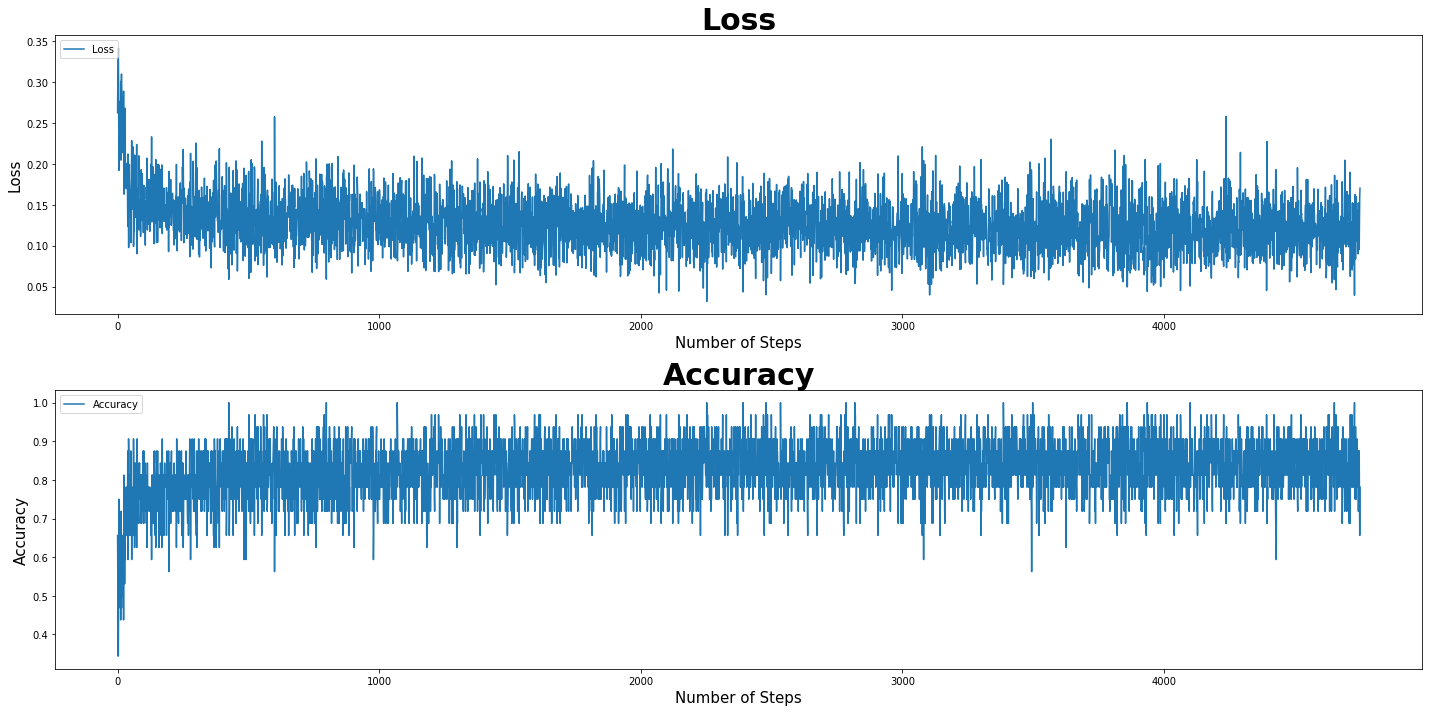

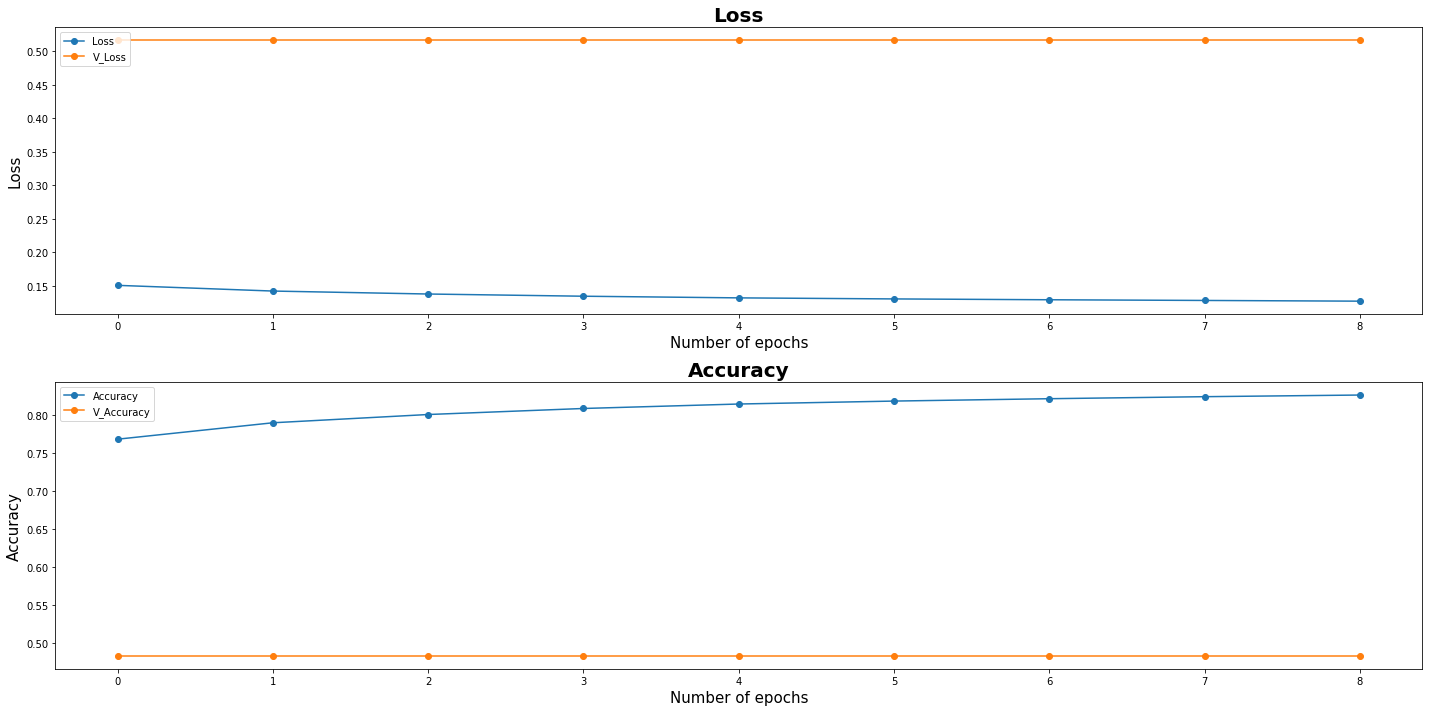

Model Saved
| Epoch [10] | Step [4751] | lr [0.000200] | Loss: [0.1518] | Acc: [0.8125] | Time: 0.1s
| Epoch [10] | Step [4752] | lr [0.000200] | Loss: [0.0900] | Acc: [0.8750] | Time: 0.1s
| Epoch [10] | Step [4753] | lr [0.000200] | Loss: [0.1368] | Acc: [0.7812] | Time: 0.1s
| Epoch [10] | Step [4754] | lr [0.000200] | Loss: [0.0959] | Acc: [0.9062] | Time: 0.1s
| Epoch [10] | Step [4755] | lr [0.000200] | Loss: [0.1043] | Acc: [0.8750] | Time: 0.1s
| Epoch [10] | Step [4756] | lr [0.000200] | Loss: [0.1000] | Acc: [0.9062] | Time: 0.1s
| Epoch [10] | Step [4757] | lr [0.000200] | Loss: [0.1235] | Acc: [0.8438] | Time: 0.1s
| Epoch [10] | Step [4758] | lr [0.000200] | Loss: [0.0794] | Acc: [0.9062] | Time: 0.1s
| Epoch [10] | Step [4759] | lr [0.000200] | Loss: [0.1278] | Acc: [0.7500] | Time: 0.1s
| Epoch [10] | Step [4760] | lr [0.000200] | Loss: [0.1137] | Acc: [0.8438] | Time: 0.1s
| Epoch [10] | Step [4761] | lr [0.000200] | Loss: [0.1663] | Acc: [0.8125] | Time: 0.1s
| Epoch [

| Epoch [10] | Step [4844] | lr [0.000200] | Loss: [0.1536] | Acc: [0.7812] | Time: 0.1s
| Epoch [10] | Step [4845] | lr [0.000200] | Loss: [0.1091] | Acc: [0.8750] | Time: 0.1s
| Epoch [10] | Step [4846] | lr [0.000200] | Loss: [0.0969] | Acc: [0.9062] | Time: 0.1s
| Epoch [10] | Step [4847] | lr [0.000200] | Loss: [0.0744] | Acc: [0.9062] | Time: 0.1s
| Epoch [10] | Step [4848] | lr [0.000200] | Loss: [0.0615] | Acc: [0.9688] | Time: 0.1s
| Epoch [10] | Step [4849] | lr [0.000200] | Loss: [0.1928] | Acc: [0.7812] | Time: 0.1s
| Epoch [10] | Step [4850] | lr [0.000200] | Loss: [0.1226] | Acc: [0.8750] | Time: 0.1s
| Epoch [10] | Step [4851] | lr [0.000200] | Loss: [0.1341] | Acc: [0.8125] | Time: 0.1s
| Epoch [10] | Step [4852] | lr [0.000200] | Loss: [0.1187] | Acc: [0.9375] | Time: 0.1s
| Epoch [10] | Step [4853] | lr [0.000200] | Loss: [0.1473] | Acc: [0.7500] | Time: 0.1s
| Epoch [10] | Step [4854] | lr [0.000200] | Loss: [0.0794] | Acc: [0.9062] | Time: 0.1s
| Epoch [10] | Step [

| Epoch [10] | Step [4938] | lr [0.000200] | Loss: [0.1105] | Acc: [0.8438] | Time: 0.1s
| Epoch [10] | Step [4939] | lr [0.000200] | Loss: [0.0939] | Acc: [0.8750] | Time: 0.1s
| Epoch [10] | Step [4940] | lr [0.000200] | Loss: [0.1425] | Acc: [0.7812] | Time: 0.1s
| Epoch [10] | Step [4941] | lr [0.000200] | Loss: [0.0901] | Acc: [0.9062] | Time: 0.1s
| Epoch [10] | Step [4942] | lr [0.000200] | Loss: [0.1291] | Acc: [0.8125] | Time: 0.1s
| Epoch [10] | Step [4943] | lr [0.000200] | Loss: [0.0622] | Acc: [0.9375] | Time: 0.1s
| Epoch [10] | Step [4944] | lr [0.000200] | Loss: [0.1058] | Acc: [0.8750] | Time: 0.1s
| Epoch [10] | Step [4945] | lr [0.000200] | Loss: [0.1393] | Acc: [0.8125] | Time: 0.1s
| Epoch [10] | Step [4946] | lr [0.000200] | Loss: [0.1234] | Acc: [0.8438] | Time: 0.1s
| Epoch [10] | Step [4947] | lr [0.000200] | Loss: [0.0644] | Acc: [0.9375] | Time: 0.1s
| Epoch [10] | Step [4948] | lr [0.000200] | Loss: [0.1207] | Acc: [0.7812] | Time: 0.1s
| Epoch [10] | Step [

| Epoch [10] | Step [5032] | lr [0.000200] | Loss: [0.1223] | Acc: [0.8125] | Time: 0.1s
| Epoch [10] | Step [5033] | lr [0.000200] | Loss: [0.1558] | Acc: [0.7188] | Time: 0.1s
| Epoch [10] | Step [5034] | lr [0.000200] | Loss: [0.1101] | Acc: [0.9062] | Time: 0.1s
| Epoch [10] | Step [5035] | lr [0.000200] | Loss: [0.1027] | Acc: [0.8750] | Time: 0.1s
| Epoch [10] | Step [5036] | lr [0.000200] | Loss: [0.1085] | Acc: [0.7812] | Time: 0.1s
| Epoch [10] | Step [5037] | lr [0.000200] | Loss: [0.0754] | Acc: [0.9062] | Time: 0.1s
| Epoch [10] | Step [5038] | lr [0.000200] | Loss: [0.1376] | Acc: [0.8438] | Time: 0.1s
| Epoch [10] | Step [5039] | lr [0.000200] | Loss: [0.0847] | Acc: [0.9062] | Time: 0.1s
| Epoch [10] | Step [5040] | lr [0.000200] | Loss: [0.1255] | Acc: [0.8750] | Time: 0.1s
| Epoch [10] | Step [5041] | lr [0.000200] | Loss: [0.1406] | Acc: [0.8438] | Time: 0.1s
| Epoch [10] | Step [5042] | lr [0.000200] | Loss: [0.1207] | Acc: [0.8750] | Time: 0.1s
| Epoch [10] | Step [

| Epoch [10] | Step [5126] | lr [0.000200] | Loss: [0.1039] | Acc: [0.8750] | Time: 0.1s
| Epoch [10] | Step [5127] | lr [0.000200] | Loss: [0.1533] | Acc: [0.7812] | Time: 0.1s
| Epoch [10] | Step [5128] | lr [0.000200] | Loss: [0.1369] | Acc: [0.7500] | Time: 0.1s
| Epoch [10] | Step [5129] | lr [0.000200] | Loss: [0.0914] | Acc: [0.9062] | Time: 0.1s
| Epoch [10] | Step [5130] | lr [0.000200] | Loss: [0.1342] | Acc: [0.8125] | Time: 0.1s
| Epoch [10] | Step [5131] | lr [0.000200] | Loss: [0.1961] | Acc: [0.7188] | Time: 0.1s
| Epoch [10] | Step [5132] | lr [0.000200] | Loss: [0.1432] | Acc: [0.7500] | Time: 0.1s
| Epoch [10] | Step [5133] | lr [0.000200] | Loss: [0.1006] | Acc: [0.8750] | Time: 0.1s
| Epoch [10] | Step [5134] | lr [0.000200] | Loss: [0.0983] | Acc: [0.9062] | Time: 0.1s
| Epoch [10] | Step [5135] | lr [0.000200] | Loss: [0.0826] | Acc: [0.9375] | Time: 0.1s
| Epoch [10] | Step [5136] | lr [0.000200] | Loss: [0.1516] | Acc: [0.7812] | Time: 0.1s
| Epoch [10] | Step [

| Epoch [10] | Step [5220] | lr [0.000200] | Loss: [0.1350] | Acc: [0.8125] | Time: 0.1s
| Epoch [10] | Step [5221] | lr [0.000200] | Loss: [0.1808] | Acc: [0.8125] | Time: 0.1s
| Epoch [10] | Step [5222] | lr [0.000200] | Loss: [0.1609] | Acc: [0.8125] | Time: 0.1s
| Epoch [10] | Step [5223] | lr [0.000200] | Loss: [0.1234] | Acc: [0.8438] | Time: 0.1s
| Epoch [10] | Step [5224] | lr [0.000200] | Loss: [0.0839] | Acc: [0.9375] | Time: 0.1s
| Epoch [10] | Step [5225] | lr [0.000200] | Loss: [0.1304] | Acc: [0.8750] | Time: 0.1s
| Epoch [10] | Validation | Step [0] |  Loss: [0.4375] | Acc: [0.5625] | Time: 0.0s
| Epoch [10] | Validation | Step [1] |  Loss: [0.4688] | Acc: [0.5312] | Time: 0.0s
| Epoch [10] | Validation | Step [2] |  Loss: [0.5312] | Acc: [0.4688] | Time: 0.0s
| Epoch [10] | Validation | Step [3] |  Loss: [0.6250] | Acc: [0.3750] | Time: 0.0s
| Epoch [10] | Validation | Step [4] |  Loss: [0.5312] | Acc: [0.4688] | Time: 0.0s
| Epoch [10] | Validation | Step [5] |  Loss: 

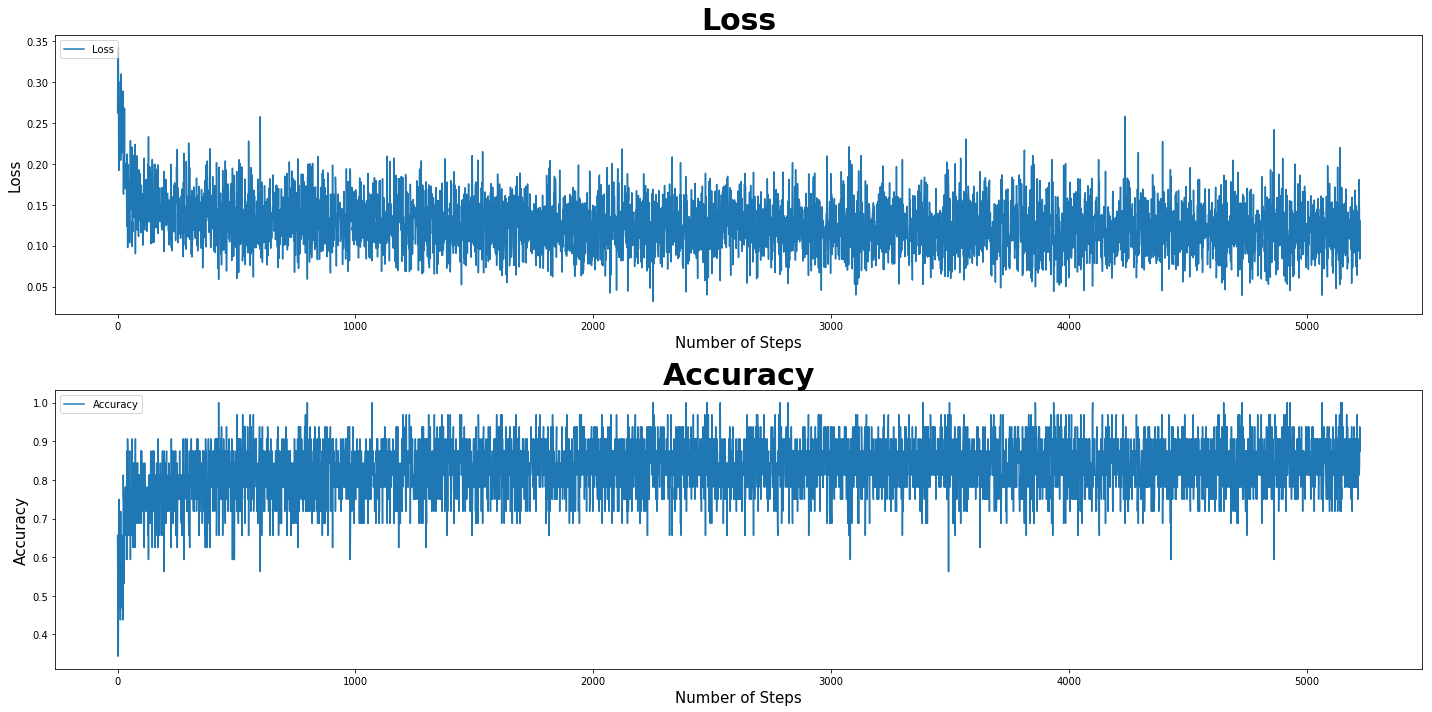

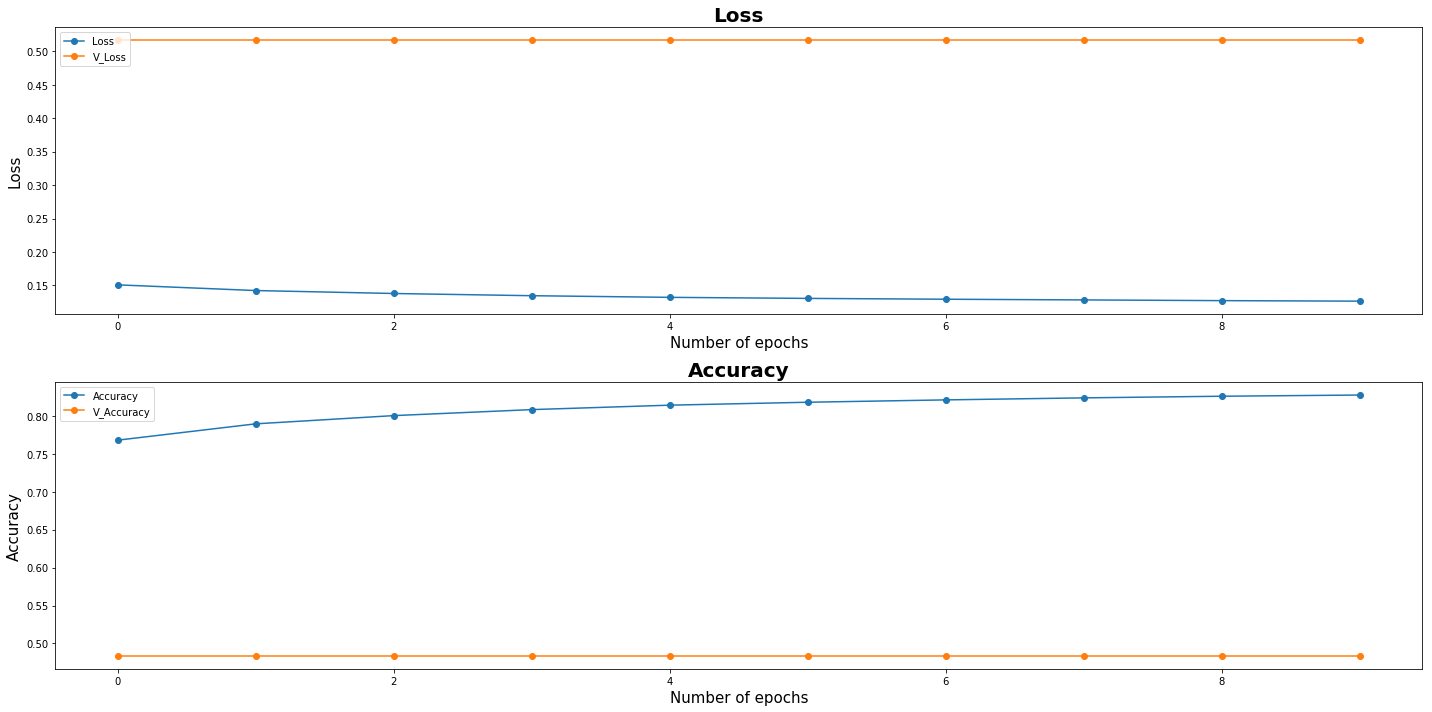

Model Saved
| Epoch [11] | Step [5226] | lr [0.000200] | Loss: [0.0709] | Acc: [0.9375] | Time: 0.1s
| Epoch [11] | Step [5227] | lr [0.000200] | Loss: [0.1075] | Acc: [0.9062] | Time: 0.1s
| Epoch [11] | Step [5228] | lr [0.000200] | Loss: [0.1037] | Acc: [0.8438] | Time: 0.1s
| Epoch [11] | Step [5229] | lr [0.000200] | Loss: [0.1148] | Acc: [0.8750] | Time: 0.1s
| Epoch [11] | Step [5230] | lr [0.000200] | Loss: [0.0951] | Acc: [0.8438] | Time: 0.1s
| Epoch [11] | Step [5231] | lr [0.000200] | Loss: [0.1089] | Acc: [0.8438] | Time: 0.1s
| Epoch [11] | Step [5232] | lr [0.000200] | Loss: [0.1364] | Acc: [0.7500] | Time: 0.1s
| Epoch [11] | Step [5233] | lr [0.000200] | Loss: [0.0863] | Acc: [0.8750] | Time: 0.1s
| Epoch [11] | Step [5234] | lr [0.000200] | Loss: [0.0826] | Acc: [0.9062] | Time: 0.1s
| Epoch [11] | Step [5235] | lr [0.000200] | Loss: [0.1607] | Acc: [0.7500] | Time: 0.1s
| Epoch [11] | Step [5236] | lr [0.000200] | Loss: [0.1062] | Acc: [0.9062] | Time: 0.1s
| Epoch [

| Epoch [11] | Step [5319] | lr [0.000200] | Loss: [0.0968] | Acc: [0.9062] | Time: 0.1s
| Epoch [11] | Step [5320] | lr [0.000200] | Loss: [0.1273] | Acc: [0.7812] | Time: 0.1s
| Epoch [11] | Step [5321] | lr [0.000200] | Loss: [0.1102] | Acc: [0.9062] | Time: 0.1s
| Epoch [11] | Step [5322] | lr [0.000200] | Loss: [0.0911] | Acc: [0.8750] | Time: 0.1s
| Epoch [11] | Step [5323] | lr [0.000200] | Loss: [0.1260] | Acc: [0.8125] | Time: 0.1s
| Epoch [11] | Step [5324] | lr [0.000200] | Loss: [0.1466] | Acc: [0.8438] | Time: 0.1s
| Epoch [11] | Step [5325] | lr [0.000200] | Loss: [0.1423] | Acc: [0.8438] | Time: 0.1s
| Epoch [11] | Step [5326] | lr [0.000200] | Loss: [0.0944] | Acc: [0.8438] | Time: 0.1s
| Epoch [11] | Step [5327] | lr [0.000200] | Loss: [0.0525] | Acc: [0.9062] | Time: 0.1s
| Epoch [11] | Step [5328] | lr [0.000200] | Loss: [0.1080] | Acc: [0.8438] | Time: 0.1s
| Epoch [11] | Step [5329] | lr [0.000200] | Loss: [0.1214] | Acc: [0.8750] | Time: 0.1s
| Epoch [11] | Step [

| Epoch [11] | Step [5413] | lr [0.000200] | Loss: [0.1088] | Acc: [0.8438] | Time: 0.1s
| Epoch [11] | Step [5414] | lr [0.000200] | Loss: [0.0916] | Acc: [0.9375] | Time: 0.1s
| Epoch [11] | Step [5415] | lr [0.000200] | Loss: [0.0849] | Acc: [0.9062] | Time: 0.1s
| Epoch [11] | Step [5416] | lr [0.000200] | Loss: [0.0637] | Acc: [0.9062] | Time: 0.1s
| Epoch [11] | Step [5417] | lr [0.000200] | Loss: [0.1662] | Acc: [0.7500] | Time: 0.1s
| Epoch [11] | Step [5418] | lr [0.000200] | Loss: [0.1225] | Acc: [0.8125] | Time: 0.1s
| Epoch [11] | Step [5419] | lr [0.000200] | Loss: [0.1119] | Acc: [0.8125] | Time: 0.1s
| Epoch [11] | Step [5420] | lr [0.000200] | Loss: [0.1165] | Acc: [0.8125] | Time: 0.1s
| Epoch [11] | Step [5421] | lr [0.000200] | Loss: [0.0659] | Acc: [0.9688] | Time: 0.1s
| Epoch [11] | Step [5422] | lr [0.000200] | Loss: [0.0844] | Acc: [0.9062] | Time: 0.1s
| Epoch [11] | Step [5423] | lr [0.000200] | Loss: [0.1654] | Acc: [0.8125] | Time: 0.1s
| Epoch [11] | Step [

| Epoch [11] | Step [5507] | lr [0.000200] | Loss: [0.1560] | Acc: [0.8125] | Time: 0.1s
| Epoch [11] | Step [5508] | lr [0.000200] | Loss: [0.1202] | Acc: [0.8438] | Time: 0.1s
| Epoch [11] | Step [5509] | lr [0.000200] | Loss: [0.0937] | Acc: [0.9375] | Time: 0.1s
| Epoch [11] | Step [5510] | lr [0.000200] | Loss: [0.1600] | Acc: [0.8125] | Time: 0.1s
| Epoch [11] | Step [5511] | lr [0.000200] | Loss: [0.2029] | Acc: [0.6875] | Time: 0.1s
| Epoch [11] | Step [5512] | lr [0.000200] | Loss: [0.1281] | Acc: [0.8438] | Time: 0.1s
| Epoch [11] | Step [5513] | lr [0.000200] | Loss: [0.1185] | Acc: [0.8438] | Time: 0.1s
| Epoch [11] | Step [5514] | lr [0.000200] | Loss: [0.0863] | Acc: [0.9062] | Time: 0.1s
| Epoch [11] | Step [5515] | lr [0.000200] | Loss: [0.1000] | Acc: [0.9062] | Time: 0.1s
| Epoch [11] | Step [5516] | lr [0.000200] | Loss: [0.1740] | Acc: [0.7500] | Time: 0.1s
| Epoch [11] | Step [5517] | lr [0.000200] | Loss: [0.1262] | Acc: [0.8125] | Time: 0.1s
| Epoch [11] | Step [

| Epoch [11] | Step [5601] | lr [0.000200] | Loss: [0.1369] | Acc: [0.7812] | Time: 0.1s
| Epoch [11] | Step [5602] | lr [0.000200] | Loss: [0.0822] | Acc: [0.9688] | Time: 0.1s
| Epoch [11] | Step [5603] | lr [0.000200] | Loss: [0.1338] | Acc: [0.7812] | Time: 0.1s
| Epoch [11] | Step [5604] | lr [0.000200] | Loss: [0.1092] | Acc: [0.8438] | Time: 0.1s
| Epoch [11] | Step [5605] | lr [0.000200] | Loss: [0.1425] | Acc: [0.7812] | Time: 0.1s
| Epoch [11] | Step [5606] | lr [0.000200] | Loss: [0.1178] | Acc: [0.8438] | Time: 0.1s
| Epoch [11] | Step [5607] | lr [0.000200] | Loss: [0.0661] | Acc: [0.9062] | Time: 0.1s
| Epoch [11] | Step [5608] | lr [0.000200] | Loss: [0.0981] | Acc: [0.8750] | Time: 0.1s
| Epoch [11] | Step [5609] | lr [0.000200] | Loss: [0.1061] | Acc: [0.8750] | Time: 0.1s
| Epoch [11] | Step [5610] | lr [0.000200] | Loss: [0.1176] | Acc: [0.8125] | Time: 0.1s
| Epoch [11] | Step [5611] | lr [0.000200] | Loss: [0.1333] | Acc: [0.7500] | Time: 0.1s
| Epoch [11] | Step [

| Epoch [11] | Step [5695] | lr [0.000200] | Loss: [0.0752] | Acc: [0.8750] | Time: 0.1s
| Epoch [11] | Step [5696] | lr [0.000200] | Loss: [0.1408] | Acc: [0.7188] | Time: 0.1s
| Epoch [11] | Step [5697] | lr [0.000200] | Loss: [0.0544] | Acc: [0.9688] | Time: 0.1s
| Epoch [11] | Step [5698] | lr [0.000200] | Loss: [0.1513] | Acc: [0.7812] | Time: 0.1s
| Epoch [11] | Step [5699] | lr [0.000200] | Loss: [0.1050] | Acc: [0.8125] | Time: 0.1s
| Epoch [11] | Step [5700] | lr [0.000200] | Loss: [0.0906] | Acc: [0.8438] | Time: 0.1s
| Epoch [11] | Validation | Step [0] |  Loss: [0.4688] | Acc: [0.5312] | Time: 0.0s
| Epoch [11] | Validation | Step [1] |  Loss: [0.5938] | Acc: [0.4062] | Time: 0.0s
| Epoch [11] | Validation | Step [2] |  Loss: [0.4688] | Acc: [0.5312] | Time: 0.0s
| Epoch [11] | Validation | Step [3] |  Loss: [0.5000] | Acc: [0.5000] | Time: 0.0s
| Epoch [11] | Validation | Step [4] |  Loss: [0.5312] | Acc: [0.4688] | Time: 0.0s
| Epoch [11] | Validation | Step [5] |  Loss: 

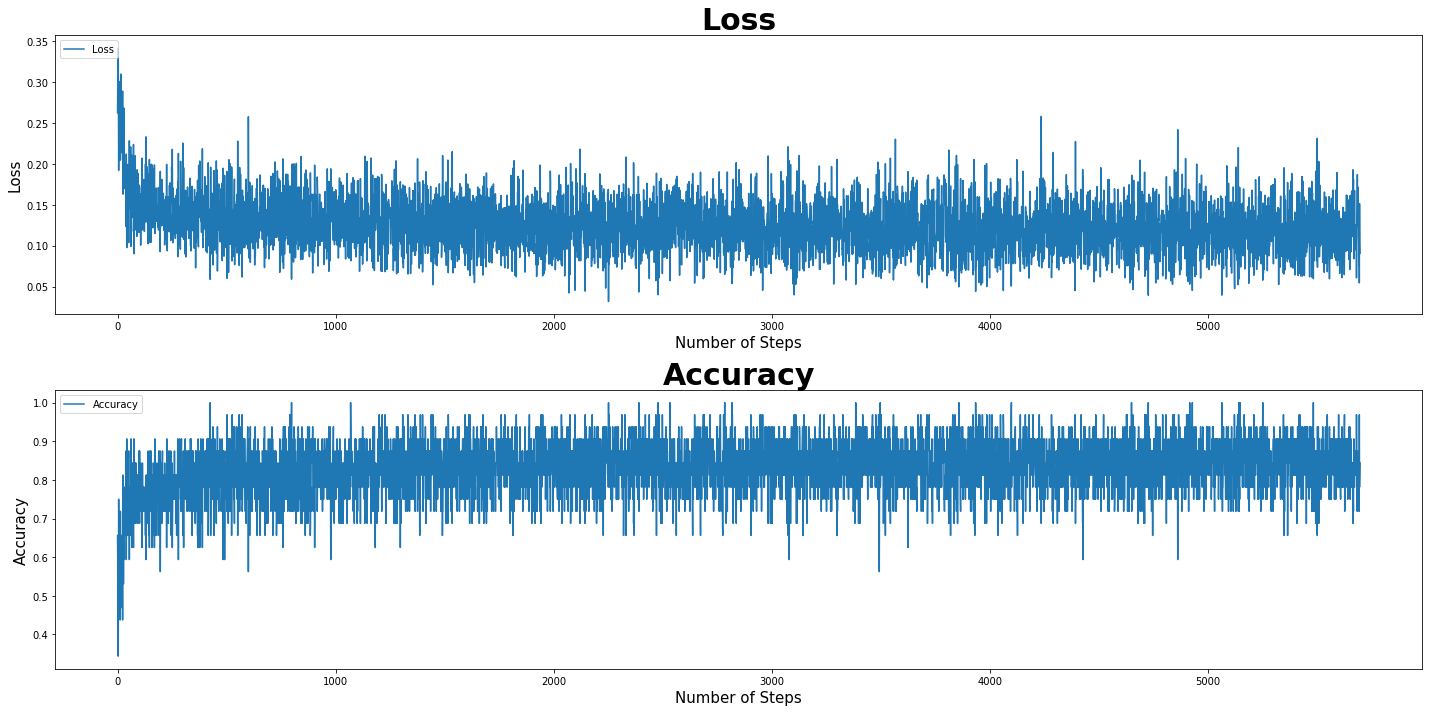

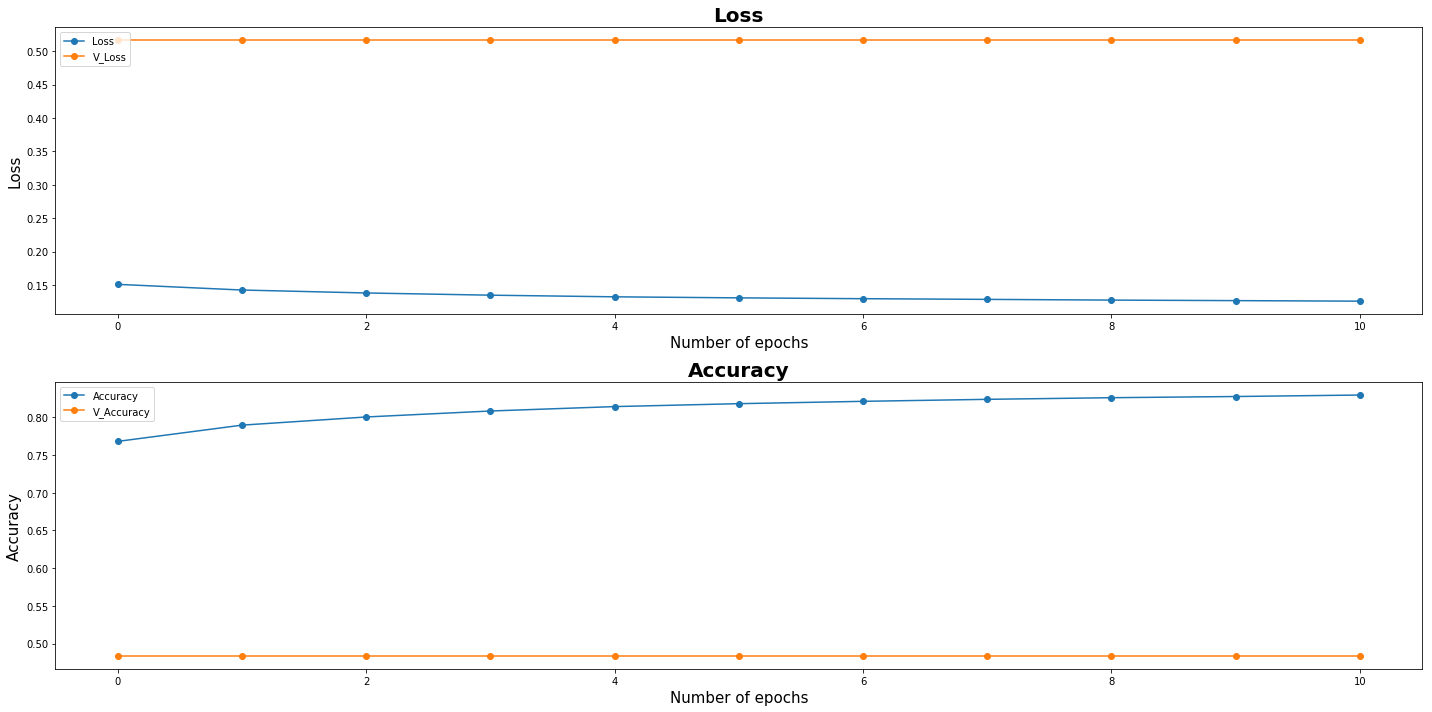

Model Saved
| Epoch [12] | Step [5701] | lr [0.000200] | Loss: [0.0931] | Acc: [0.8750] | Time: 0.1s
| Epoch [12] | Step [5702] | lr [0.000200] | Loss: [0.0899] | Acc: [0.8750] | Time: 0.1s
| Epoch [12] | Step [5703] | lr [0.000200] | Loss: [0.0841] | Acc: [0.8750] | Time: 0.1s
| Epoch [12] | Step [5704] | lr [0.000200] | Loss: [0.0958] | Acc: [0.9062] | Time: 0.1s
| Epoch [12] | Step [5705] | lr [0.000200] | Loss: [0.0682] | Acc: [0.9688] | Time: 0.1s
| Epoch [12] | Step [5706] | lr [0.000200] | Loss: [0.1338] | Acc: [0.8750] | Time: 0.1s
| Epoch [12] | Step [5707] | lr [0.000200] | Loss: [0.1246] | Acc: [0.8438] | Time: 0.1s
| Epoch [12] | Step [5708] | lr [0.000200] | Loss: [0.1375] | Acc: [0.8438] | Time: 0.1s
| Epoch [12] | Step [5709] | lr [0.000200] | Loss: [0.1492] | Acc: [0.7500] | Time: 0.1s
| Epoch [12] | Step [5710] | lr [0.000200] | Loss: [0.1117] | Acc: [0.8438] | Time: 0.1s
| Epoch [12] | Step [5711] | lr [0.000200] | Loss: [0.0934] | Acc: [0.8750] | Time: 0.1s
| Epoch [

| Epoch [12] | Step [5794] | lr [0.000200] | Loss: [0.0647] | Acc: [0.9375] | Time: 0.1s
| Epoch [12] | Step [5795] | lr [0.000200] | Loss: [0.1299] | Acc: [0.8125] | Time: 0.1s
| Epoch [12] | Step [5796] | lr [0.000200] | Loss: [0.1453] | Acc: [0.8125] | Time: 0.1s
| Epoch [12] | Step [5797] | lr [0.000200] | Loss: [0.1760] | Acc: [0.6875] | Time: 0.1s
| Epoch [12] | Step [5798] | lr [0.000200] | Loss: [0.2017] | Acc: [0.6875] | Time: 0.1s
| Epoch [12] | Step [5799] | lr [0.000200] | Loss: [0.1277] | Acc: [0.8125] | Time: 0.1s
| Epoch [12] | Step [5800] | lr [0.000200] | Loss: [0.1180] | Acc: [0.8750] | Time: 0.1s
| Epoch [12] | Step [5801] | lr [0.000200] | Loss: [0.1430] | Acc: [0.7500] | Time: 0.1s
| Epoch [12] | Step [5802] | lr [0.000200] | Loss: [0.1124] | Acc: [0.8438] | Time: 0.1s
| Epoch [12] | Step [5803] | lr [0.000200] | Loss: [0.1552] | Acc: [0.7812] | Time: 0.1s
| Epoch [12] | Step [5804] | lr [0.000200] | Loss: [0.0695] | Acc: [0.9688] | Time: 0.1s
| Epoch [12] | Step [

| Epoch [12] | Step [5888] | lr [0.000200] | Loss: [0.1526] | Acc: [0.7812] | Time: 0.1s
| Epoch [12] | Step [5889] | lr [0.000200] | Loss: [0.1069] | Acc: [0.8125] | Time: 0.1s
| Epoch [12] | Step [5890] | lr [0.000200] | Loss: [0.1274] | Acc: [0.8750] | Time: 0.1s
| Epoch [12] | Step [5891] | lr [0.000200] | Loss: [0.1654] | Acc: [0.7500] | Time: 0.1s
| Epoch [12] | Step [5892] | lr [0.000200] | Loss: [0.1278] | Acc: [0.8125] | Time: 0.1s
| Epoch [12] | Step [5893] | lr [0.000200] | Loss: [0.1248] | Acc: [0.7500] | Time: 0.1s
| Epoch [12] | Step [5894] | lr [0.000200] | Loss: [0.1270] | Acc: [0.7812] | Time: 0.1s
| Epoch [12] | Step [5895] | lr [0.000200] | Loss: [0.0786] | Acc: [0.9375] | Time: 0.1s
| Epoch [12] | Step [5896] | lr [0.000200] | Loss: [0.1293] | Acc: [0.8750] | Time: 0.1s
| Epoch [12] | Step [5897] | lr [0.000200] | Loss: [0.1645] | Acc: [0.7500] | Time: 0.1s
| Epoch [12] | Step [5898] | lr [0.000200] | Loss: [0.1249] | Acc: [0.8438] | Time: 0.1s
| Epoch [12] | Step [

| Epoch [12] | Step [5982] | lr [0.000200] | Loss: [0.1111] | Acc: [0.8750] | Time: 0.1s
| Epoch [12] | Step [5983] | lr [0.000200] | Loss: [0.1241] | Acc: [0.8438] | Time: 0.1s
| Epoch [12] | Step [5984] | lr [0.000200] | Loss: [0.0753] | Acc: [0.9375] | Time: 0.1s
| Epoch [12] | Step [5985] | lr [0.000200] | Loss: [0.0927] | Acc: [0.8750] | Time: 0.1s
| Epoch [12] | Step [5986] | lr [0.000200] | Loss: [0.1656] | Acc: [0.7500] | Time: 0.1s
| Epoch [12] | Step [5987] | lr [0.000200] | Loss: [0.1308] | Acc: [0.8125] | Time: 0.1s
| Epoch [12] | Step [5988] | lr [0.000200] | Loss: [0.1580] | Acc: [0.7812] | Time: 0.1s
| Epoch [12] | Step [5989] | lr [0.000200] | Loss: [0.0983] | Acc: [0.8750] | Time: 0.1s
| Epoch [12] | Step [5990] | lr [0.000200] | Loss: [0.1020] | Acc: [0.8438] | Time: 0.1s
| Epoch [12] | Step [5991] | lr [0.000200] | Loss: [0.0883] | Acc: [0.8750] | Time: 0.1s
| Epoch [12] | Step [5992] | lr [0.000200] | Loss: [0.1563] | Acc: [0.8125] | Time: 0.1s
| Epoch [12] | Step [

| Epoch [12] | Step [6076] | lr [0.000200] | Loss: [0.1246] | Acc: [0.8125] | Time: 0.1s
| Epoch [12] | Step [6077] | lr [0.000200] | Loss: [0.1115] | Acc: [0.8750] | Time: 0.1s
| Epoch [12] | Step [6078] | lr [0.000200] | Loss: [0.1391] | Acc: [0.7812] | Time: 0.1s
| Epoch [12] | Step [6079] | lr [0.000200] | Loss: [0.0868] | Acc: [0.9062] | Time: 0.1s
| Epoch [12] | Step [6080] | lr [0.000200] | Loss: [0.0962] | Acc: [0.9062] | Time: 0.1s
| Epoch [12] | Step [6081] | lr [0.000200] | Loss: [0.0821] | Acc: [0.8750] | Time: 0.1s
| Epoch [12] | Step [6082] | lr [0.000200] | Loss: [0.1078] | Acc: [0.8438] | Time: 0.1s
| Epoch [12] | Step [6083] | lr [0.000200] | Loss: [0.1442] | Acc: [0.7500] | Time: 0.1s
| Epoch [12] | Step [6084] | lr [0.000200] | Loss: [0.1000] | Acc: [0.9062] | Time: 0.1s
| Epoch [12] | Step [6085] | lr [0.000200] | Loss: [0.1026] | Acc: [0.8438] | Time: 0.1s
| Epoch [12] | Step [6086] | lr [0.000200] | Loss: [0.1502] | Acc: [0.7812] | Time: 0.1s
| Epoch [12] | Step [

| Epoch [12] | Step [6170] | lr [0.000200] | Loss: [0.1328] | Acc: [0.7812] | Time: 0.1s
| Epoch [12] | Step [6171] | lr [0.000200] | Loss: [0.1354] | Acc: [0.7188] | Time: 0.1s
| Epoch [12] | Step [6172] | lr [0.000200] | Loss: [0.1266] | Acc: [0.8438] | Time: 0.1s
| Epoch [12] | Step [6173] | lr [0.000200] | Loss: [0.1060] | Acc: [0.8750] | Time: 0.1s
| Epoch [12] | Step [6174] | lr [0.000200] | Loss: [0.1724] | Acc: [0.7812] | Time: 0.1s
| Epoch [12] | Step [6175] | lr [0.000200] | Loss: [0.1110] | Acc: [0.8750] | Time: 0.1s
| Epoch [12] | Validation | Step [0] |  Loss: [0.4062] | Acc: [0.5938] | Time: 0.0s
| Epoch [12] | Validation | Step [1] |  Loss: [0.5312] | Acc: [0.4688] | Time: 0.0s
| Epoch [12] | Validation | Step [2] |  Loss: [0.6250] | Acc: [0.3750] | Time: 0.1s
| Epoch [12] | Validation | Step [3] |  Loss: [0.4688] | Acc: [0.5312] | Time: 0.1s
| Epoch [12] | Validation | Step [4] |  Loss: [0.6562] | Acc: [0.3438] | Time: 0.1s
| Epoch [12] | Validation | Step [5] |  Loss: 

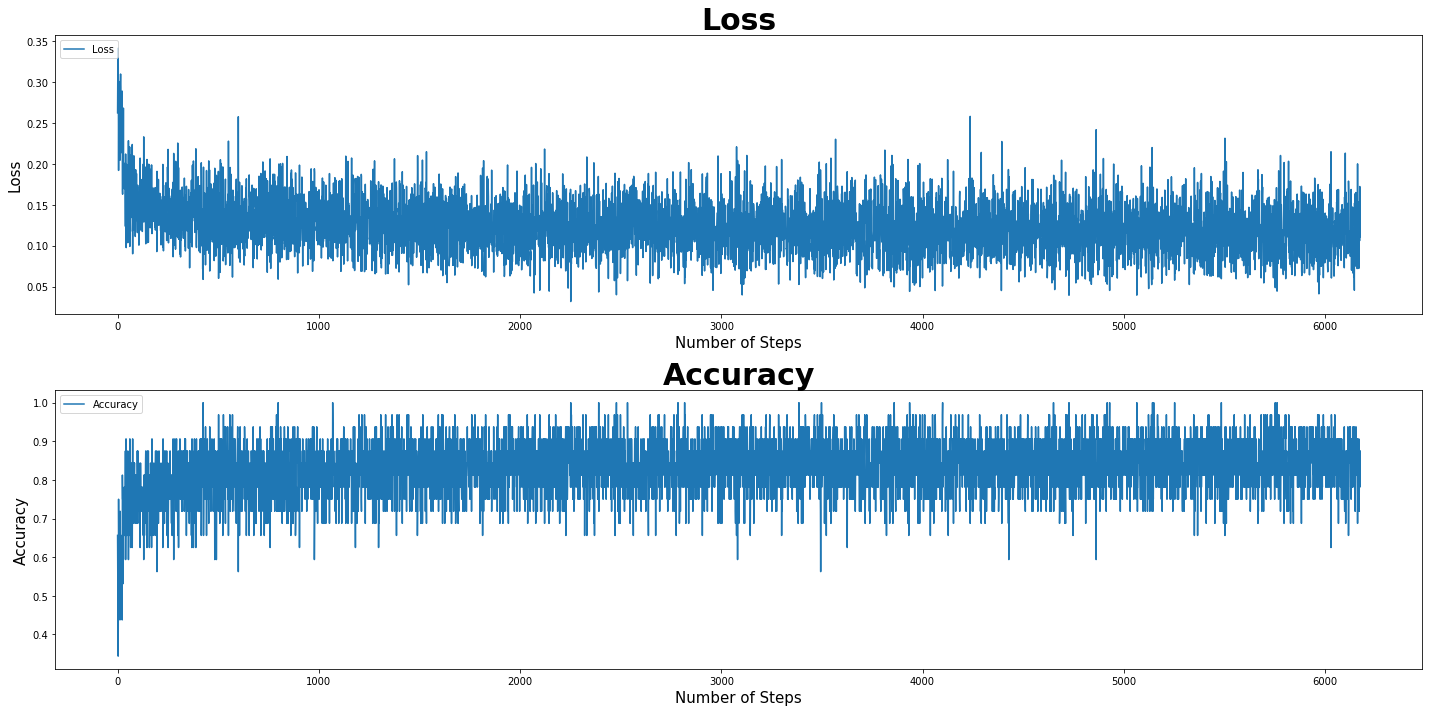

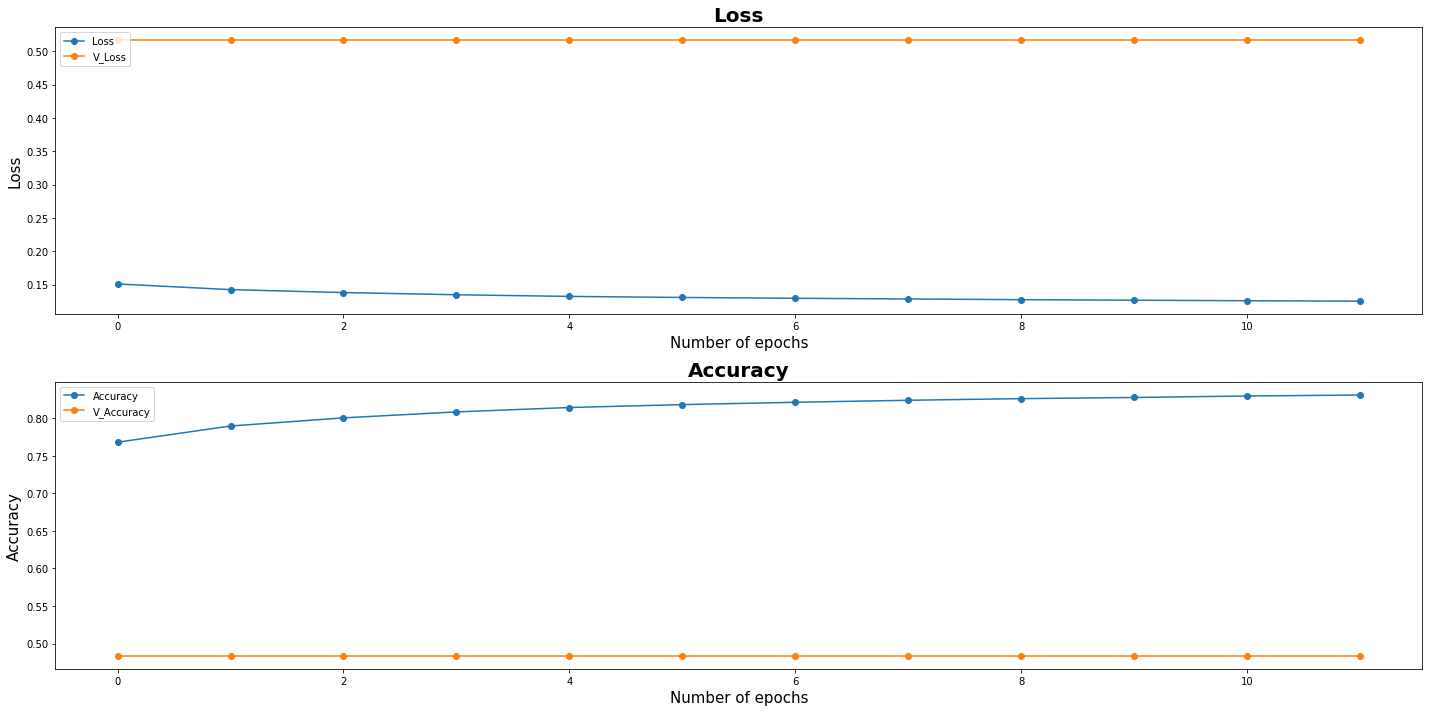

Model Saved
| Epoch [13] | Step [6176] | lr [0.000200] | Loss: [0.1068] | Acc: [0.8750] | Time: 0.1s
| Epoch [13] | Step [6177] | lr [0.000200] | Loss: [0.0975] | Acc: [0.8750] | Time: 0.1s
| Epoch [13] | Step [6178] | lr [0.000200] | Loss: [0.1555] | Acc: [0.7500] | Time: 0.1s
| Epoch [13] | Step [6179] | lr [0.000200] | Loss: [0.1233] | Acc: [0.7812] | Time: 0.1s
| Epoch [13] | Step [6180] | lr [0.000200] | Loss: [0.2086] | Acc: [0.7188] | Time: 0.1s
| Epoch [13] | Step [6181] | lr [0.000200] | Loss: [0.0777] | Acc: [0.9375] | Time: 0.1s
| Epoch [13] | Step [6182] | lr [0.000200] | Loss: [0.0886] | Acc: [0.9062] | Time: 0.1s
| Epoch [13] | Step [6183] | lr [0.000200] | Loss: [0.0802] | Acc: [0.9375] | Time: 0.1s
| Epoch [13] | Step [6184] | lr [0.000200] | Loss: [0.1547] | Acc: [0.8125] | Time: 0.1s
| Epoch [13] | Step [6185] | lr [0.000200] | Loss: [0.0826] | Acc: [0.8750] | Time: 0.1s
| Epoch [13] | Step [6186] | lr [0.000200] | Loss: [0.1220] | Acc: [0.8438] | Time: 0.1s
| Epoch [

| Epoch [13] | Step [6269] | lr [0.000200] | Loss: [0.1860] | Acc: [0.6250] | Time: 0.1s
| Epoch [13] | Step [6270] | lr [0.000200] | Loss: [0.1257] | Acc: [0.8438] | Time: 0.1s
| Epoch [13] | Step [6271] | lr [0.000200] | Loss: [0.1132] | Acc: [0.8125] | Time: 0.1s
| Epoch [13] | Step [6272] | lr [0.000200] | Loss: [0.0863] | Acc: [0.8750] | Time: 0.1s
| Epoch [13] | Step [6273] | lr [0.000200] | Loss: [0.1097] | Acc: [0.8750] | Time: 0.1s
| Epoch [13] | Step [6274] | lr [0.000200] | Loss: [0.1322] | Acc: [0.7188] | Time: 0.1s
| Epoch [13] | Step [6275] | lr [0.000200] | Loss: [0.1000] | Acc: [0.9062] | Time: 0.1s
| Epoch [13] | Step [6276] | lr [0.000200] | Loss: [0.0727] | Acc: [0.9062] | Time: 0.1s
| Epoch [13] | Step [6277] | lr [0.000200] | Loss: [0.1319] | Acc: [0.8438] | Time: 0.1s
| Epoch [13] | Step [6278] | lr [0.000200] | Loss: [0.0395] | Acc: [0.9688] | Time: 0.1s
| Epoch [13] | Step [6279] | lr [0.000200] | Loss: [0.1567] | Acc: [0.7500] | Time: 0.1s
| Epoch [13] | Step [

| Epoch [13] | Step [6363] | lr [0.000200] | Loss: [0.1447] | Acc: [0.8125] | Time: 0.1s
| Epoch [13] | Step [6364] | lr [0.000200] | Loss: [0.1259] | Acc: [0.8125] | Time: 0.1s
| Epoch [13] | Step [6365] | lr [0.000200] | Loss: [0.0778] | Acc: [0.9375] | Time: 0.1s
| Epoch [13] | Step [6366] | lr [0.000200] | Loss: [0.1171] | Acc: [0.8750] | Time: 0.1s
| Epoch [13] | Step [6367] | lr [0.000200] | Loss: [0.0958] | Acc: [0.9062] | Time: 0.1s
| Epoch [13] | Step [6368] | lr [0.000200] | Loss: [0.1246] | Acc: [0.8438] | Time: 0.1s
| Epoch [13] | Step [6369] | lr [0.000200] | Loss: [0.1049] | Acc: [0.9062] | Time: 0.1s
| Epoch [13] | Step [6370] | lr [0.000200] | Loss: [0.1062] | Acc: [0.8125] | Time: 0.1s
| Epoch [13] | Step [6371] | lr [0.000200] | Loss: [0.1001] | Acc: [0.9375] | Time: 0.1s
| Epoch [13] | Step [6372] | lr [0.000200] | Loss: [0.0908] | Acc: [0.9062] | Time: 0.1s
| Epoch [13] | Step [6373] | lr [0.000200] | Loss: [0.0956] | Acc: [0.8750] | Time: 0.1s
| Epoch [13] | Step [

| Epoch [13] | Step [6457] | lr [0.000200] | Loss: [0.0919] | Acc: [0.9062] | Time: 0.1s
| Epoch [13] | Step [6458] | lr [0.000200] | Loss: [0.0983] | Acc: [0.8750] | Time: 0.1s
| Epoch [13] | Step [6459] | lr [0.000200] | Loss: [0.1202] | Acc: [0.8125] | Time: 0.1s
| Epoch [13] | Step [6460] | lr [0.000200] | Loss: [0.1648] | Acc: [0.7188] | Time: 0.1s
| Epoch [13] | Step [6461] | lr [0.000200] | Loss: [0.1307] | Acc: [0.9062] | Time: 0.1s
| Epoch [13] | Step [6462] | lr [0.000200] | Loss: [0.0896] | Acc: [0.8750] | Time: 0.1s
| Epoch [13] | Step [6463] | lr [0.000200] | Loss: [0.1465] | Acc: [0.8125] | Time: 0.1s
| Epoch [13] | Step [6464] | lr [0.000200] | Loss: [0.1264] | Acc: [0.7812] | Time: 0.1s
| Epoch [13] | Step [6465] | lr [0.000200] | Loss: [0.1391] | Acc: [0.8750] | Time: 0.1s
| Epoch [13] | Step [6466] | lr [0.000200] | Loss: [0.1092] | Acc: [0.8750] | Time: 0.1s
| Epoch [13] | Step [6467] | lr [0.000200] | Loss: [0.1057] | Acc: [0.9062] | Time: 0.1s
| Epoch [13] | Step [

| Epoch [13] | Step [6551] | lr [0.000200] | Loss: [0.1410] | Acc: [0.7812] | Time: 0.1s
| Epoch [13] | Step [6552] | lr [0.000200] | Loss: [0.0925] | Acc: [0.8438] | Time: 0.1s
| Epoch [13] | Step [6553] | lr [0.000200] | Loss: [0.1143] | Acc: [0.9062] | Time: 0.1s
| Epoch [13] | Step [6554] | lr [0.000200] | Loss: [0.1065] | Acc: [0.8438] | Time: 0.1s
| Epoch [13] | Step [6555] | lr [0.000200] | Loss: [0.1379] | Acc: [0.8125] | Time: 0.1s
| Epoch [13] | Step [6556] | lr [0.000200] | Loss: [0.1350] | Acc: [0.8750] | Time: 0.1s
| Epoch [13] | Step [6557] | lr [0.000200] | Loss: [0.1013] | Acc: [0.8750] | Time: 0.1s
| Epoch [13] | Step [6558] | lr [0.000200] | Loss: [0.0635] | Acc: [0.9375] | Time: 0.1s
| Epoch [13] | Step [6559] | lr [0.000200] | Loss: [0.1101] | Acc: [0.9062] | Time: 0.1s
| Epoch [13] | Step [6560] | lr [0.000200] | Loss: [0.1552] | Acc: [0.7500] | Time: 0.1s
| Epoch [13] | Step [6561] | lr [0.000200] | Loss: [0.1134] | Acc: [0.8438] | Time: 0.1s
| Epoch [13] | Step [

| Epoch [13] | Step [6645] | lr [0.000200] | Loss: [0.1348] | Acc: [0.7812] | Time: 0.1s
| Epoch [13] | Step [6646] | lr [0.000200] | Loss: [0.0730] | Acc: [0.9375] | Time: 0.1s
| Epoch [13] | Step [6647] | lr [0.000200] | Loss: [0.1335] | Acc: [0.9062] | Time: 0.1s
| Epoch [13] | Step [6648] | lr [0.000200] | Loss: [0.1428] | Acc: [0.8438] | Time: 0.1s
| Epoch [13] | Step [6649] | lr [0.000200] | Loss: [0.0761] | Acc: [0.9375] | Time: 0.1s
| Epoch [13] | Step [6650] | lr [0.000200] | Loss: [0.0908] | Acc: [0.9062] | Time: 0.1s
| Epoch [13] | Validation | Step [0] |  Loss: [0.5938] | Acc: [0.4062] | Time: 0.0s
| Epoch [13] | Validation | Step [1] |  Loss: [0.4688] | Acc: [0.5312] | Time: 0.0s
| Epoch [13] | Validation | Step [2] |  Loss: [0.3750] | Acc: [0.6250] | Time: 0.0s
| Epoch [13] | Validation | Step [3] |  Loss: [0.4688] | Acc: [0.5312] | Time: 0.0s
| Epoch [13] | Validation | Step [4] |  Loss: [0.5000] | Acc: [0.5000] | Time: 0.0s
| Epoch [13] | Validation | Step [5] |  Loss: 

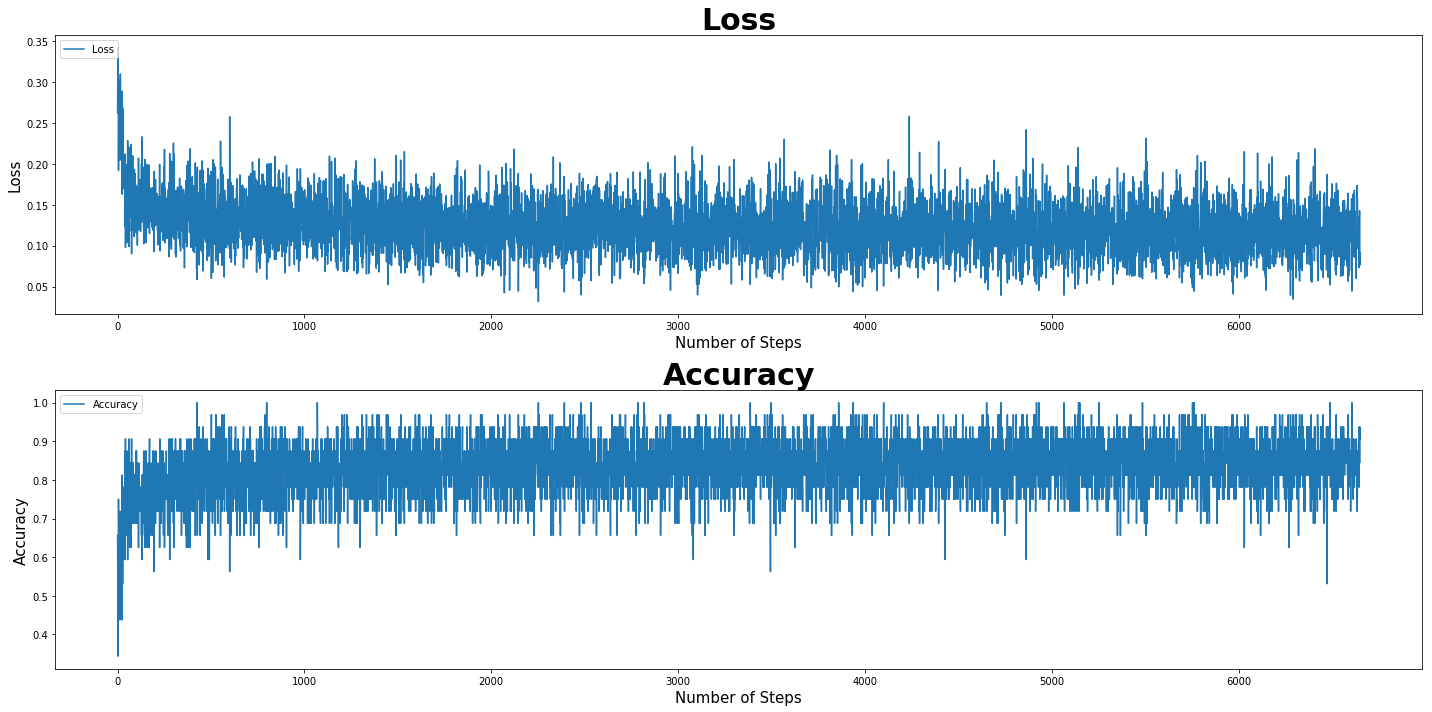

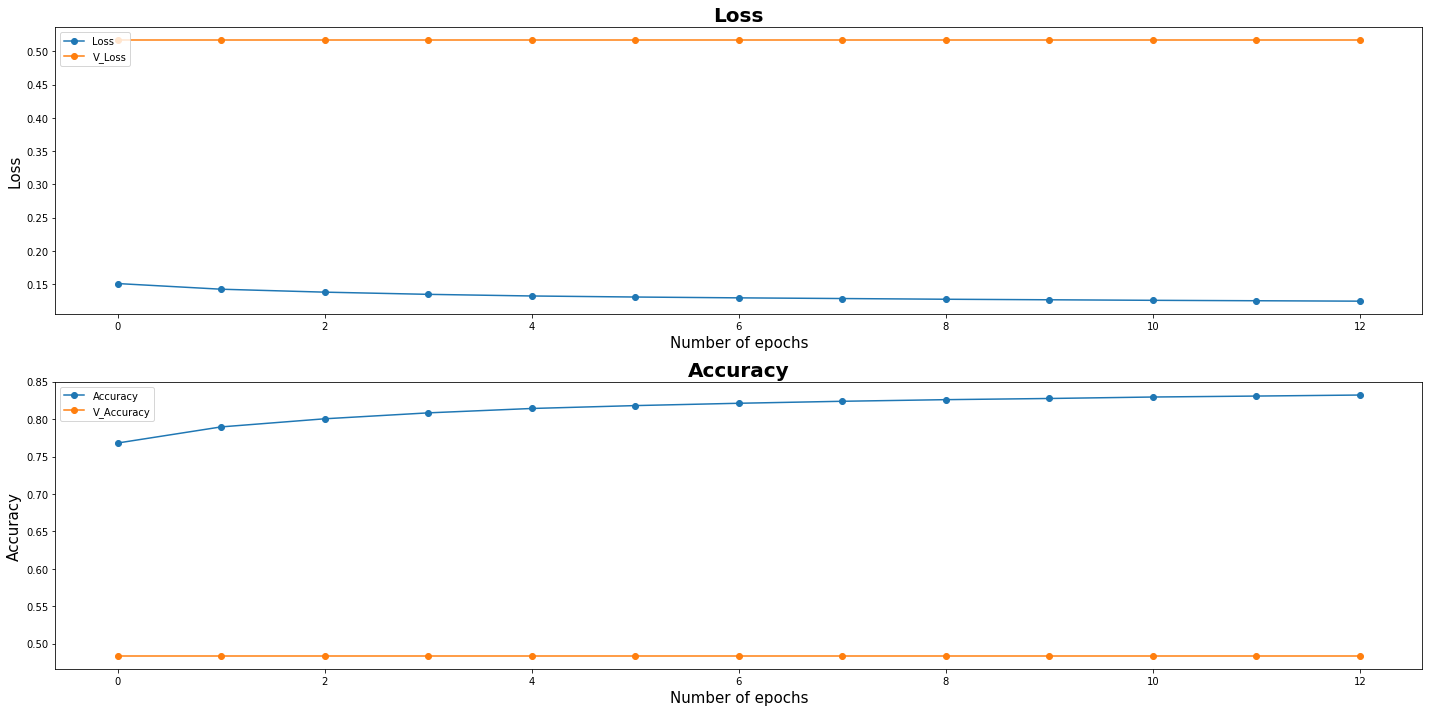

Model Saved
| Epoch [14] | Step [6651] | lr [0.000200] | Loss: [0.1149] | Acc: [0.8750] | Time: 0.2s
| Epoch [14] | Step [6652] | lr [0.000200] | Loss: [0.0938] | Acc: [0.8750] | Time: 0.1s
| Epoch [14] | Step [6653] | lr [0.000200] | Loss: [0.1198] | Acc: [0.8125] | Time: 0.1s
| Epoch [14] | Step [6654] | lr [0.000200] | Loss: [0.1158] | Acc: [0.8750] | Time: 0.1s
| Epoch [14] | Step [6655] | lr [0.000200] | Loss: [0.1482] | Acc: [0.7812] | Time: 0.1s
| Epoch [14] | Step [6656] | lr [0.000200] | Loss: [0.0787] | Acc: [0.9375] | Time: 0.1s
| Epoch [14] | Step [6657] | lr [0.000200] | Loss: [0.1349] | Acc: [0.8125] | Time: 0.1s
| Epoch [14] | Step [6658] | lr [0.000200] | Loss: [0.1083] | Acc: [0.8750] | Time: 0.1s
| Epoch [14] | Step [6659] | lr [0.000200] | Loss: [0.0520] | Acc: [0.9688] | Time: 0.1s
| Epoch [14] | Step [6660] | lr [0.000200] | Loss: [0.1272] | Acc: [0.8125] | Time: 0.1s
| Epoch [14] | Step [6661] | lr [0.000200] | Loss: [0.0794] | Acc: [0.9375] | Time: 0.1s
| Epoch [

| Epoch [14] | Step [6744] | lr [0.000200] | Loss: [0.1202] | Acc: [0.8438] | Time: 0.1s
| Epoch [14] | Step [6745] | lr [0.000200] | Loss: [0.1289] | Acc: [0.8750] | Time: 0.1s
| Epoch [14] | Step [6746] | lr [0.000200] | Loss: [0.1395] | Acc: [0.8125] | Time: 0.1s
| Epoch [14] | Step [6747] | lr [0.000200] | Loss: [0.0970] | Acc: [0.9375] | Time: 0.1s
| Epoch [14] | Step [6748] | lr [0.000200] | Loss: [0.0736] | Acc: [0.8750] | Time: 0.1s
| Epoch [14] | Step [6749] | lr [0.000200] | Loss: [0.0934] | Acc: [0.9375] | Time: 0.1s
| Epoch [14] | Step [6750] | lr [0.000200] | Loss: [0.1169] | Acc: [0.8438] | Time: 0.1s
| Epoch [14] | Step [6751] | lr [0.000200] | Loss: [0.0345] | Acc: [1.0000] | Time: 0.1s
| Epoch [14] | Step [6752] | lr [0.000200] | Loss: [0.0978] | Acc: [0.9062] | Time: 0.1s
| Epoch [14] | Step [6753] | lr [0.000200] | Loss: [0.1140] | Acc: [0.8438] | Time: 0.1s
| Epoch [14] | Step [6754] | lr [0.000200] | Loss: [0.1326] | Acc: [0.7812] | Time: 0.1s
| Epoch [14] | Step [

| Epoch [14] | Step [6838] | lr [0.000200] | Loss: [0.1391] | Acc: [0.7812] | Time: 0.1s
| Epoch [14] | Step [6839] | lr [0.000200] | Loss: [0.1704] | Acc: [0.7500] | Time: 0.1s
| Epoch [14] | Step [6840] | lr [0.000200] | Loss: [0.0643] | Acc: [0.9375] | Time: 0.1s
| Epoch [14] | Step [6841] | lr [0.000200] | Loss: [0.1571] | Acc: [0.8125] | Time: 0.1s
| Epoch [14] | Step [6842] | lr [0.000200] | Loss: [0.0792] | Acc: [0.8750] | Time: 0.1s
| Epoch [14] | Step [6843] | lr [0.000200] | Loss: [0.1321] | Acc: [0.8438] | Time: 0.1s
| Epoch [14] | Step [6844] | lr [0.000200] | Loss: [0.1089] | Acc: [0.8125] | Time: 0.1s
| Epoch [14] | Step [6845] | lr [0.000200] | Loss: [0.1268] | Acc: [0.8438] | Time: 0.1s
| Epoch [14] | Step [6846] | lr [0.000200] | Loss: [0.0725] | Acc: [0.9375] | Time: 0.1s
| Epoch [14] | Step [6847] | lr [0.000200] | Loss: [0.1519] | Acc: [0.7188] | Time: 0.1s
| Epoch [14] | Step [6848] | lr [0.000200] | Loss: [0.1417] | Acc: [0.8125] | Time: 0.1s
| Epoch [14] | Step [

| Epoch [14] | Step [6932] | lr [0.000200] | Loss: [0.0835] | Acc: [0.9062] | Time: 0.1s
| Epoch [14] | Step [6933] | lr [0.000200] | Loss: [0.1194] | Acc: [0.8438] | Time: 0.1s
| Epoch [14] | Step [6934] | lr [0.000200] | Loss: [0.1063] | Acc: [0.9062] | Time: 0.1s
| Epoch [14] | Step [6935] | lr [0.000200] | Loss: [0.1360] | Acc: [0.8438] | Time: 0.1s
| Epoch [14] | Step [6936] | lr [0.000200] | Loss: [0.0750] | Acc: [0.8750] | Time: 0.1s
| Epoch [14] | Step [6937] | lr [0.000200] | Loss: [0.1489] | Acc: [0.8438] | Time: 0.1s
| Epoch [14] | Step [6938] | lr [0.000200] | Loss: [0.1264] | Acc: [0.8438] | Time: 0.1s
| Epoch [14] | Step [6939] | lr [0.000200] | Loss: [0.1120] | Acc: [0.8125] | Time: 0.1s
| Epoch [14] | Step [6940] | lr [0.000200] | Loss: [0.1137] | Acc: [0.8438] | Time: 0.1s
| Epoch [14] | Step [6941] | lr [0.000200] | Loss: [0.1369] | Acc: [0.7812] | Time: 0.1s
| Epoch [14] | Step [6942] | lr [0.000200] | Loss: [0.1101] | Acc: [0.9062] | Time: 0.1s
| Epoch [14] | Step [

| Epoch [14] | Step [7026] | lr [0.000200] | Loss: [0.0595] | Acc: [0.9375] | Time: 0.1s
| Epoch [14] | Step [7027] | lr [0.000200] | Loss: [0.0931] | Acc: [0.9062] | Time: 0.1s
| Epoch [14] | Step [7028] | lr [0.000200] | Loss: [0.1467] | Acc: [0.7500] | Time: 0.1s
| Epoch [14] | Step [7029] | lr [0.000200] | Loss: [0.1330] | Acc: [0.8750] | Time: 0.1s
| Epoch [14] | Step [7030] | lr [0.000200] | Loss: [0.1161] | Acc: [0.8438] | Time: 0.1s
| Epoch [14] | Step [7031] | lr [0.000200] | Loss: [0.1007] | Acc: [0.8438] | Time: 0.1s
| Epoch [14] | Step [7032] | lr [0.000200] | Loss: [0.0820] | Acc: [0.9375] | Time: 0.1s
| Epoch [14] | Step [7033] | lr [0.000200] | Loss: [0.1644] | Acc: [0.7812] | Time: 0.1s
| Epoch [14] | Step [7034] | lr [0.000200] | Loss: [0.1385] | Acc: [0.7188] | Time: 0.1s
| Epoch [14] | Step [7035] | lr [0.000200] | Loss: [0.1180] | Acc: [0.8750] | Time: 0.1s
| Epoch [14] | Step [7036] | lr [0.000200] | Loss: [0.0845] | Acc: [0.9375] | Time: 0.1s
| Epoch [14] | Step [

| Epoch [14] | Step [7120] | lr [0.000200] | Loss: [0.1482] | Acc: [0.8125] | Time: 0.1s
| Epoch [14] | Step [7121] | lr [0.000200] | Loss: [0.0986] | Acc: [0.9062] | Time: 0.1s
| Epoch [14] | Step [7122] | lr [0.000200] | Loss: [0.1319] | Acc: [0.8125] | Time: 0.1s
| Epoch [14] | Step [7123] | lr [0.000200] | Loss: [0.0815] | Acc: [0.9062] | Time: 0.1s
| Epoch [14] | Step [7124] | lr [0.000200] | Loss: [0.1162] | Acc: [0.8750] | Time: 0.1s
| Epoch [14] | Step [7125] | lr [0.000200] | Loss: [0.0909] | Acc: [0.8750] | Time: 0.1s
| Epoch [14] | Validation | Step [0] |  Loss: [0.6875] | Acc: [0.3125] | Time: 0.0s
| Epoch [14] | Validation | Step [1] |  Loss: [0.4375] | Acc: [0.5625] | Time: 0.0s
| Epoch [14] | Validation | Step [2] |  Loss: [0.5312] | Acc: [0.4688] | Time: 0.0s
| Epoch [14] | Validation | Step [3] |  Loss: [0.4688] | Acc: [0.5312] | Time: 0.0s
| Epoch [14] | Validation | Step [4] |  Loss: [0.4688] | Acc: [0.5312] | Time: 0.0s
| Epoch [14] | Validation | Step [5] |  Loss: 

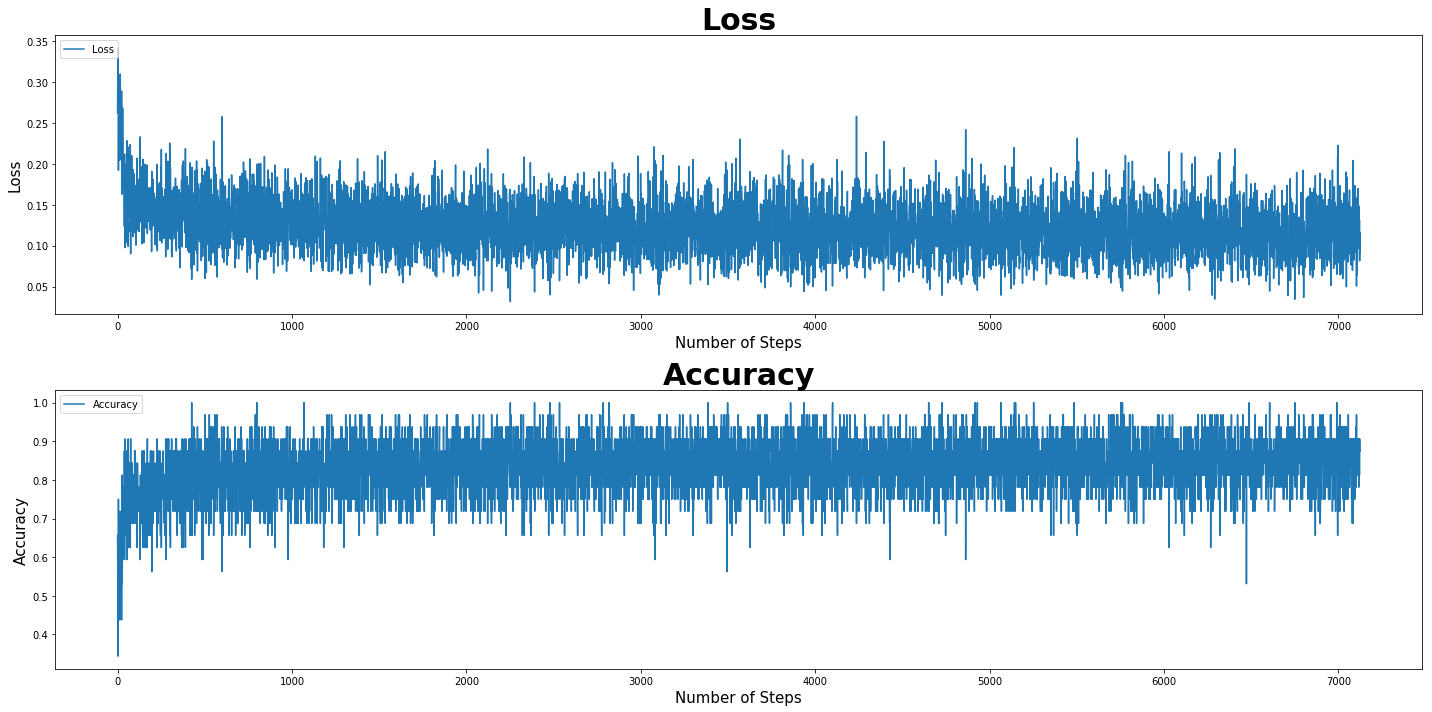

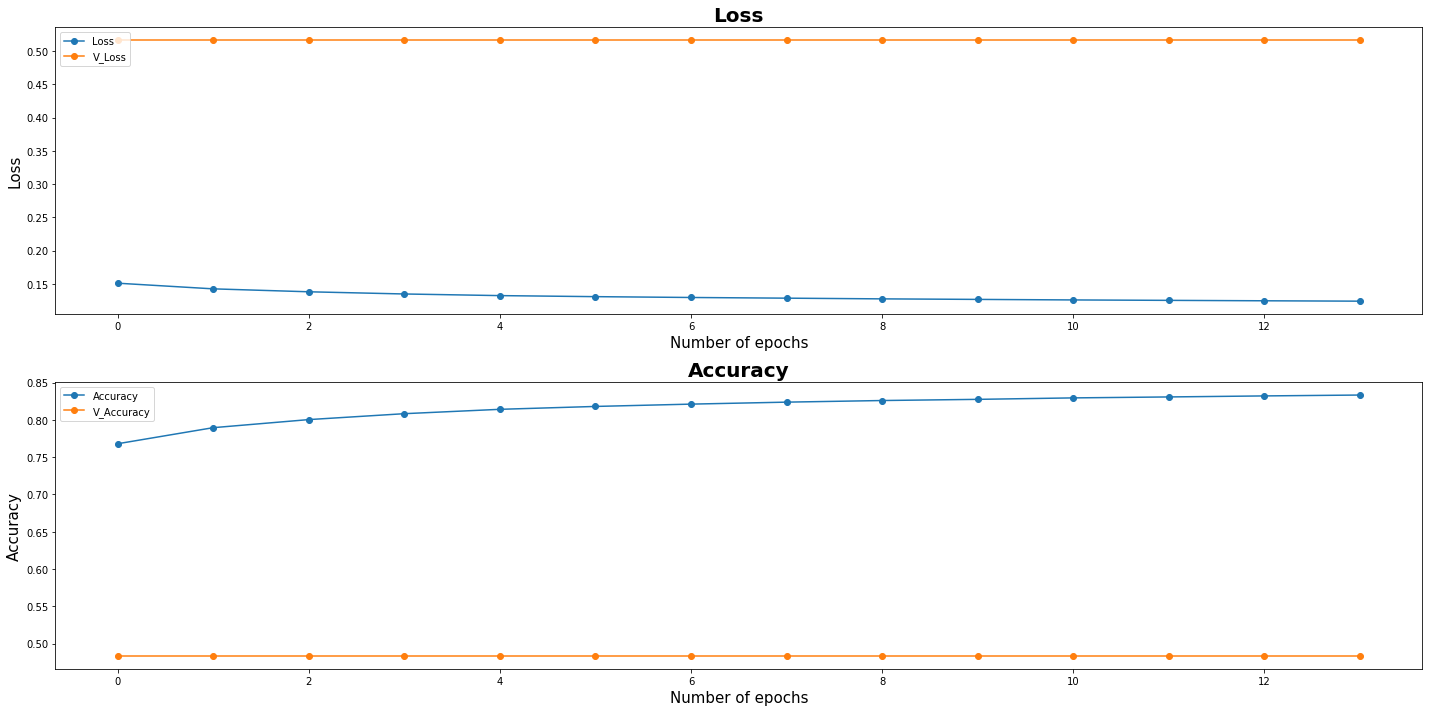

Model Saved
| Epoch [15] | Step [7126] | lr [0.000200] | Loss: [0.1090] | Acc: [0.9062] | Time: 0.1s
| Epoch [15] | Step [7127] | lr [0.000200] | Loss: [0.1030] | Acc: [0.8750] | Time: 0.1s
| Epoch [15] | Step [7128] | lr [0.000200] | Loss: [0.0995] | Acc: [0.9062] | Time: 0.1s
| Epoch [15] | Step [7129] | lr [0.000200] | Loss: [0.1318] | Acc: [0.7812] | Time: 0.1s
| Epoch [15] | Step [7130] | lr [0.000200] | Loss: [0.1551] | Acc: [0.8125] | Time: 0.1s
| Epoch [15] | Step [7131] | lr [0.000200] | Loss: [0.1154] | Acc: [0.7812] | Time: 0.2s
| Epoch [15] | Step [7132] | lr [0.000200] | Loss: [0.0858] | Acc: [0.9688] | Time: 0.1s
| Epoch [15] | Step [7133] | lr [0.000200] | Loss: [0.1540] | Acc: [0.7812] | Time: 0.1s
| Epoch [15] | Step [7134] | lr [0.000200] | Loss: [0.1253] | Acc: [0.8750] | Time: 0.1s
| Epoch [15] | Step [7135] | lr [0.000200] | Loss: [0.1238] | Acc: [0.8438] | Time: 0.1s
| Epoch [15] | Step [7136] | lr [0.000200] | Loss: [0.1549] | Acc: [0.8125] | Time: 0.1s
| Epoch [

| Epoch [15] | Step [7219] | lr [0.000200] | Loss: [0.1369] | Acc: [0.7812] | Time: 0.1s
| Epoch [15] | Step [7220] | lr [0.000200] | Loss: [0.1333] | Acc: [0.7812] | Time: 0.1s
| Epoch [15] | Step [7221] | lr [0.000200] | Loss: [0.1638] | Acc: [0.7812] | Time: 0.1s
| Epoch [15] | Step [7222] | lr [0.000200] | Loss: [0.0869] | Acc: [0.9062] | Time: 0.1s
| Epoch [15] | Step [7223] | lr [0.000200] | Loss: [0.0766] | Acc: [0.9375] | Time: 0.1s
| Epoch [15] | Step [7224] | lr [0.000200] | Loss: [0.1163] | Acc: [0.8750] | Time: 0.1s
| Epoch [15] | Step [7225] | lr [0.000200] | Loss: [0.0931] | Acc: [0.9375] | Time: 0.1s
| Epoch [15] | Step [7226] | lr [0.000200] | Loss: [0.0746] | Acc: [0.9375] | Time: 0.1s
| Epoch [15] | Step [7227] | lr [0.000200] | Loss: [0.0915] | Acc: [0.9062] | Time: 0.1s
| Epoch [15] | Step [7228] | lr [0.000200] | Loss: [0.1450] | Acc: [0.8125] | Time: 0.1s
| Epoch [15] | Step [7229] | lr [0.000200] | Loss: [0.0815] | Acc: [0.9375] | Time: 0.1s
| Epoch [15] | Step [

| Epoch [15] | Step [7313] | lr [0.000200] | Loss: [0.0666] | Acc: [0.9062] | Time: 0.1s
| Epoch [15] | Step [7314] | lr [0.000200] | Loss: [0.1120] | Acc: [0.8750] | Time: 0.1s
| Epoch [15] | Step [7315] | lr [0.000200] | Loss: [0.0894] | Acc: [0.9062] | Time: 0.1s
| Epoch [15] | Step [7316] | lr [0.000200] | Loss: [0.1183] | Acc: [0.8750] | Time: 0.1s
| Epoch [15] | Step [7317] | lr [0.000200] | Loss: [0.0906] | Acc: [0.8750] | Time: 0.1s
| Epoch [15] | Step [7318] | lr [0.000200] | Loss: [0.0978] | Acc: [0.9062] | Time: 0.1s
| Epoch [15] | Step [7319] | lr [0.000200] | Loss: [0.1424] | Acc: [0.8125] | Time: 0.1s
| Epoch [15] | Step [7320] | lr [0.000200] | Loss: [0.1221] | Acc: [0.9062] | Time: 0.1s
| Epoch [15] | Step [7321] | lr [0.000200] | Loss: [0.1092] | Acc: [0.8438] | Time: 0.1s
| Epoch [15] | Step [7322] | lr [0.000200] | Loss: [0.1684] | Acc: [0.7188] | Time: 0.1s
| Epoch [15] | Step [7323] | lr [0.000200] | Loss: [0.0674] | Acc: [0.9375] | Time: 0.1s
| Epoch [15] | Step [

| Epoch [15] | Step [7407] | lr [0.000200] | Loss: [0.1089] | Acc: [0.8750] | Time: 0.1s
| Epoch [15] | Step [7408] | lr [0.000200] | Loss: [0.0799] | Acc: [0.9062] | Time: 0.1s
| Epoch [15] | Step [7409] | lr [0.000200] | Loss: [0.1569] | Acc: [0.8438] | Time: 0.1s
| Epoch [15] | Step [7410] | lr [0.000200] | Loss: [0.1032] | Acc: [0.8750] | Time: 0.1s
| Epoch [15] | Step [7411] | lr [0.000200] | Loss: [0.1040] | Acc: [0.9062] | Time: 0.1s
| Epoch [15] | Step [7412] | lr [0.000200] | Loss: [0.0715] | Acc: [0.9375] | Time: 0.1s
| Epoch [15] | Step [7413] | lr [0.000200] | Loss: [0.1319] | Acc: [0.7188] | Time: 0.1s
| Epoch [15] | Step [7414] | lr [0.000200] | Loss: [0.0949] | Acc: [0.9062] | Time: 0.1s
| Epoch [15] | Step [7415] | lr [0.000200] | Loss: [0.1159] | Acc: [0.8750] | Time: 0.1s
| Epoch [15] | Step [7416] | lr [0.000200] | Loss: [0.1540] | Acc: [0.8125] | Time: 0.1s
| Epoch [15] | Step [7417] | lr [0.000200] | Loss: [0.0560] | Acc: [0.9375] | Time: 0.1s
| Epoch [15] | Step [

| Epoch [15] | Step [7501] | lr [0.000200] | Loss: [0.0468] | Acc: [0.9688] | Time: 0.1s
| Epoch [15] | Step [7502] | lr [0.000200] | Loss: [0.1268] | Acc: [0.8438] | Time: 0.1s
| Epoch [15] | Step [7503] | lr [0.000200] | Loss: [0.0822] | Acc: [0.8750] | Time: 0.1s
| Epoch [15] | Step [7504] | lr [0.000200] | Loss: [0.1121] | Acc: [0.8438] | Time: 0.1s
| Epoch [15] | Step [7505] | lr [0.000200] | Loss: [0.1046] | Acc: [0.7812] | Time: 0.1s
| Epoch [15] | Step [7506] | lr [0.000200] | Loss: [0.1053] | Acc: [0.8750] | Time: 0.1s
| Epoch [15] | Step [7507] | lr [0.000200] | Loss: [0.0930] | Acc: [0.9375] | Time: 0.1s
| Epoch [15] | Step [7508] | lr [0.000200] | Loss: [0.1599] | Acc: [0.8125] | Time: 0.1s
| Epoch [15] | Step [7509] | lr [0.000200] | Loss: [0.1782] | Acc: [0.7500] | Time: 0.1s
| Epoch [15] | Step [7510] | lr [0.000200] | Loss: [0.0738] | Acc: [0.9375] | Time: 0.1s
| Epoch [15] | Step [7511] | lr [0.000200] | Loss: [0.1058] | Acc: [0.8750] | Time: 0.1s
| Epoch [15] | Step [

| Epoch [15] | Step [7595] | lr [0.000200] | Loss: [0.1111] | Acc: [0.9062] | Time: 0.1s
| Epoch [15] | Step [7596] | lr [0.000200] | Loss: [0.0782] | Acc: [0.9062] | Time: 0.1s
| Epoch [15] | Step [7597] | lr [0.000200] | Loss: [0.0899] | Acc: [0.9062] | Time: 0.1s
| Epoch [15] | Step [7598] | lr [0.000200] | Loss: [0.1209] | Acc: [0.8125] | Time: 0.1s
| Epoch [15] | Step [7599] | lr [0.000200] | Loss: [0.1236] | Acc: [0.8438] | Time: 0.1s
| Epoch [15] | Step [7600] | lr [0.000200] | Loss: [0.0709] | Acc: [0.9375] | Time: 0.1s
| Epoch [15] | Validation | Step [0] |  Loss: [0.5938] | Acc: [0.4062] | Time: 0.0s
| Epoch [15] | Validation | Step [1] |  Loss: [0.4688] | Acc: [0.5312] | Time: 0.0s
| Epoch [15] | Validation | Step [2] |  Loss: [0.6562] | Acc: [0.3438] | Time: 0.0s
| Epoch [15] | Validation | Step [3] |  Loss: [0.5625] | Acc: [0.4375] | Time: 0.0s
| Epoch [15] | Validation | Step [4] |  Loss: [0.6562] | Acc: [0.3438] | Time: 0.0s
| Epoch [15] | Validation | Step [5] |  Loss: 

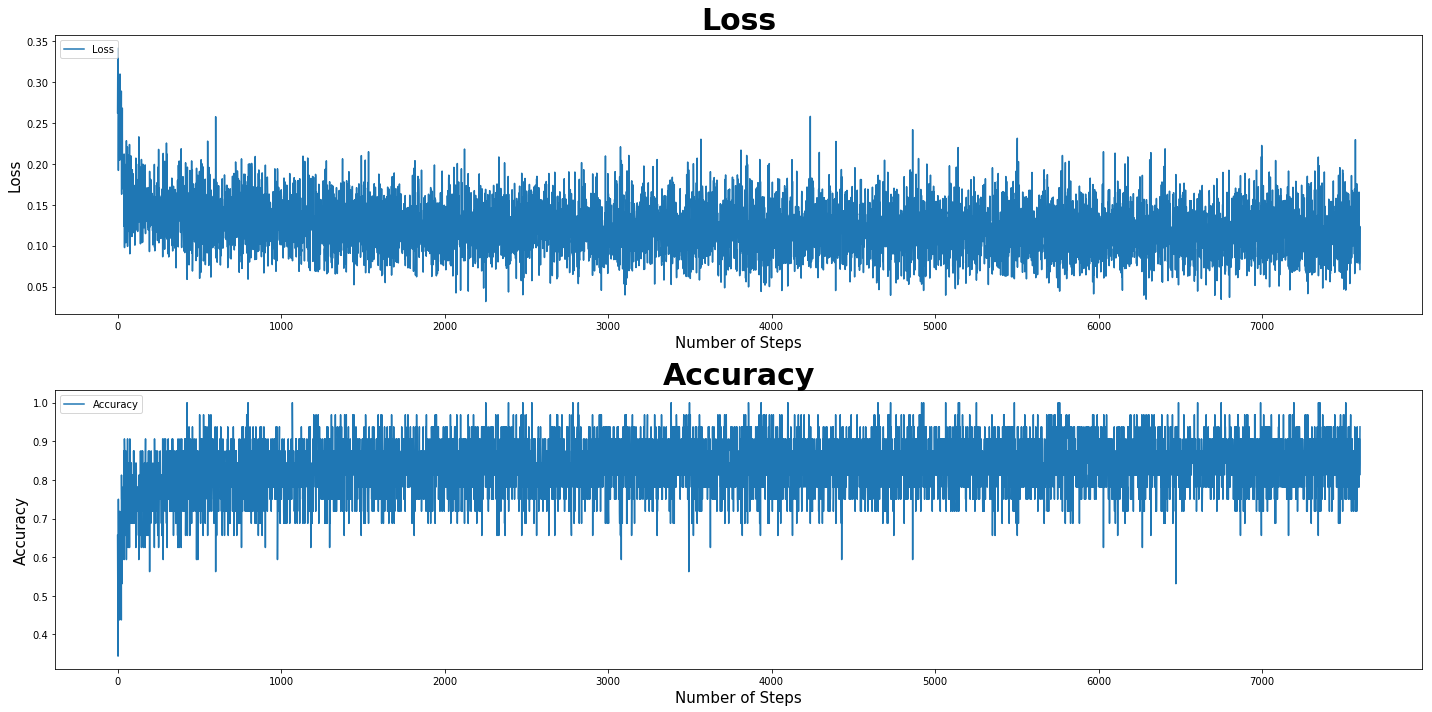

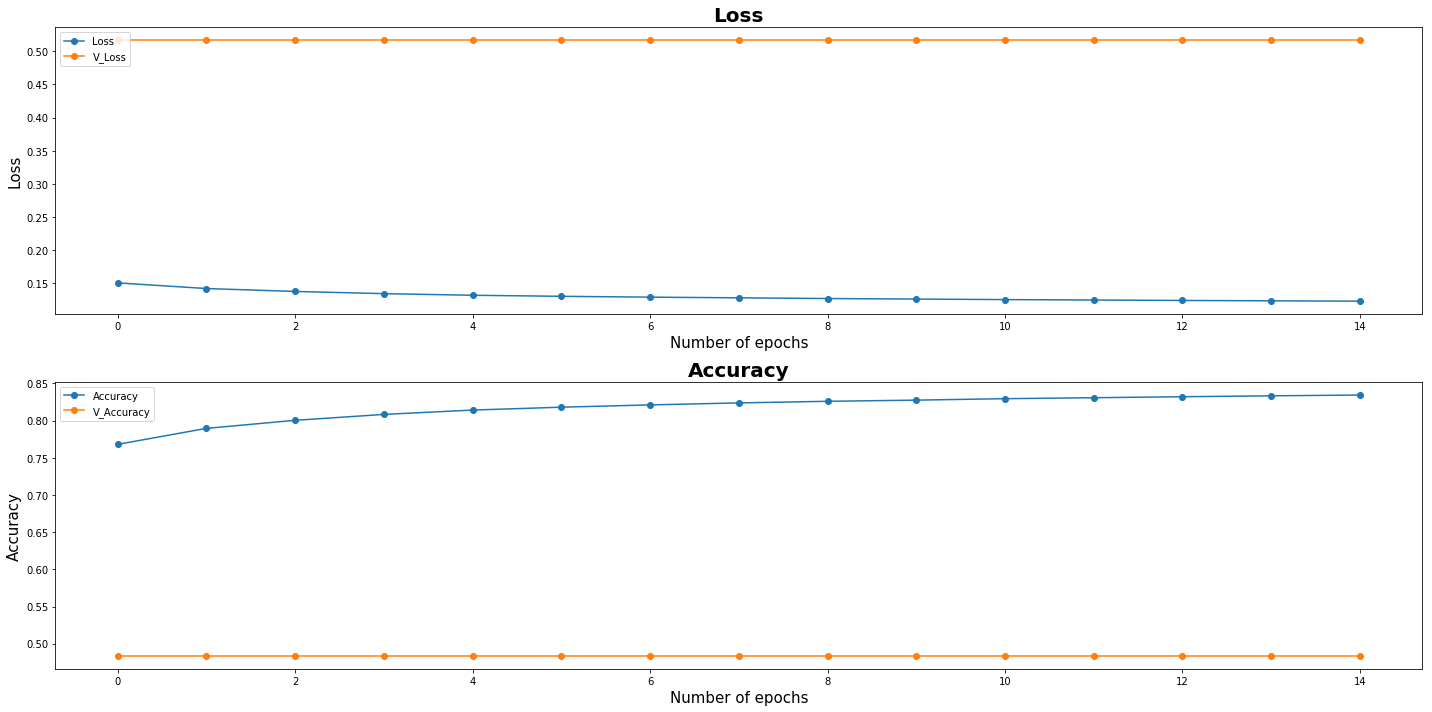

Model Saved
| Epoch [16] | Step [7601] | lr [0.000200] | Loss: [0.1291] | Acc: [0.8438] | Time: 0.1s
| Epoch [16] | Step [7602] | lr [0.000200] | Loss: [0.1743] | Acc: [0.7188] | Time: 0.1s
| Epoch [16] | Step [7603] | lr [0.000200] | Loss: [0.1345] | Acc: [0.8125] | Time: 0.1s
| Epoch [16] | Step [7604] | lr [0.000200] | Loss: [0.1967] | Acc: [0.6875] | Time: 0.1s
| Epoch [16] | Step [7605] | lr [0.000200] | Loss: [0.1249] | Acc: [0.8125] | Time: 0.1s
| Epoch [16] | Step [7606] | lr [0.000200] | Loss: [0.1323] | Acc: [0.8438] | Time: 0.1s
| Epoch [16] | Step [7607] | lr [0.000200] | Loss: [0.1262] | Acc: [0.8125] | Time: 0.1s
| Epoch [16] | Step [7608] | lr [0.000200] | Loss: [0.1286] | Acc: [0.8438] | Time: 0.1s
| Epoch [16] | Step [7609] | lr [0.000200] | Loss: [0.1611] | Acc: [0.7812] | Time: 0.1s
| Epoch [16] | Step [7610] | lr [0.000200] | Loss: [0.1234] | Acc: [0.8750] | Time: 0.1s
| Epoch [16] | Step [7611] | lr [0.000200] | Loss: [0.1114] | Acc: [0.9062] | Time: 0.1s
| Epoch [

| Epoch [16] | Step [7694] | lr [0.000200] | Loss: [0.1668] | Acc: [0.8125] | Time: 0.1s
| Epoch [16] | Step [7695] | lr [0.000200] | Loss: [0.0815] | Acc: [0.8438] | Time: 0.1s
| Epoch [16] | Step [7696] | lr [0.000200] | Loss: [0.0277] | Acc: [1.0000] | Time: 0.1s
| Epoch [16] | Step [7697] | lr [0.000200] | Loss: [0.1165] | Acc: [0.8438] | Time: 0.1s
| Epoch [16] | Step [7698] | lr [0.000200] | Loss: [0.1230] | Acc: [0.7812] | Time: 0.1s
| Epoch [16] | Step [7699] | lr [0.000200] | Loss: [0.1249] | Acc: [0.8438] | Time: 0.1s
| Epoch [16] | Step [7700] | lr [0.000200] | Loss: [0.0674] | Acc: [0.9688] | Time: 0.1s
| Epoch [16] | Step [7701] | lr [0.000200] | Loss: [0.0667] | Acc: [0.9062] | Time: 0.1s
| Epoch [16] | Step [7702] | lr [0.000200] | Loss: [0.0540] | Acc: [0.9688] | Time: 0.1s
| Epoch [16] | Step [7703] | lr [0.000200] | Loss: [0.1611] | Acc: [0.7188] | Time: 0.1s
| Epoch [16] | Step [7704] | lr [0.000200] | Loss: [0.1059] | Acc: [0.8750] | Time: 0.1s
| Epoch [16] | Step [

| Epoch [16] | Step [7788] | lr [0.000200] | Loss: [0.0789] | Acc: [0.9375] | Time: 0.1s
| Epoch [16] | Step [7789] | lr [0.000200] | Loss: [0.1298] | Acc: [0.8438] | Time: 0.1s
| Epoch [16] | Step [7790] | lr [0.000200] | Loss: [0.1396] | Acc: [0.7812] | Time: 0.1s
| Epoch [16] | Step [7791] | lr [0.000200] | Loss: [0.1457] | Acc: [0.8438] | Time: 0.1s
| Epoch [16] | Step [7792] | lr [0.000200] | Loss: [0.1360] | Acc: [0.8125] | Time: 0.1s
| Epoch [16] | Step [7793] | lr [0.000200] | Loss: [0.1623] | Acc: [0.7500] | Time: 0.1s
| Epoch [16] | Step [7794] | lr [0.000200] | Loss: [0.0889] | Acc: [0.9375] | Time: 0.1s
| Epoch [16] | Step [7795] | lr [0.000200] | Loss: [0.0986] | Acc: [0.8750] | Time: 0.1s
| Epoch [16] | Step [7796] | lr [0.000200] | Loss: [0.1175] | Acc: [0.8438] | Time: 0.1s
| Epoch [16] | Step [7797] | lr [0.000200] | Loss: [0.1232] | Acc: [0.8438] | Time: 0.1s
| Epoch [16] | Step [7798] | lr [0.000200] | Loss: [0.1408] | Acc: [0.7500] | Time: 0.1s
| Epoch [16] | Step [

| Epoch [16] | Step [7882] | lr [0.000200] | Loss: [0.1067] | Acc: [0.8438] | Time: 0.1s
| Epoch [16] | Step [7883] | lr [0.000200] | Loss: [0.1372] | Acc: [0.8438] | Time: 0.1s
| Epoch [16] | Step [7884] | lr [0.000200] | Loss: [0.0788] | Acc: [0.9375] | Time: 0.1s
| Epoch [16] | Step [7885] | lr [0.000200] | Loss: [0.1107] | Acc: [0.8750] | Time: 0.1s
| Epoch [16] | Step [7886] | lr [0.000200] | Loss: [0.1164] | Acc: [0.8438] | Time: 0.1s
| Epoch [16] | Step [7887] | lr [0.000200] | Loss: [0.1296] | Acc: [0.8125] | Time: 0.1s
| Epoch [16] | Step [7888] | lr [0.000200] | Loss: [0.1022] | Acc: [0.8750] | Time: 0.1s
| Epoch [16] | Step [7889] | lr [0.000200] | Loss: [0.1307] | Acc: [0.8125] | Time: 0.1s
| Epoch [16] | Step [7890] | lr [0.000200] | Loss: [0.0568] | Acc: [0.9375] | Time: 0.1s
| Epoch [16] | Step [7891] | lr [0.000200] | Loss: [0.0796] | Acc: [0.9062] | Time: 0.1s
| Epoch [16] | Step [7892] | lr [0.000200] | Loss: [0.1374] | Acc: [0.7812] | Time: 0.1s
| Epoch [16] | Step [

| Epoch [16] | Step [7976] | lr [0.000200] | Loss: [0.1603] | Acc: [0.8125] | Time: 0.1s
| Epoch [16] | Step [7977] | lr [0.000200] | Loss: [0.0919] | Acc: [0.9062] | Time: 0.1s
| Epoch [16] | Step [7978] | lr [0.000200] | Loss: [0.1623] | Acc: [0.6875] | Time: 0.1s
| Epoch [16] | Step [7979] | lr [0.000200] | Loss: [0.0946] | Acc: [0.8750] | Time: 0.1s
| Epoch [16] | Step [7980] | lr [0.000200] | Loss: [0.0757] | Acc: [0.9688] | Time: 0.1s
| Epoch [16] | Step [7981] | lr [0.000200] | Loss: [0.1482] | Acc: [0.8438] | Time: 0.1s
| Epoch [16] | Step [7982] | lr [0.000200] | Loss: [0.1531] | Acc: [0.7812] | Time: 0.1s
| Epoch [16] | Step [7983] | lr [0.000200] | Loss: [0.0988] | Acc: [0.9062] | Time: 0.1s
| Epoch [16] | Step [7984] | lr [0.000200] | Loss: [0.1061] | Acc: [0.8750] | Time: 0.1s
| Epoch [16] | Step [7985] | lr [0.000200] | Loss: [0.0811] | Acc: [0.9062] | Time: 0.1s
| Epoch [16] | Step [7986] | lr [0.000200] | Loss: [0.1453] | Acc: [0.8438] | Time: 0.1s
| Epoch [16] | Step [

| Epoch [16] | Step [8070] | lr [0.000200] | Loss: [0.0370] | Acc: [1.0000] | Time: 0.1s
| Epoch [16] | Step [8071] | lr [0.000200] | Loss: [0.0941] | Acc: [0.8750] | Time: 0.1s
| Epoch [16] | Step [8072] | lr [0.000200] | Loss: [0.1081] | Acc: [0.8438] | Time: 0.1s
| Epoch [16] | Step [8073] | lr [0.000200] | Loss: [0.1119] | Acc: [0.9062] | Time: 0.1s
| Epoch [16] | Step [8074] | lr [0.000200] | Loss: [0.1079] | Acc: [0.8438] | Time: 0.1s
| Epoch [16] | Step [8075] | lr [0.000200] | Loss: [0.1145] | Acc: [0.8438] | Time: 0.1s
| Epoch [16] | Validation | Step [0] |  Loss: [0.4688] | Acc: [0.5312] | Time: 0.0s
| Epoch [16] | Validation | Step [1] |  Loss: [0.5312] | Acc: [0.4688] | Time: 0.0s
| Epoch [16] | Validation | Step [2] |  Loss: [0.5938] | Acc: [0.4062] | Time: 0.0s
| Epoch [16] | Validation | Step [3] |  Loss: [0.4062] | Acc: [0.5938] | Time: 0.0s
| Epoch [16] | Validation | Step [4] |  Loss: [0.4062] | Acc: [0.5938] | Time: 0.0s
| Epoch [16] | Validation | Step [5] |  Loss: 

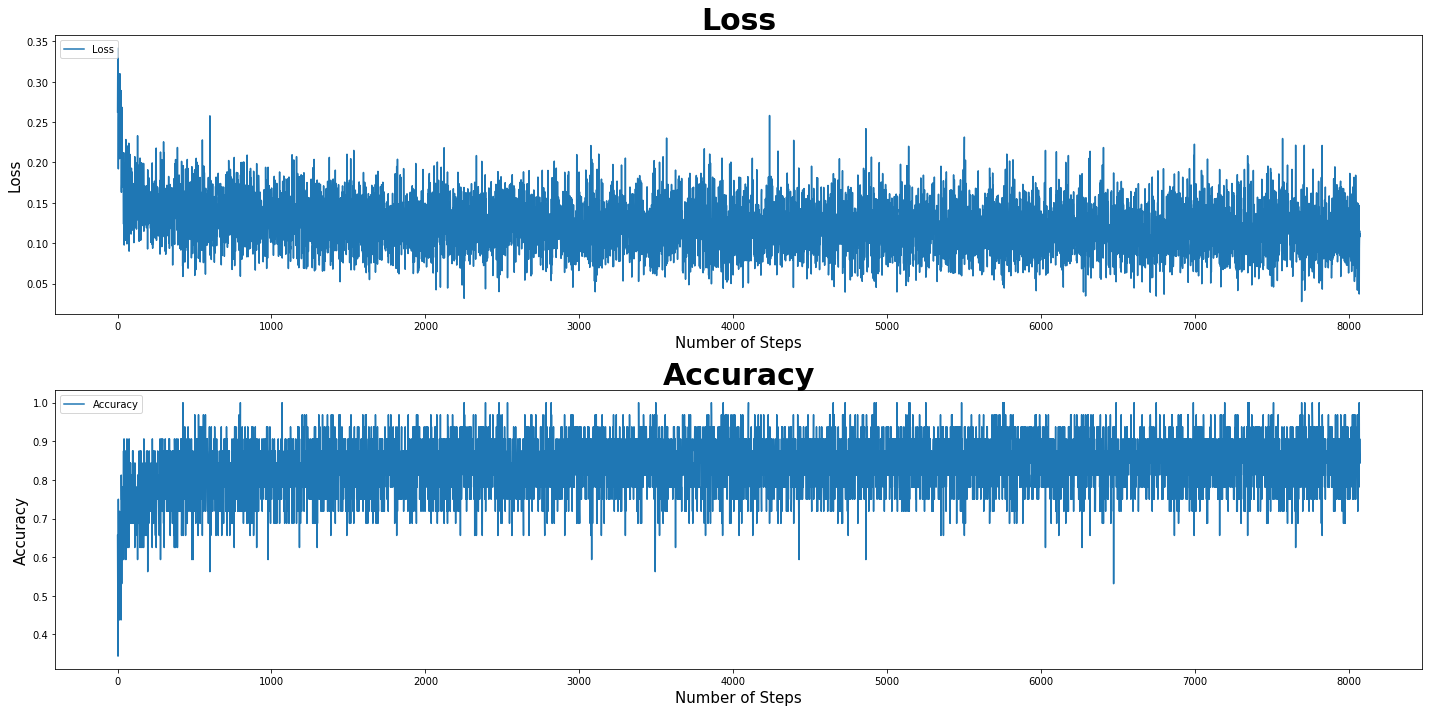

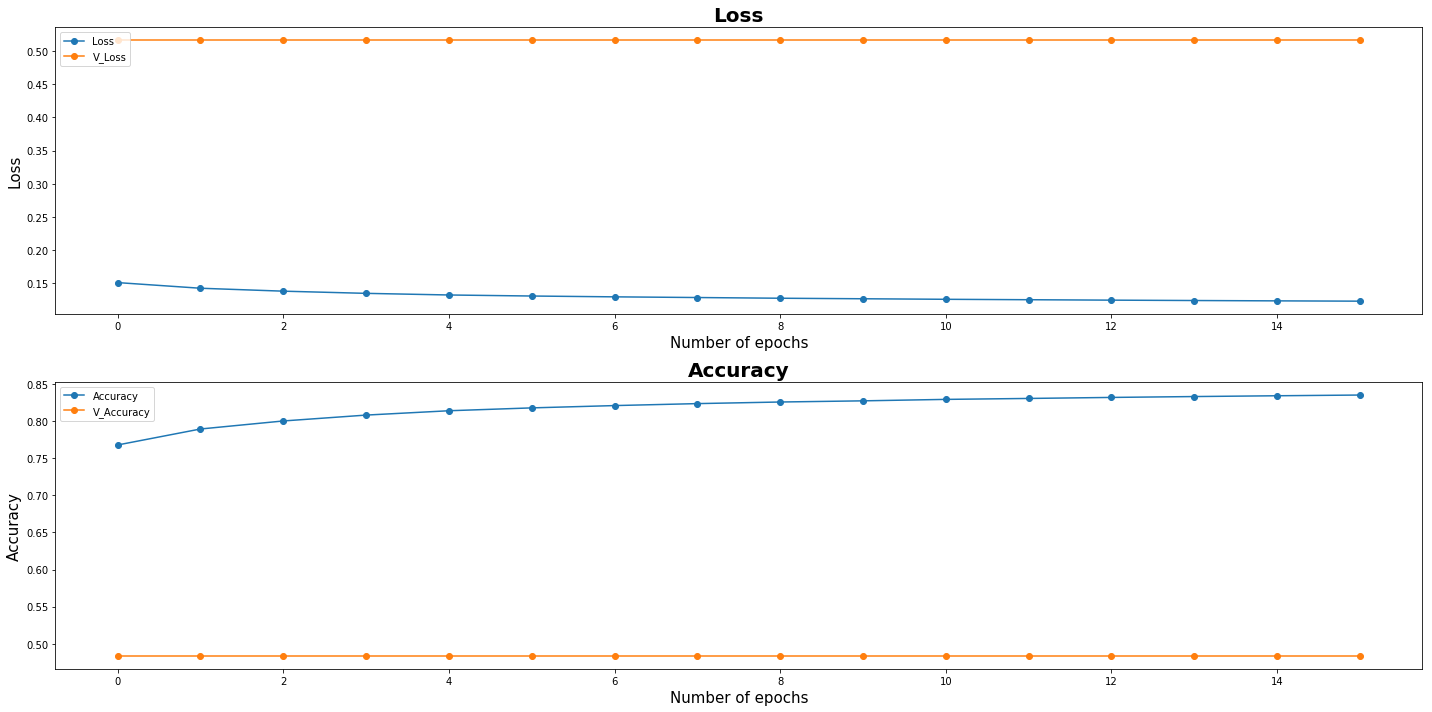

Model Saved
| Epoch [17] | Step [8076] | lr [0.000200] | Loss: [0.0922] | Acc: [0.9062] | Time: 0.1s
| Epoch [17] | Step [8077] | lr [0.000200] | Loss: [0.1246] | Acc: [0.8438] | Time: 0.1s
| Epoch [17] | Step [8078] | lr [0.000200] | Loss: [0.1088] | Acc: [0.8125] | Time: 0.1s
| Epoch [17] | Step [8079] | lr [0.000200] | Loss: [0.1164] | Acc: [0.8750] | Time: 0.1s
| Epoch [17] | Step [8080] | lr [0.000200] | Loss: [0.1420] | Acc: [0.7812] | Time: 0.1s
| Epoch [17] | Step [8081] | lr [0.000200] | Loss: [0.1149] | Acc: [0.8750] | Time: 0.1s
| Epoch [17] | Step [8082] | lr [0.000200] | Loss: [0.1419] | Acc: [0.8125] | Time: 0.1s
| Epoch [17] | Step [8083] | lr [0.000200] | Loss: [0.0944] | Acc: [0.9062] | Time: 0.1s
| Epoch [17] | Step [8084] | lr [0.000200] | Loss: [0.0955] | Acc: [0.9062] | Time: 0.1s
| Epoch [17] | Step [8085] | lr [0.000200] | Loss: [0.0706] | Acc: [0.9375] | Time: 0.1s
| Epoch [17] | Step [8086] | lr [0.000200] | Loss: [0.1298] | Acc: [0.7500] | Time: 0.1s
| Epoch [

| Epoch [17] | Step [8169] | lr [0.000200] | Loss: [0.0857] | Acc: [0.9062] | Time: 0.1s
| Epoch [17] | Step [8170] | lr [0.000200] | Loss: [0.0860] | Acc: [0.9375] | Time: 0.1s
| Epoch [17] | Step [8171] | lr [0.000200] | Loss: [0.1392] | Acc: [0.7812] | Time: 0.1s
| Epoch [17] | Step [8172] | lr [0.000200] | Loss: [0.0935] | Acc: [0.8750] | Time: 0.1s
| Epoch [17] | Step [8173] | lr [0.000200] | Loss: [0.0536] | Acc: [0.9688] | Time: 0.1s
| Epoch [17] | Step [8174] | lr [0.000200] | Loss: [0.0958] | Acc: [0.8750] | Time: 0.1s
| Epoch [17] | Step [8175] | lr [0.000200] | Loss: [0.1144] | Acc: [0.9062] | Time: 0.1s
| Epoch [17] | Step [8176] | lr [0.000200] | Loss: [0.1328] | Acc: [0.7812] | Time: 0.1s
| Epoch [17] | Step [8177] | lr [0.000200] | Loss: [0.1289] | Acc: [0.8438] | Time: 0.1s
| Epoch [17] | Step [8178] | lr [0.000200] | Loss: [0.0773] | Acc: [0.9062] | Time: 0.1s
| Epoch [17] | Step [8179] | lr [0.000200] | Loss: [0.1602] | Acc: [0.8125] | Time: 0.1s
| Epoch [17] | Step [

| Epoch [17] | Step [8263] | lr [0.000200] | Loss: [0.0746] | Acc: [0.8750] | Time: 0.1s
| Epoch [17] | Step [8264] | lr [0.000200] | Loss: [0.0890] | Acc: [0.9062] | Time: 0.1s
| Epoch [17] | Step [8265] | lr [0.000200] | Loss: [0.1389] | Acc: [0.7812] | Time: 0.1s
| Epoch [17] | Step [8266] | lr [0.000200] | Loss: [0.1131] | Acc: [0.8750] | Time: 0.1s
| Epoch [17] | Step [8267] | lr [0.000200] | Loss: [0.1026] | Acc: [0.8750] | Time: 0.1s
| Epoch [17] | Step [8268] | lr [0.000200] | Loss: [0.1232] | Acc: [0.8438] | Time: 0.1s
| Epoch [17] | Step [8269] | lr [0.000200] | Loss: [0.1300] | Acc: [0.8125] | Time: 0.1s
| Epoch [17] | Step [8270] | lr [0.000200] | Loss: [0.1249] | Acc: [0.8438] | Time: 0.1s
| Epoch [17] | Step [8271] | lr [0.000200] | Loss: [0.1414] | Acc: [0.7500] | Time: 0.1s
| Epoch [17] | Step [8272] | lr [0.000200] | Loss: [0.1583] | Acc: [0.8125] | Time: 0.1s
| Epoch [17] | Step [8273] | lr [0.000200] | Loss: [0.1260] | Acc: [0.7812] | Time: 0.1s
| Epoch [17] | Step [

| Epoch [17] | Step [8357] | lr [0.000200] | Loss: [0.1394] | Acc: [0.7812] | Time: 0.1s
| Epoch [17] | Step [8358] | lr [0.000200] | Loss: [0.1041] | Acc: [0.9062] | Time: 0.1s
| Epoch [17] | Step [8359] | lr [0.000200] | Loss: [0.1111] | Acc: [0.7812] | Time: 0.1s
| Epoch [17] | Step [8360] | lr [0.000200] | Loss: [0.1257] | Acc: [0.8438] | Time: 0.1s
| Epoch [17] | Step [8361] | lr [0.000200] | Loss: [0.1317] | Acc: [0.8750] | Time: 0.1s
| Epoch [17] | Step [8362] | lr [0.000200] | Loss: [0.1154] | Acc: [0.8438] | Time: 0.1s
| Epoch [17] | Step [8363] | lr [0.000200] | Loss: [0.1005] | Acc: [0.8750] | Time: 0.1s
| Epoch [17] | Step [8364] | lr [0.000200] | Loss: [0.0830] | Acc: [0.9375] | Time: 0.1s
| Epoch [17] | Step [8365] | lr [0.000200] | Loss: [0.1287] | Acc: [0.8438] | Time: 0.1s
| Epoch [17] | Step [8366] | lr [0.000200] | Loss: [0.1647] | Acc: [0.7812] | Time: 0.1s
| Epoch [17] | Step [8367] | lr [0.000200] | Loss: [0.1729] | Acc: [0.8438] | Time: 0.1s
| Epoch [17] | Step [

| Epoch [17] | Step [8451] | lr [0.000200] | Loss: [0.0845] | Acc: [0.9062] | Time: 0.1s
| Epoch [17] | Step [8452] | lr [0.000200] | Loss: [0.1596] | Acc: [0.7812] | Time: 0.1s
| Epoch [17] | Step [8453] | lr [0.000200] | Loss: [0.0937] | Acc: [0.8125] | Time: 0.1s
| Epoch [17] | Step [8454] | lr [0.000200] | Loss: [0.0602] | Acc: [0.9375] | Time: 0.1s
| Epoch [17] | Step [8455] | lr [0.000200] | Loss: [0.1228] | Acc: [0.9062] | Time: 0.1s
| Epoch [17] | Step [8456] | lr [0.000200] | Loss: [0.1134] | Acc: [0.8750] | Time: 0.1s
| Epoch [17] | Step [8457] | lr [0.000200] | Loss: [0.0973] | Acc: [0.8438] | Time: 0.1s
| Epoch [17] | Step [8458] | lr [0.000200] | Loss: [0.0823] | Acc: [0.9375] | Time: 0.1s
| Epoch [17] | Step [8459] | lr [0.000200] | Loss: [0.1949] | Acc: [0.7188] | Time: 0.1s
| Epoch [17] | Step [8460] | lr [0.000200] | Loss: [0.1294] | Acc: [0.8125] | Time: 0.1s
| Epoch [17] | Step [8461] | lr [0.000200] | Loss: [0.1436] | Acc: [0.8125] | Time: 0.1s
| Epoch [17] | Step [

| Epoch [17] | Step [8545] | lr [0.000200] | Loss: [0.1201] | Acc: [0.8438] | Time: 0.1s
| Epoch [17] | Step [8546] | lr [0.000200] | Loss: [0.1504] | Acc: [0.7812] | Time: 0.1s
| Epoch [17] | Step [8547] | lr [0.000200] | Loss: [0.1085] | Acc: [0.8750] | Time: 0.1s
| Epoch [17] | Step [8548] | lr [0.000200] | Loss: [0.1161] | Acc: [0.8125] | Time: 0.1s
| Epoch [17] | Step [8549] | lr [0.000200] | Loss: [0.1214] | Acc: [0.8438] | Time: 0.1s
| Epoch [17] | Step [8550] | lr [0.000200] | Loss: [0.0889] | Acc: [0.9375] | Time: 0.1s
| Epoch [17] | Validation | Step [0] |  Loss: [0.4688] | Acc: [0.5312] | Time: 0.0s
| Epoch [17] | Validation | Step [1] |  Loss: [0.5625] | Acc: [0.4375] | Time: 0.0s
| Epoch [17] | Validation | Step [2] |  Loss: [0.5000] | Acc: [0.5000] | Time: 0.0s
| Epoch [17] | Validation | Step [3] |  Loss: [0.5625] | Acc: [0.4375] | Time: 0.0s
| Epoch [17] | Validation | Step [4] |  Loss: [0.5000] | Acc: [0.5000] | Time: 0.0s
| Epoch [17] | Validation | Step [5] |  Loss: 

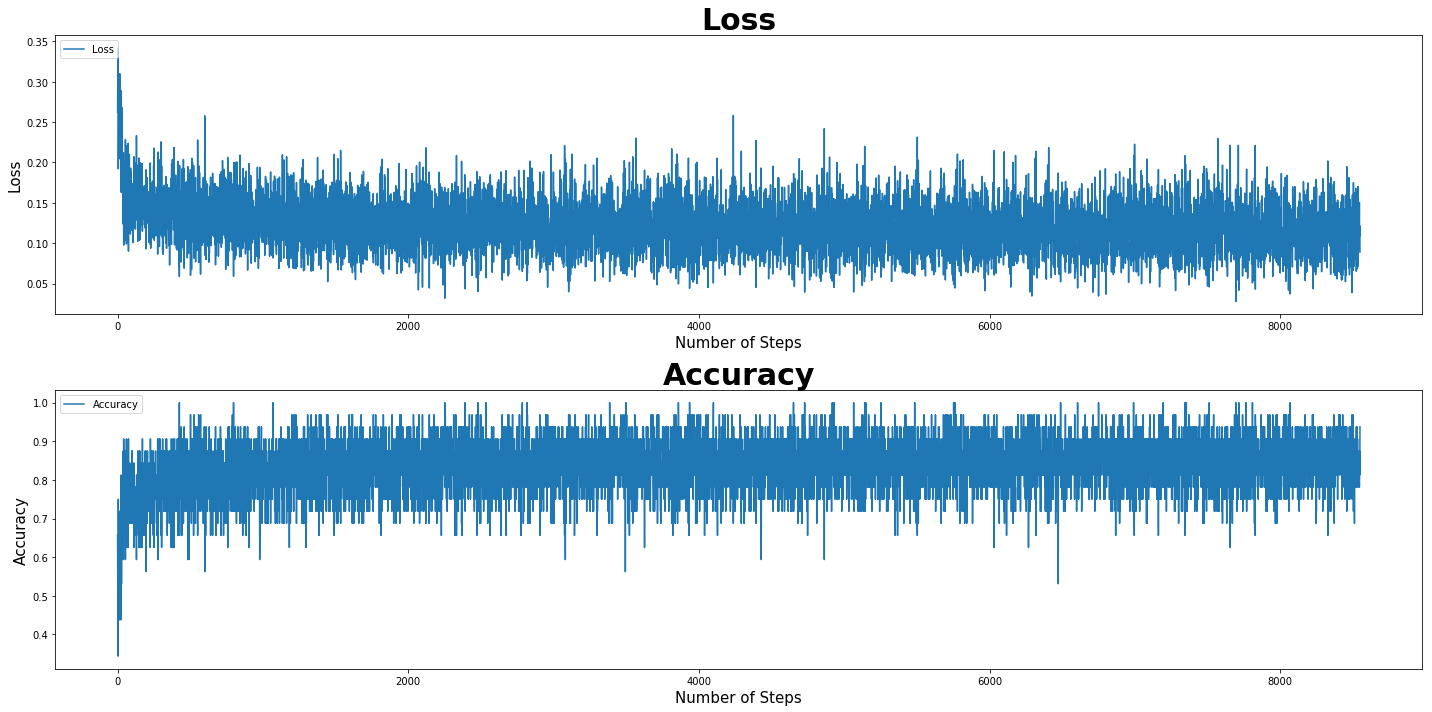

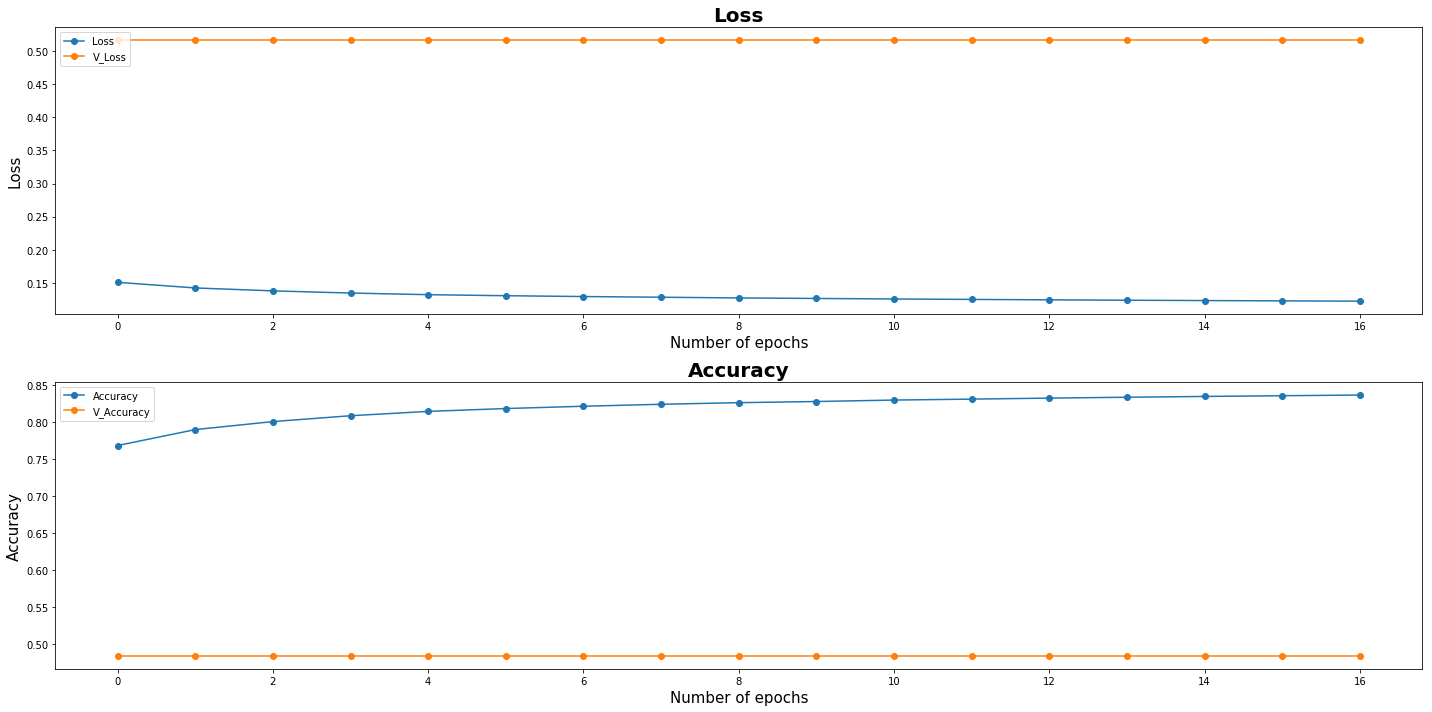

Model Saved
| Epoch [18] | Step [8551] | lr [0.000200] | Loss: [0.1514] | Acc: [0.7500] | Time: 0.1s
| Epoch [18] | Step [8552] | lr [0.000200] | Loss: [0.1507] | Acc: [0.7812] | Time: 0.1s
| Epoch [18] | Step [8553] | lr [0.000200] | Loss: [0.0883] | Acc: [0.9062] | Time: 0.1s
| Epoch [18] | Step [8554] | lr [0.000200] | Loss: [0.0922] | Acc: [0.8438] | Time: 0.1s
| Epoch [18] | Step [8555] | lr [0.000200] | Loss: [0.0844] | Acc: [0.9375] | Time: 0.1s
| Epoch [18] | Step [8556] | lr [0.000200] | Loss: [0.1602] | Acc: [0.7500] | Time: 0.1s
| Epoch [18] | Step [8557] | lr [0.000200] | Loss: [0.1070] | Acc: [0.8125] | Time: 0.1s
| Epoch [18] | Step [8558] | lr [0.000200] | Loss: [0.0855] | Acc: [0.9062] | Time: 0.1s
| Epoch [18] | Step [8559] | lr [0.000200] | Loss: [0.1230] | Acc: [0.8125] | Time: 0.1s
| Epoch [18] | Step [8560] | lr [0.000200] | Loss: [0.0771] | Acc: [0.9375] | Time: 0.1s
| Epoch [18] | Step [8561] | lr [0.000200] | Loss: [0.0906] | Acc: [0.8750] | Time: 0.1s
| Epoch [

| Epoch [18] | Step [8644] | lr [0.000200] | Loss: [0.0671] | Acc: [0.9688] | Time: 0.1s
| Epoch [18] | Step [8645] | lr [0.000200] | Loss: [0.1249] | Acc: [0.9062] | Time: 0.1s
| Epoch [18] | Step [8646] | lr [0.000200] | Loss: [0.1218] | Acc: [0.8438] | Time: 0.1s
| Epoch [18] | Step [8647] | lr [0.000200] | Loss: [0.0938] | Acc: [0.8438] | Time: 0.1s
| Epoch [18] | Step [8648] | lr [0.000200] | Loss: [0.1256] | Acc: [0.8125] | Time: 0.1s
| Epoch [18] | Step [8649] | lr [0.000200] | Loss: [0.0878] | Acc: [0.9062] | Time: 0.1s
| Epoch [18] | Step [8650] | lr [0.000200] | Loss: [0.0910] | Acc: [0.8438] | Time: 0.1s
| Epoch [18] | Step [8651] | lr [0.000200] | Loss: [0.1132] | Acc: [0.8125] | Time: 0.1s
| Epoch [18] | Step [8652] | lr [0.000200] | Loss: [0.1138] | Acc: [0.8125] | Time: 0.1s
| Epoch [18] | Step [8653] | lr [0.000200] | Loss: [0.1406] | Acc: [0.7812] | Time: 0.1s
| Epoch [18] | Step [8654] | lr [0.000200] | Loss: [0.1038] | Acc: [0.9062] | Time: 0.1s
| Epoch [18] | Step [

| Epoch [18] | Step [8738] | lr [0.000200] | Loss: [0.1284] | Acc: [0.8125] | Time: 0.1s
| Epoch [18] | Step [8739] | lr [0.000200] | Loss: [0.0865] | Acc: [0.8750] | Time: 0.1s
| Epoch [18] | Step [8740] | lr [0.000200] | Loss: [0.1634] | Acc: [0.7500] | Time: 0.1s
| Epoch [18] | Step [8741] | lr [0.000200] | Loss: [0.1190] | Acc: [0.8125] | Time: 0.1s
| Epoch [18] | Step [8742] | lr [0.000200] | Loss: [0.1056] | Acc: [0.9375] | Time: 0.1s
| Epoch [18] | Step [8743] | lr [0.000200] | Loss: [0.0612] | Acc: [0.9688] | Time: 0.1s
| Epoch [18] | Step [8744] | lr [0.000200] | Loss: [0.0915] | Acc: [0.8750] | Time: 0.1s
| Epoch [18] | Step [8745] | lr [0.000200] | Loss: [0.0787] | Acc: [0.8750] | Time: 0.1s
| Epoch [18] | Step [8746] | lr [0.000200] | Loss: [0.1072] | Acc: [0.8750] | Time: 0.1s
| Epoch [18] | Step [8747] | lr [0.000200] | Loss: [0.1518] | Acc: [0.6875] | Time: 0.1s
| Epoch [18] | Step [8748] | lr [0.000200] | Loss: [0.0609] | Acc: [0.9062] | Time: 0.1s
| Epoch [18] | Step [

| Epoch [18] | Step [8832] | lr [0.000200] | Loss: [0.1754] | Acc: [0.7500] | Time: 0.1s
| Epoch [18] | Step [8833] | lr [0.000200] | Loss: [0.0943] | Acc: [0.9375] | Time: 0.1s
| Epoch [18] | Step [8834] | lr [0.000200] | Loss: [0.1350] | Acc: [0.8438] | Time: 0.1s
| Epoch [18] | Step [8835] | lr [0.000200] | Loss: [0.1136] | Acc: [0.9375] | Time: 0.1s
| Epoch [18] | Step [8836] | lr [0.000200] | Loss: [0.1463] | Acc: [0.8125] | Time: 0.1s
| Epoch [18] | Step [8837] | lr [0.000200] | Loss: [0.1233] | Acc: [0.8125] | Time: 0.1s
| Epoch [18] | Step [8838] | lr [0.000200] | Loss: [0.1356] | Acc: [0.7500] | Time: 0.1s
| Epoch [18] | Step [8839] | lr [0.000200] | Loss: [0.0824] | Acc: [0.9062] | Time: 0.1s
| Epoch [18] | Step [8840] | lr [0.000200] | Loss: [0.0882] | Acc: [0.9062] | Time: 0.1s
| Epoch [18] | Step [8841] | lr [0.000200] | Loss: [0.1135] | Acc: [0.9062] | Time: 0.1s
| Epoch [18] | Step [8842] | lr [0.000200] | Loss: [0.0832] | Acc: [0.8750] | Time: 0.1s
| Epoch [18] | Step [

| Epoch [18] | Step [8926] | lr [0.000200] | Loss: [0.1108] | Acc: [0.8438] | Time: 0.1s
| Epoch [18] | Step [8927] | lr [0.000200] | Loss: [0.0990] | Acc: [0.8438] | Time: 0.1s
| Epoch [18] | Step [8928] | lr [0.000200] | Loss: [0.1290] | Acc: [0.8750] | Time: 0.1s
| Epoch [18] | Step [8929] | lr [0.000200] | Loss: [0.1213] | Acc: [0.8750] | Time: 0.1s
| Epoch [18] | Step [8930] | lr [0.000200] | Loss: [0.0722] | Acc: [0.9062] | Time: 0.1s
| Epoch [18] | Step [8931] | lr [0.000200] | Loss: [0.0935] | Acc: [0.8438] | Time: 0.1s
| Epoch [18] | Step [8932] | lr [0.000200] | Loss: [0.1094] | Acc: [0.8125] | Time: 0.1s
| Epoch [18] | Step [8933] | lr [0.000200] | Loss: [0.0472] | Acc: [0.9375] | Time: 0.1s
| Epoch [18] | Step [8934] | lr [0.000200] | Loss: [0.0862] | Acc: [0.9062] | Time: 0.1s
| Epoch [18] | Step [8935] | lr [0.000200] | Loss: [0.1202] | Acc: [0.8438] | Time: 0.1s
| Epoch [18] | Step [8936] | lr [0.000200] | Loss: [0.0411] | Acc: [0.9688] | Time: 0.1s
| Epoch [18] | Step [

| Epoch [18] | Step [9020] | lr [0.000200] | Loss: [0.1268] | Acc: [0.8438] | Time: 0.1s
| Epoch [18] | Step [9021] | lr [0.000200] | Loss: [0.0982] | Acc: [0.8750] | Time: 0.1s
| Epoch [18] | Step [9022] | lr [0.000200] | Loss: [0.1297] | Acc: [0.8438] | Time: 0.1s
| Epoch [18] | Step [9023] | lr [0.000200] | Loss: [0.0978] | Acc: [0.8750] | Time: 0.1s
| Epoch [18] | Step [9024] | lr [0.000200] | Loss: [0.1260] | Acc: [0.8438] | Time: 0.1s
| Epoch [18] | Step [9025] | lr [0.000200] | Loss: [0.1053] | Acc: [0.8750] | Time: 0.1s
| Epoch [18] | Validation | Step [0] |  Loss: [0.5625] | Acc: [0.4375] | Time: 0.0s
| Epoch [18] | Validation | Step [1] |  Loss: [0.5312] | Acc: [0.4688] | Time: 0.0s
| Epoch [18] | Validation | Step [2] |  Loss: [0.4688] | Acc: [0.5312] | Time: 0.0s
| Epoch [18] | Validation | Step [3] |  Loss: [0.5000] | Acc: [0.5000] | Time: 0.0s
| Epoch [18] | Validation | Step [4] |  Loss: [0.5625] | Acc: [0.4375] | Time: 0.0s
| Epoch [18] | Validation | Step [5] |  Loss: 

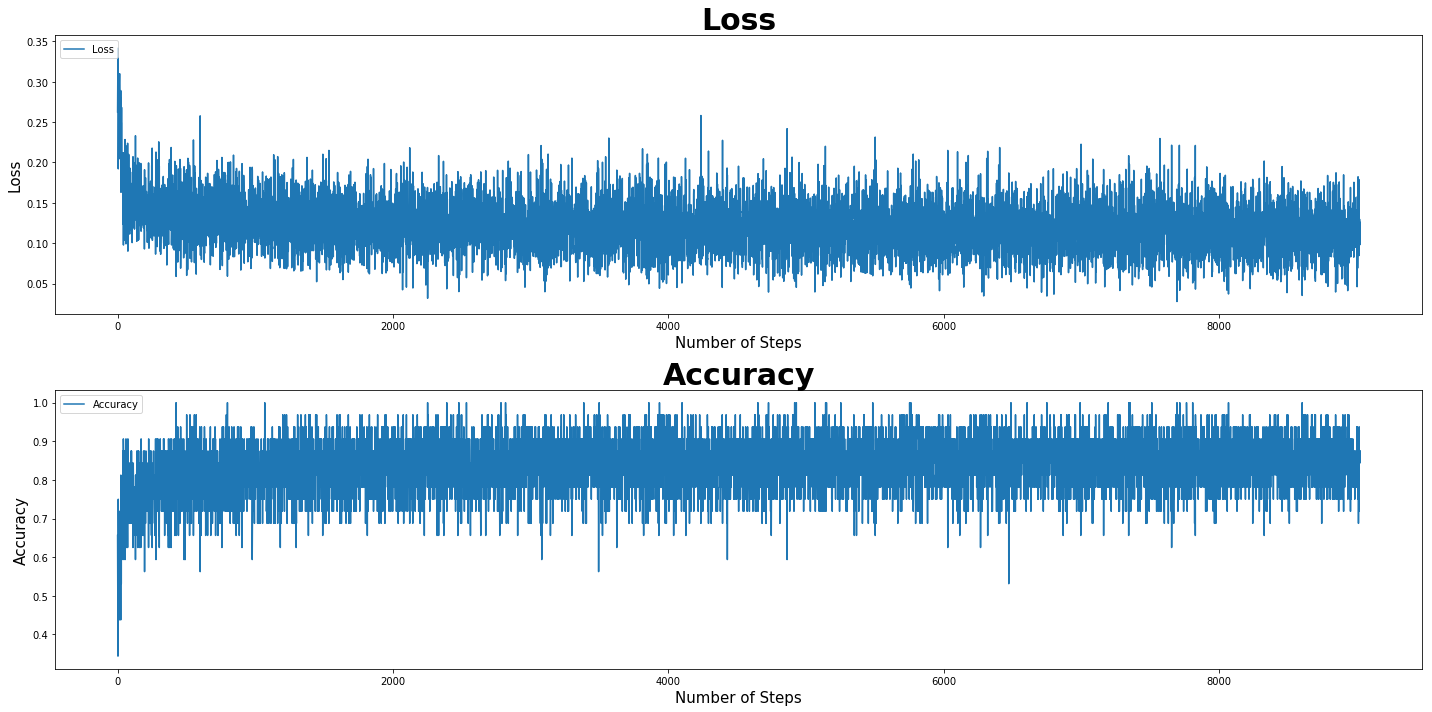

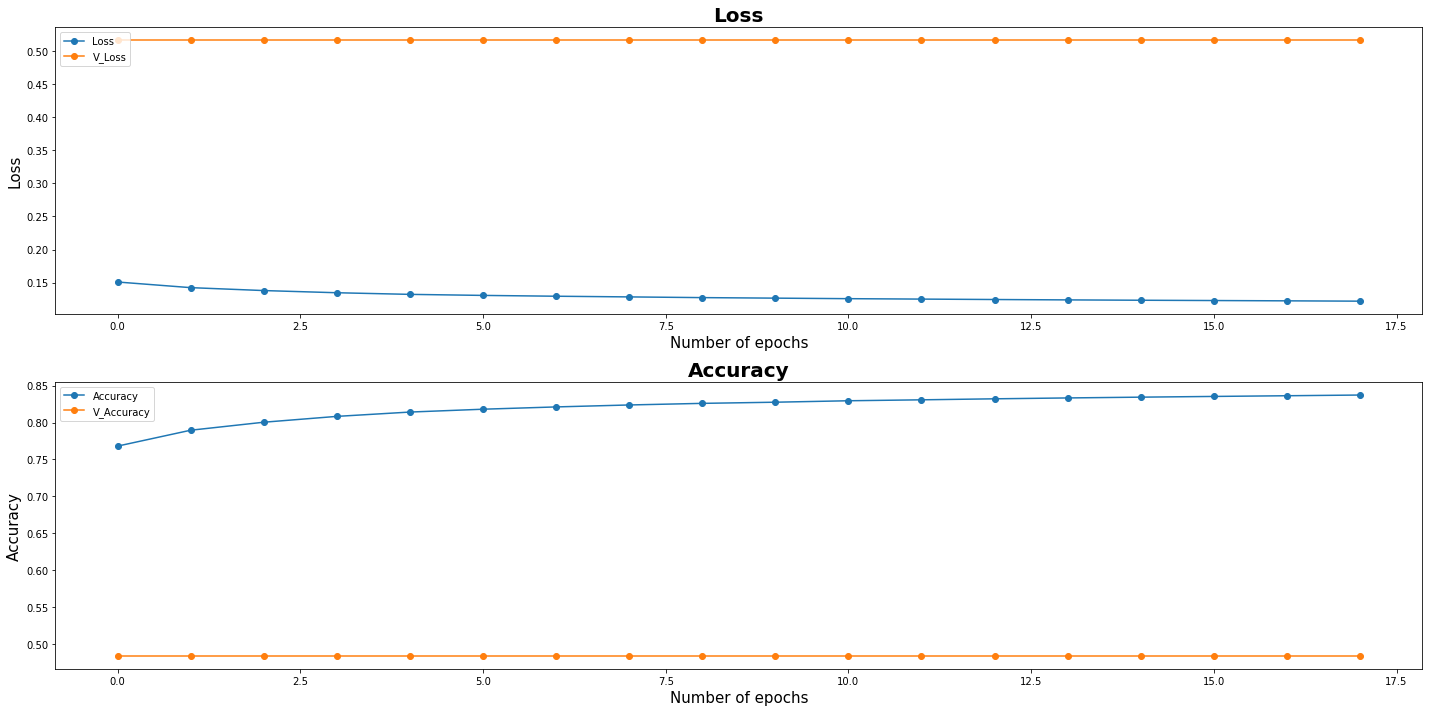

Model Saved
| Epoch [19] | Step [9026] | lr [0.000200] | Loss: [0.1068] | Acc: [0.8438] | Time: 0.1s
| Epoch [19] | Step [9027] | lr [0.000200] | Loss: [0.1351] | Acc: [0.7812] | Time: 0.1s
| Epoch [19] | Step [9028] | lr [0.000200] | Loss: [0.1237] | Acc: [0.8125] | Time: 0.1s
| Epoch [19] | Step [9029] | lr [0.000200] | Loss: [0.0574] | Acc: [0.9375] | Time: 0.1s
| Epoch [19] | Step [9030] | lr [0.000200] | Loss: [0.1584] | Acc: [0.7188] | Time: 0.1s
| Epoch [19] | Step [9031] | lr [0.000200] | Loss: [0.1412] | Acc: [0.8125] | Time: 0.1s
| Epoch [19] | Step [9032] | lr [0.000200] | Loss: [0.1373] | Acc: [0.8438] | Time: 0.1s
| Epoch [19] | Step [9033] | lr [0.000200] | Loss: [0.0662] | Acc: [0.9688] | Time: 0.1s
| Epoch [19] | Step [9034] | lr [0.000200] | Loss: [0.0983] | Acc: [0.7812] | Time: 0.1s
| Epoch [19] | Step [9035] | lr [0.000200] | Loss: [0.1066] | Acc: [0.9062] | Time: 0.1s
| Epoch [19] | Step [9036] | lr [0.000200] | Loss: [0.0817] | Acc: [0.9375] | Time: 0.1s
| Epoch [

| Epoch [19] | Step [9119] | lr [0.000200] | Loss: [0.1008] | Acc: [0.9062] | Time: 0.1s
| Epoch [19] | Step [9120] | lr [0.000200] | Loss: [0.1556] | Acc: [0.8125] | Time: 0.1s
| Epoch [19] | Step [9121] | lr [0.000200] | Loss: [0.1532] | Acc: [0.8438] | Time: 0.1s
| Epoch [19] | Step [9122] | lr [0.000200] | Loss: [0.1074] | Acc: [0.8750] | Time: 0.1s
| Epoch [19] | Step [9123] | lr [0.000200] | Loss: [0.1477] | Acc: [0.7188] | Time: 0.1s
| Epoch [19] | Step [9124] | lr [0.000200] | Loss: [0.0690] | Acc: [0.9375] | Time: 0.1s
| Epoch [19] | Step [9125] | lr [0.000200] | Loss: [0.1452] | Acc: [0.7812] | Time: 0.1s
| Epoch [19] | Step [9126] | lr [0.000200] | Loss: [0.0740] | Acc: [0.9375] | Time: 0.1s
| Epoch [19] | Step [9127] | lr [0.000200] | Loss: [0.1577] | Acc: [0.7500] | Time: 0.1s
| Epoch [19] | Step [9128] | lr [0.000200] | Loss: [0.1028] | Acc: [0.8750] | Time: 0.1s
| Epoch [19] | Step [9129] | lr [0.000200] | Loss: [0.0997] | Acc: [0.9062] | Time: 0.1s
| Epoch [19] | Step [

| Epoch [19] | Step [9213] | lr [0.000200] | Loss: [0.1548] | Acc: [0.7812] | Time: 0.1s
| Epoch [19] | Step [9214] | lr [0.000200] | Loss: [0.1014] | Acc: [0.9062] | Time: 0.1s
| Epoch [19] | Step [9215] | lr [0.000200] | Loss: [0.1423] | Acc: [0.8125] | Time: 0.1s
| Epoch [19] | Step [9216] | lr [0.000200] | Loss: [0.1415] | Acc: [0.8438] | Time: 0.1s
| Epoch [19] | Step [9217] | lr [0.000200] | Loss: [0.1318] | Acc: [0.8125] | Time: 0.1s
| Epoch [19] | Step [9218] | lr [0.000200] | Loss: [0.0701] | Acc: [0.9375] | Time: 0.1s
| Epoch [19] | Step [9219] | lr [0.000200] | Loss: [0.0855] | Acc: [0.8750] | Time: 0.1s
| Epoch [19] | Step [9220] | lr [0.000200] | Loss: [0.1019] | Acc: [0.8750] | Time: 0.1s
| Epoch [19] | Step [9221] | lr [0.000200] | Loss: [0.1165] | Acc: [0.8438] | Time: 0.1s
| Epoch [19] | Step [9222] | lr [0.000200] | Loss: [0.1192] | Acc: [0.8438] | Time: 0.1s
| Epoch [19] | Step [9223] | lr [0.000200] | Loss: [0.1027] | Acc: [0.8750] | Time: 0.1s
| Epoch [19] | Step [

| Epoch [19] | Step [9307] | lr [0.000200] | Loss: [0.1081] | Acc: [0.8750] | Time: 0.1s
| Epoch [19] | Step [9308] | lr [0.000200] | Loss: [0.1030] | Acc: [0.8750] | Time: 0.1s
| Epoch [19] | Step [9309] | lr [0.000200] | Loss: [0.0677] | Acc: [1.0000] | Time: 0.1s
| Epoch [19] | Step [9310] | lr [0.000200] | Loss: [0.1068] | Acc: [0.8750] | Time: 0.1s
| Epoch [19] | Step [9311] | lr [0.000200] | Loss: [0.0593] | Acc: [0.9375] | Time: 0.1s
| Epoch [19] | Step [9312] | lr [0.000200] | Loss: [0.0995] | Acc: [0.9375] | Time: 0.1s
| Epoch [19] | Step [9313] | lr [0.000200] | Loss: [0.1143] | Acc: [0.8750] | Time: 0.1s
| Epoch [19] | Step [9314] | lr [0.000200] | Loss: [0.1481] | Acc: [0.7500] | Time: 0.1s
| Epoch [19] | Step [9315] | lr [0.000200] | Loss: [0.0950] | Acc: [0.9375] | Time: 0.1s
| Epoch [19] | Step [9316] | lr [0.000200] | Loss: [0.1906] | Acc: [0.7188] | Time: 0.1s
| Epoch [19] | Step [9317] | lr [0.000200] | Loss: [0.1158] | Acc: [0.8438] | Time: 0.1s
| Epoch [19] | Step [

| Epoch [19] | Step [9401] | lr [0.000200] | Loss: [0.1227] | Acc: [0.8438] | Time: 0.1s
| Epoch [19] | Step [9402] | lr [0.000200] | Loss: [0.1002] | Acc: [0.8438] | Time: 0.1s
| Epoch [19] | Step [9403] | lr [0.000200] | Loss: [0.1255] | Acc: [0.8438] | Time: 0.1s
| Epoch [19] | Step [9404] | lr [0.000200] | Loss: [0.1564] | Acc: [0.7812] | Time: 0.1s
| Epoch [19] | Step [9405] | lr [0.000200] | Loss: [0.1318] | Acc: [0.8438] | Time: 0.1s
| Epoch [19] | Step [9406] | lr [0.000200] | Loss: [0.0769] | Acc: [0.9062] | Time: 0.1s
| Epoch [19] | Step [9407] | lr [0.000200] | Loss: [0.1110] | Acc: [0.8750] | Time: 0.1s
| Epoch [19] | Step [9408] | lr [0.000200] | Loss: [0.0829] | Acc: [0.9062] | Time: 0.1s
| Epoch [19] | Step [9409] | lr [0.000200] | Loss: [0.1248] | Acc: [0.8750] | Time: 0.1s
| Epoch [19] | Step [9410] | lr [0.000200] | Loss: [0.1367] | Acc: [0.8125] | Time: 0.1s
| Epoch [19] | Step [9411] | lr [0.000200] | Loss: [0.1057] | Acc: [0.8125] | Time: 0.1s
| Epoch [19] | Step [

| Epoch [19] | Step [9495] | lr [0.000200] | Loss: [0.0896] | Acc: [0.9062] | Time: 0.1s
| Epoch [19] | Step [9496] | lr [0.000200] | Loss: [0.1456] | Acc: [0.7812] | Time: 0.1s
| Epoch [19] | Step [9497] | lr [0.000200] | Loss: [0.1358] | Acc: [0.8125] | Time: 0.1s
| Epoch [19] | Step [9498] | lr [0.000200] | Loss: [0.0955] | Acc: [0.9062] | Time: 0.1s
| Epoch [19] | Step [9499] | lr [0.000200] | Loss: [0.1062] | Acc: [0.8438] | Time: 0.1s
| Epoch [19] | Step [9500] | lr [0.000200] | Loss: [0.0574] | Acc: [0.9375] | Time: 0.1s
| Epoch [19] | Validation | Step [0] |  Loss: [0.5938] | Acc: [0.4062] | Time: 0.0s
| Epoch [19] | Validation | Step [1] |  Loss: [0.5000] | Acc: [0.5000] | Time: 0.0s
| Epoch [19] | Validation | Step [2] |  Loss: [0.6875] | Acc: [0.3125] | Time: 0.0s
| Epoch [19] | Validation | Step [3] |  Loss: [0.4688] | Acc: [0.5312] | Time: 0.0s
| Epoch [19] | Validation | Step [4] |  Loss: [0.5312] | Acc: [0.4688] | Time: 0.0s
| Epoch [19] | Validation | Step [5] |  Loss: 

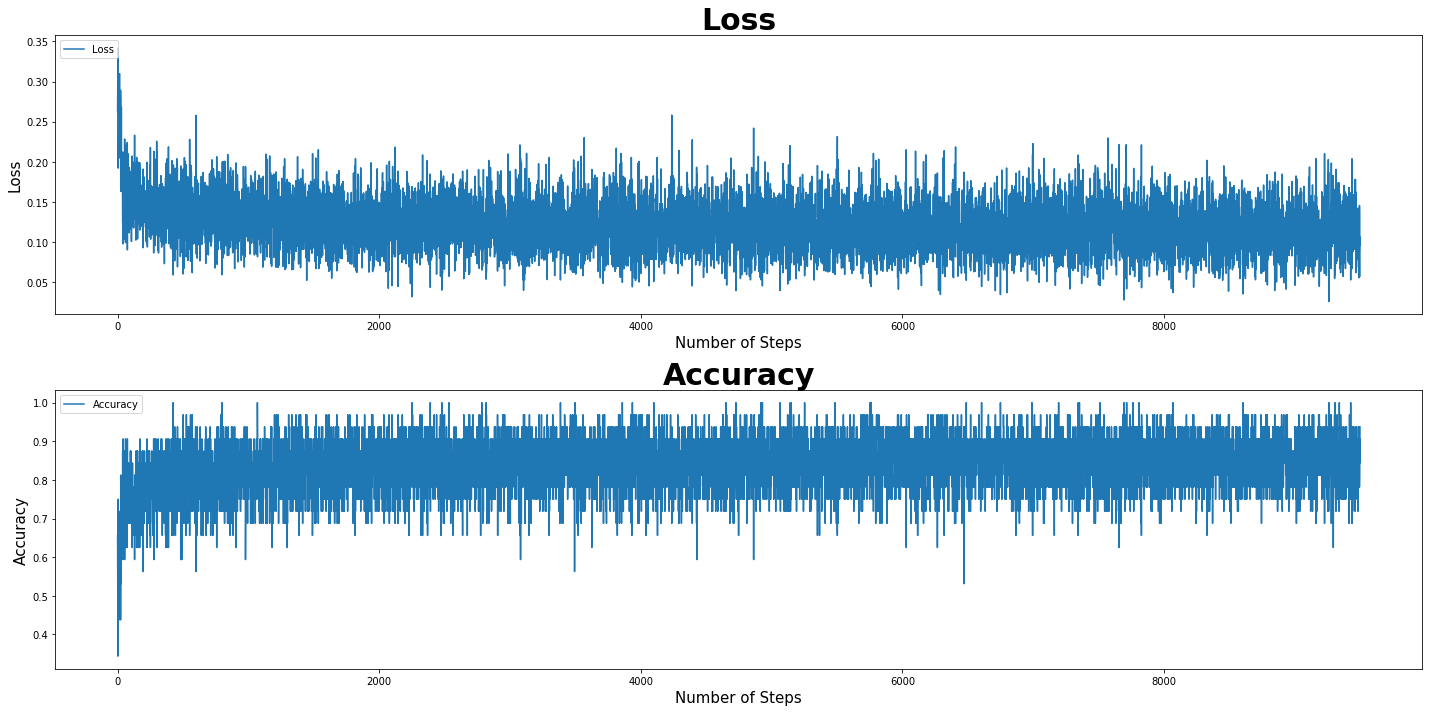

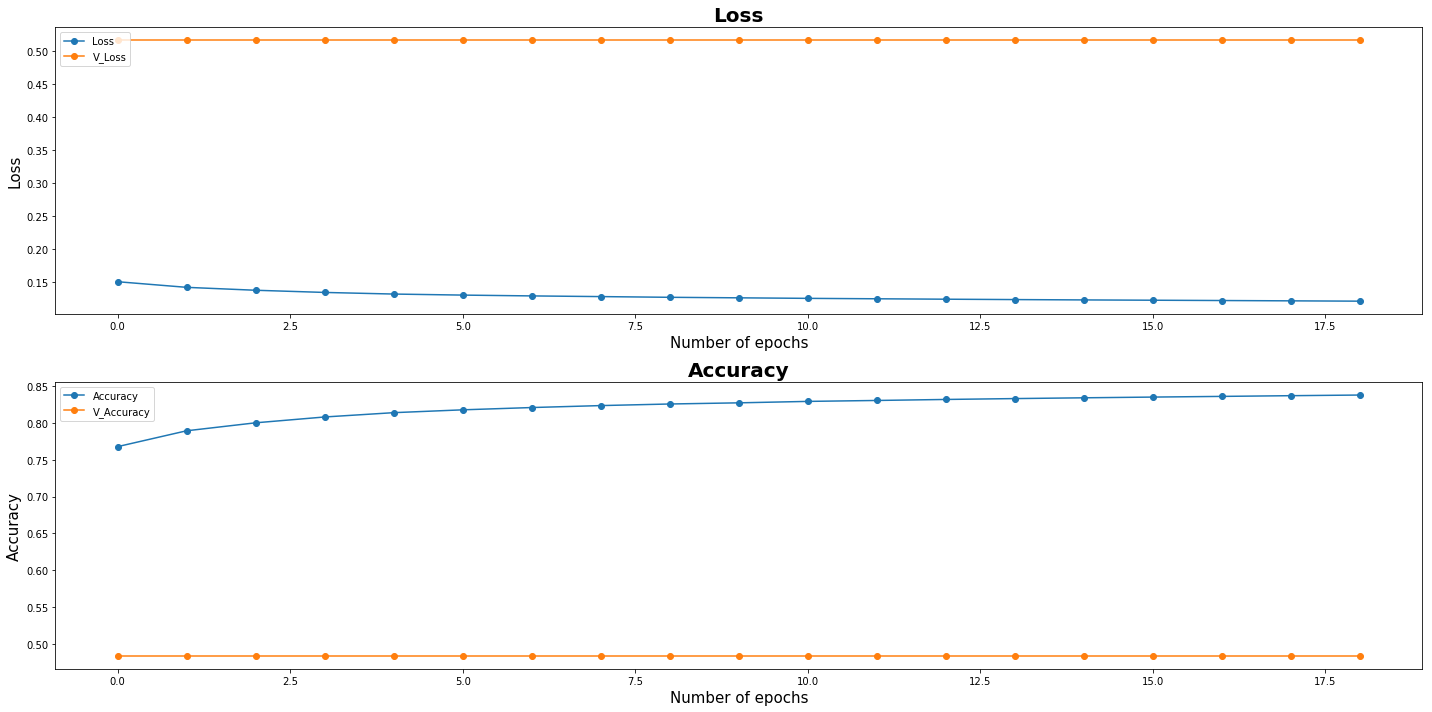

Model Saved


StopIteration: 

In [29]:
while epoch < args.n_epoch:
    siamese.train()
    for i,(data, label) in enumerate(train_loader):

        #scheduler.step()
        start_t = time.time()
        data = data.to(device)
        label = label.to(device)
        siamese(data, label)
        end_t = time.time()
        all_step += 1
        print('| Epoch [%d] | Step [%d] | lr [%.6f] | Loss: [%.4f] | Acc: [%.4f] | Time: %.1fs' %\
              ( epoch, all_step, siamese.optim.param_groups[0]['lr'], siamese.loss.item() , siamese.acc.item() ,
                end_t - start_t))
        
#         if siamese.acc.item() > 0.95: # Stop early
#             raise StopIteration
    
    if i % 1 == 0:
        siamese.eval()
        for j, (v_data, v_label) in enumerate(valid_loader):

            start_t = time.time()
            v_data = v_data.to(device)
            v_label = v_label.to(device)
            siamese.test_step(v_data, v_label)
            end_t = time.time()
            print('| Epoch [%d] | Validation | Step [%d] |  Loss: [%.4f] | Acc: [%.4f] | Time: %.1fs' %\
                  ( epoch, j, siamese.v_loss.item() , siamese.v_acc.item() ,end_t - start_t))
                
    siamese.plot_all_loss('20LSTMColour_Training_0reg')
    
    if epoch >= 1:
        plot_train_hist(train_hist, '20LSTMColour_Epoch_0reg')

    for name in siamese.train_hist.keys():
        train_hist[name].append(sum(siamese.train_hist[name])/len(siamese.train_hist[name]))

    if not args.running_loss:
        for name in siamese.train_hist.keys():
            siamese.train_hist[name] = []
            
    epoch += 1
    
    if epoch % 1 == 0:
        siamese.model_save(epoch)
    
    if epoch >= 20:
        raise StopIteration

In [21]:
##### This Algorithm can solve the problem and make the graph in a batch of training data #####

class Graph_Alg(object):
    
    def __init__(self,):
        self.G = nx.Graph()
    
    def forward(self, x, y):
        
        paired_data = np.array(x[y.byte()])
        for i in paired_data:
            for j in i:
                for k in range(len(j)):
                    if not j[k] in self.G.nodes:
                        self.G.add_node(j[k])
                    if k >= 1:
                        if not (j[k],j[k-1]) in self.G.edges:
                            self.G.add_edge(j[k],j[k-1])
                            
    def draw(self,):
        
        nx.draw(self.G, with_labels=True, font_weight='bold')
        plt.show()
        
    def test(self, x, y):
        
        out = []
        paired_data = np.array(x)
        
        for i in paired_data:
            out.append(self.check_step(i))
        match = list(np.array(out) == np.array(y).astype(int))
        self.acc = sum(match) / len(match)
             
    def check_step(self, i):
        
        # Check the path is in the graph
        for j in i:
            for k in range(len(j)):
                if not j[k] in self.G.nodes:
                    return 0
                if k >= 1:
                    if not (j[k],j[k-1]) in self.G.edges:
                        return 0
                        
        # Check the the pair is possible to have the same st_node   
        for node in list(self.G.adj[i[0][0].item()]):
            if node in list(self.G.adj[i[1][0].item()]):
                return 1

        return 0


In [ ]:
graph_algo = Graph_Alg()
algo_train_hist = defaultdict(list)
num_steps = 20
for i in range(num_steps):
    data, label = iter(train_loader).next()

    # Training
    graph_algo.forward(data, label)
    
    # Testing
    v_data, v_label = iter(valid_loader).next()
    graph_algo.test(v_data, v_label)
    algo_train_hist['Accuracy'].append(graph_algo.acc)
    
plot_train_hist(algo_train_hist, 'Graph_algo')
graph_algo.draw()